In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Параметры модели

In [22]:
LAYERS = 8

# number of voices in polyphonic sampling scheme
VOICES = 5

# for gradient calculation stability (is it needed?)
epsilon = 1e-06

In [23]:
# Network Parameters
num_input = 12                              # dimension of one input at moment
num_hidden = 40                      
num_hidden_voicegen = 100                   # dimension of voices generation layer
num_output = 12                             # output dimension for each voice

num_hidden_decoder = 100                    # dimension of decoder LSTM
num_decoder_output = 88                     # dimension of decoder output

## Модель

In [24]:
class PolyphonySampler(nn.Module):
    def __init__(self):
        super(PolyphonySampler, self).__init__()
        
        self.lstm = nn.LSTM(num_hidden + 2*num_output, num_hidden_voicegen)
        self.linear = nn.Linear(num_hidden_voicegen, 2*num_output)
        
    def init_hidden(self, batch_size):        
        self.hidden = []
        for i in range(VOICES):
            self.hidden.append((Variable(torch.zeros(1, batch_size, num_hidden_voicegen)),
                                Variable(torch.zeros(1, batch_size, num_hidden_voicegen))))
    
    def forward(self, x, next_x=None):
        sampled_notes = torch.zeros(1, x.size()[1], num_output)        
        sample_p = Variable(torch.zeros(1, x.size()[1], num_output))
        neg_sample_p = Variable(torch.ones(1, x.size()[1], num_output))
                                
        banned_notes = torch.zeros(1, x.size()[1], num_output)       
        ban_p = Variable(torch.zeros(1, x.size()[1], num_output))
        neg_ban_p = Variable(torch.ones(1, x.size()[1], num_output))
        
        self.voice_distributions = []
        self.voice_decisions = []
        
        for i in range(VOICES):
            all_input = torch.cat([x, Variable(sampled_notes), Variable(banned_notes)], dim=2)
            coeff = (1 - torch.cat([sampled_notes, sampled_notes], dim=2)) * \
                    (1 - torch.cat([banned_notes, banned_notes], dim=2))
                             
            out, self.hidden[i] = self.lstm(all_input, self.hidden[i])
            out = self.linear(out)
            out = Variable(coeff) * torch.exp(out)                       
            out = out / out.sum(2)[:,:,None]
            
            self.voice_distributions.append(out.data[0].numpy())
            
            sample_p = sample_p + neg_sample_p * out[:,:,:num_output]
            neg_sample_p = neg_sample_p * (1 - out[:,:,:num_output])
                             
            ban_p = ban_p + neg_ban_p * out[:,:,num_output:]
            neg_ban_p = neg_ban_p * (1 - out[:,:,num_output:])
            
            sample = torch.LongTensor(x.size()[1], 2*num_output).zero_()
            sample.scatter_(1, torch.multinomial(out.squeeze(0).data, 1), 1)
            
            self.voice_decisions.append(sample.numpy())
            
            if self.training:
                sample = torch.cat([(sample[:,:num_output] + sample[:,num_output:]) * next_x,
                                    (sample[:,:num_output] + sample[:,num_output:]) * (1 - next_x)], dim=1)
            
            sampled_notes[0] += sample[:,:num_output].float()
            banned_notes[0]  += sample[:,num_output:].float()
        
        return sampled_notes, sample_p*(1 - ban_p)

In [78]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.lstm = [nn.LSTM(num_hidden + num_output, num_hidden), nn.LSTM(num_hidden + 2*num_output, num_hidden)]
        for _ in range(LAYERS - 3):
            self.lstm.append(nn.LSTM(3*num_hidden, num_hidden))
        self.lstm.append(nn.LSTM(2*num_hidden, num_hidden))
        
        self.sampler = PolyphonySampler()
        
        self.init_hidden(1)
        
    def init_hidden(self, batch_size): 
        self.hidden = [(Variable(torch.zeros(1, batch_size, num_hidden)),
                        Variable(torch.zeros(1, batch_size, num_hidden))) for _ in range(LAYERS)]
        
        self.plan = [[Variable(torch.zeros(1, batch_size, num_output)),
                      Variable(torch.zeros(1, batch_size, num_output))]]
        for _ in range(LAYERS - 1):
            self.plan.append([Variable(torch.zeros(1, batch_size, num_hidden)),
                              Variable(torch.zeros(1, batch_size, num_hidden))])
        
        self.sampler.init_hidden(batch_size)
        
        self.t = 0
    
    def forward(self, x, next_x=None):
        self.plan[0][0] = self.plan[0][1]
        self.plan[0][1] = x
        
        for i in np.arange(LAYERS)[::-1]:
            if self.t % (2**i) == 0:
                if i == 0:
                    inp = torch.cat([self.plan[i][1], self.plan[i + 1][1]], dim=2)
                elif i == LAYERS - 1:
                    inp = torch.cat([self.plan[i - 1][0], self.plan[i - 1][1]], dim=2)
                else:
                    inp = torch.cat([self.plan[i - 1][0], self.plan[i - 1][1], self.plan[i + 1][1]], dim=2)
                    
                out, self.hidden[i] = self.lstm[i](inp, self.hidden[i])
                
                if i != 0:
                    self.plan[i][0] = self.plan[i][1]
                    self.plan[i][1] = out
        
        return self.sampler(out, next_x)

In [79]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.lstm = nn.LSTM(num_output + num_decoder_output, num_hidden_decoder)  
        self.linear = nn.Linear(num_hidden_decoder, num_decoder_output)      
        self.init_hidden(1)
        
    def init_hidden(self, batch_size):        
        self.decoder_hidden = (Variable(torch.zeros(1, batch_size, num_hidden_decoder)),
                             Variable(torch.zeros(1, batch_size, num_hidden_decoder)))
    
    def forward(self, x, prev_x_decoded):            
        inp = torch.cat([x, prev_x_decoded], dim=2)
        
        out, self.decoder_hidden = self.lstm(inp, self.decoder_hidden) 
        out = F.sigmoid(self.linear(out))
        
        return out
    
    def sample(self, out):
        p = out.data.numpy()
        
        return np.random.uniform(size=num_decoder_output) < p #wrong

In [110]:
def learn(model, decoder, batch_x, batch_decoded, optimizer, decoder_optimizer):
        
    model.init_hidden(batch_x.shape[1])
    decoder.init_hidden(batch_x.shape[1])
    model.train()
    decoder.train()

    optimizer.zero_grad()
    decoder_optimizer.zero_grad()
        
    basic_p = Variable(torch.FloatTensor(batch_x.shape[0] - 1, batch_x.shape[1], num_output)).zero_() 
    decoder_p = Variable(torch.FloatTensor(batch_x.shape[0] - 1, batch_x.shape[1], num_decoder_output)).zero_()  
    voice_distributions, voice_decisions = [], []
    
    for t in range(len(batch_x)-1):
        inp = Variable(torch.FloatTensor(batch_x[t]))[None]        
        _, basic_p[t] = model(inp, torch.LongTensor(batch_x[t+1]))
        
        decoder_inp = Variable(torch.FloatTensor(batch_x[t + 1]))[None], \
                      Variable(torch.FloatTensor(batch_decoded[t]))[None]
                       
        decoder_p[t] = decoder(*decoder_inp)
        
        voice_distributions.append(model.sampler.voice_distributions)
        voice_decisions.append(model.sampler.voice_decisions)
        
    y = Variable(torch.FloatTensor(batch_x[1:]))
    loss = -(y * torch.log(basic_p) + (1 - y)*torch.log(1 - basic_p))
    loss_picture = loss.data.numpy()
    
    y = Variable(torch.FloatTensor(batch_decoded[1:]))
    mask = Variable(torch.FloatTensor(np.tile(batch_x[1:], (1, 1, 1 + num_decoder_output // num_output))[:,:,:num_decoder_output]))
    decoder_loss = -(y * torch.log(decoder_p) + (1 - y)*torch.log(1 - decoder_p))*mask
    decoder_loss_picture = decoder_loss.data.numpy()
    
    loss.sum(2).mean().backward()
    (decoder_loss.mean() / mask.sum()).backward()
    
    optimizer.step()
    decoder_optimizer.step()
   
    return loss_picture, decoder_loss_picture, np.array(voice_distributions), np.array(voice_decisions)
        
def sample(model, decoder, start, decoder_start, time_limit):
    model.init_hidden(1)
    decoder.init_hidden(1)
    model.eval()
    decoder.eval()
    
    sample = [start[0]]
    decoded_sample = [decoder_start[0]]
    
    for t in range(len(start)-1):
        inp = Variable(torch.FloatTensor(start[t])[None, None])
        next_notes, _ = model(inp)
        
        decoder_inp = Variable(torch.FloatTensor(start[t+1])[None, None]), \
                      Variable(torch.FloatTensor(decoder_start[t+1])[None, None])
        next_decoded = decoder(*decoder_inp)
        
        sample.append(start[t+1])
        decoded_sample.append(decoder_start[t+1])
    
    next_notes = torch.FloatTensor(start[-1][None, None])
    
    while len(sample) < time_limit:
        next_notes, _ = model(Variable(next_notes))
        
        decoder_inp = Variable(torch.FloatTensor(decoded_sample[-1].astype(np.float32))[None, None])
        next_decoded = decoder(Variable(next_notes), decoder_inp)
        
        sample.append(next_notes[0][0].numpy())
        
        mask = np.tile(sample[-1], (1 + num_decoder_output // num_output))[:num_decoder_output]
        decoded_sample.append(mask * (np.random.uniform(size=88) < next_decoded.data[0][0].numpy()))
        
    return np.array(sample), np.array(decoded_sample)

## Данные

In [91]:
songs = np.load("CP_dataset.npy")

In [92]:
batch_size = 140
fragment_lentgh = 256
fragment_step = 32

In [93]:
def compress(song):    
    compressed = song[:, :12]
    for i in range(1,7):
        compressed = np.logical_or(compressed, song[:, 12*i:12*i+12])            
    return compressed

In [94]:
song_fragments = []
csong_fragments = []

for song in songs:
    csong = compress(song)
    
    for i in range(0, csong.shape[0] - fragment_lentgh, fragment_step):
        song_fragments.append(song[i:i+fragment_lentgh])
        csong_fragments.append(csong[i:i+fragment_lentgh])

song_fragments = np.array(song_fragments)
csong_fragments = np.array(csong_fragments)

In [95]:
def batchGenerator():
    while True:
        indexes = np.random.choice(np.arange(len(csong_fragments)), batch_size)
        batch_x, batch_decoded = csong_fragments[indexes], song_fragments[indexes]
                
        to_roll = np.random.randint(-6, 6)
        if to_roll > 0:
            batch_decoded[:, :, -to_roll:] = 0
        else:
            batch_decoded[:, :, :-to_roll] = 0

        batch_x = np.roll(batch_x, to_roll, axis=2)
        batch_decoded = np.roll(batch_decoded, to_roll, axis=2)
        
        yield np.moveaxis(batch_x, 1, 0).astype(np.float32), \
              np.moveaxis(batch_decoded, 1, 0).astype(np.float32)

### Графика

In [96]:
def drawNotes(song, name="", scale=(None, None)):
    if scale[0] is None:
        scale = (song.shape[0] / 10, song.shape[1] / 10)
    
    plt.figure(figsize=scale)
    plt.title(name)
    plt.imshow(song.T, aspect='auto', origin='lower')
    plt.xlabel("time")
    plt.xticks(np.arange(0, song.shape[0], 4))
    plt.show()

# Обучение

In [97]:
model = Model()
decoder = Decoder()

In [98]:
#model.load_state_dict(torch.load("my second pytorch model.pt"))
#decoder.load_state_dict(torch.load("my second pytorch model decoder.pt"))

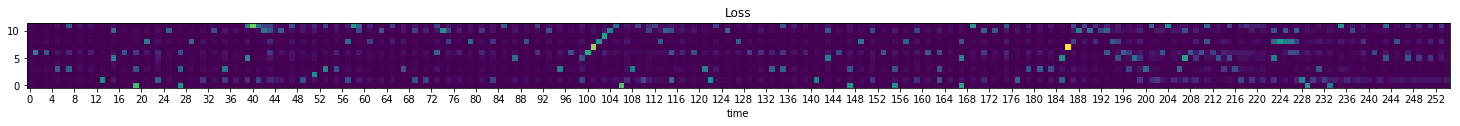

2.69659


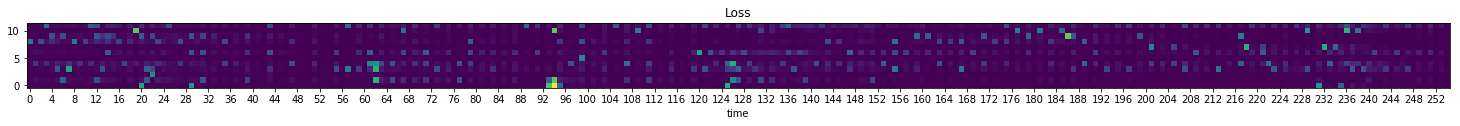

2.76388


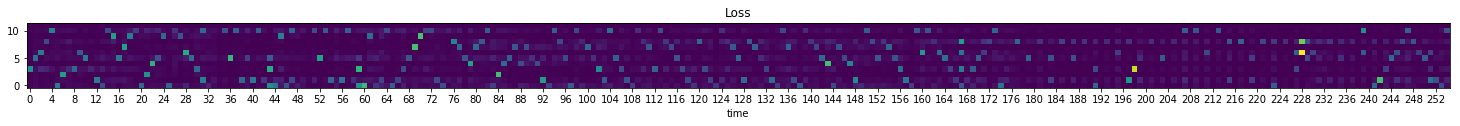

2.61059


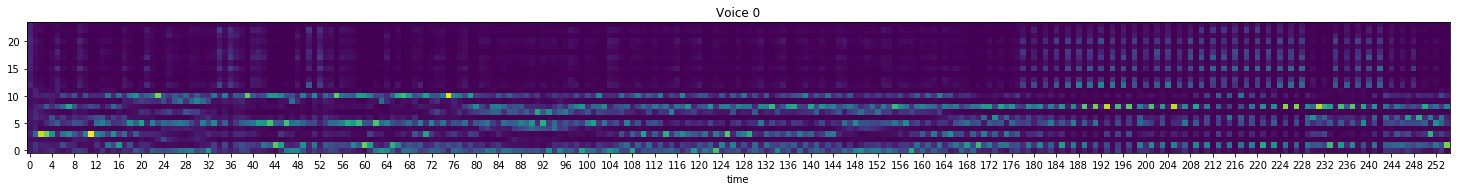

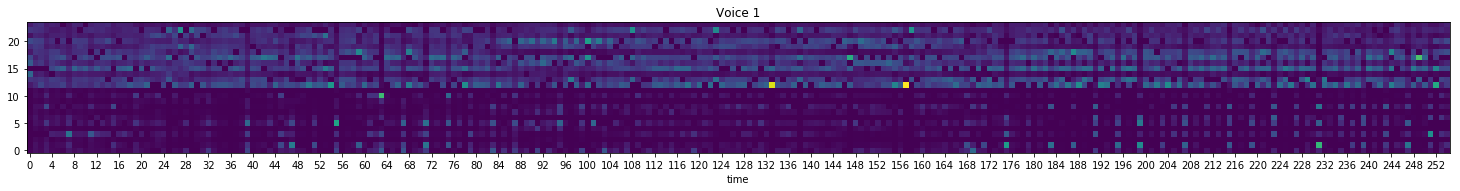

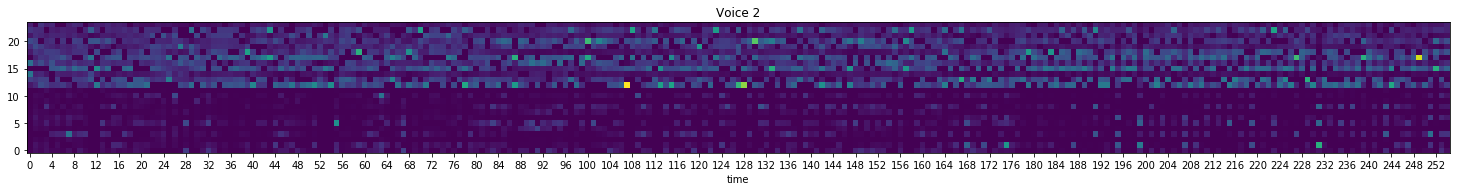

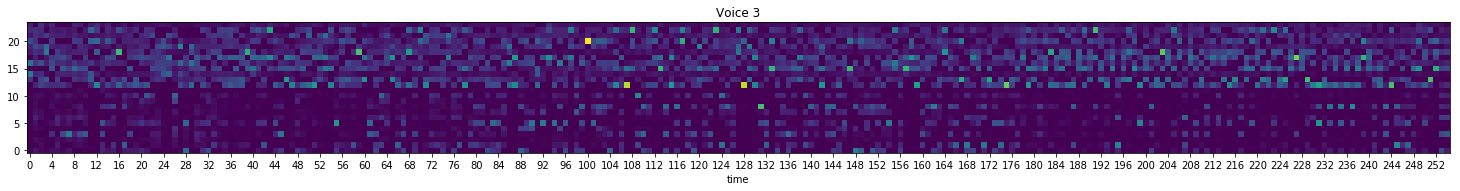

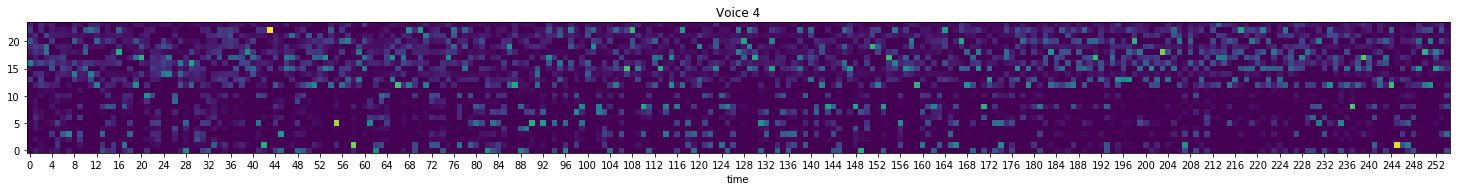

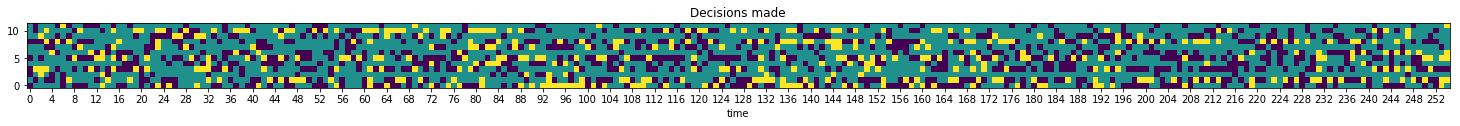

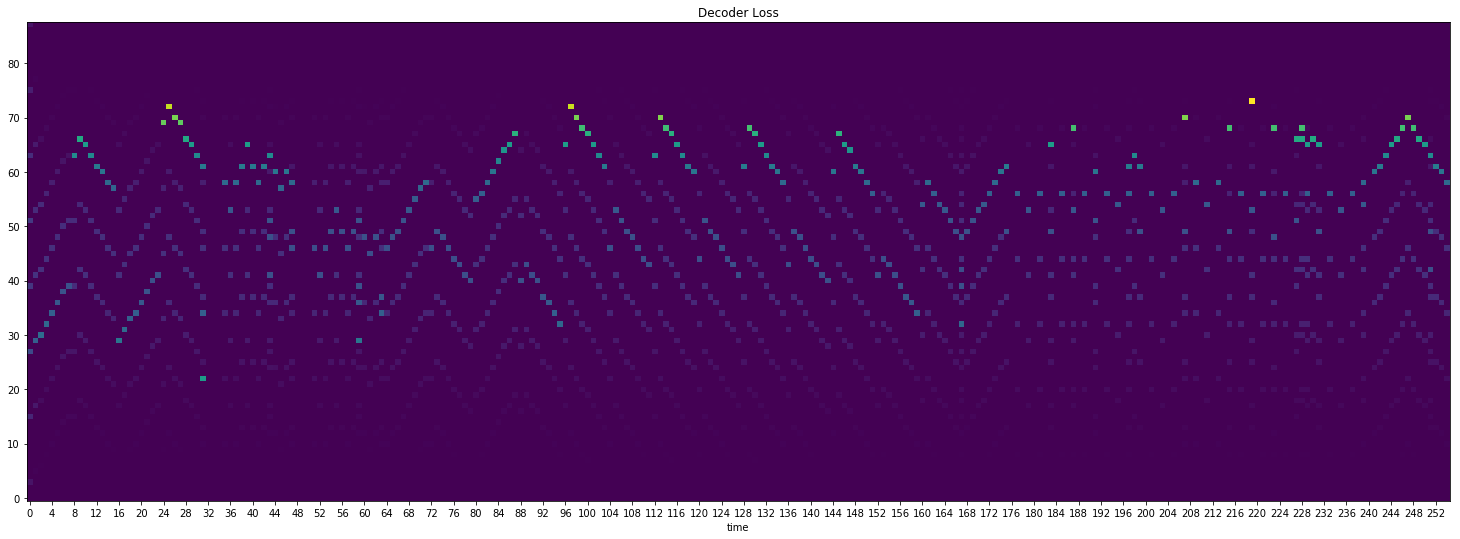

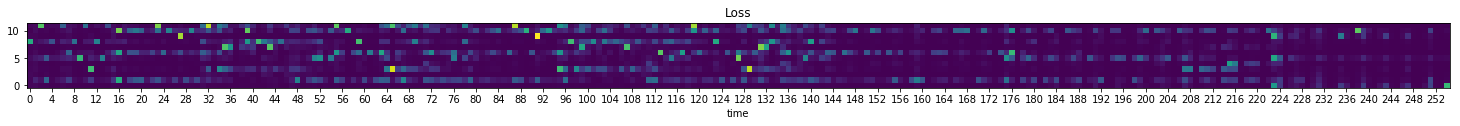

2.66579


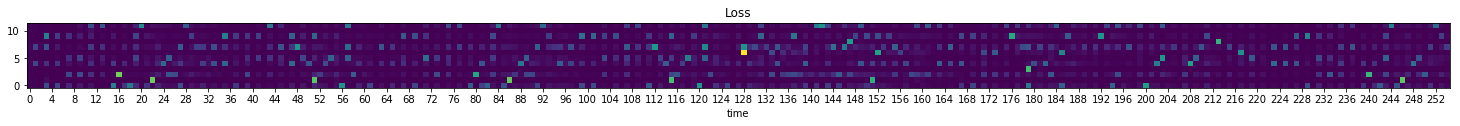

2.52388


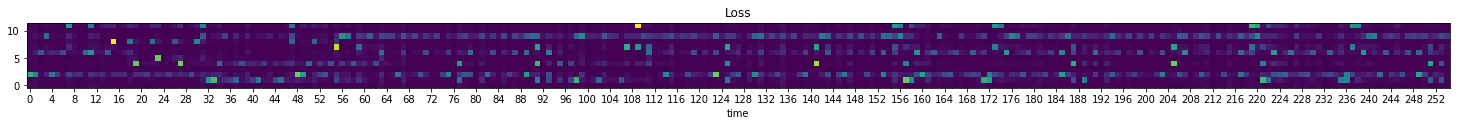

2.56995


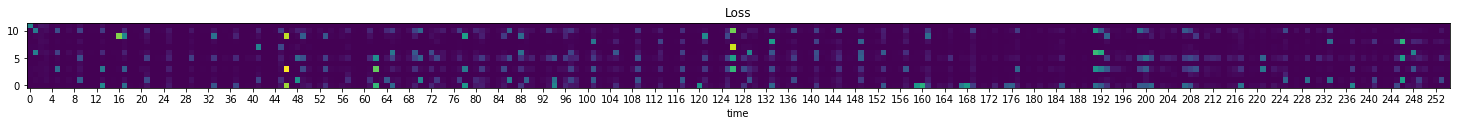

2.4585


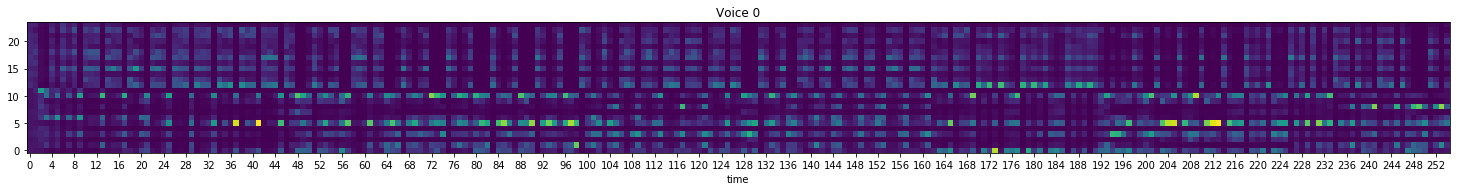

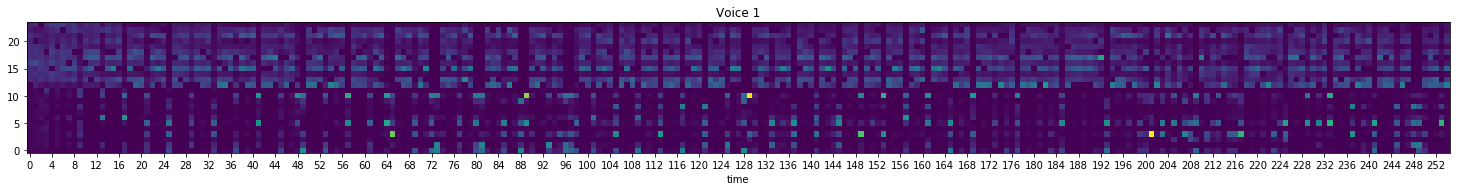

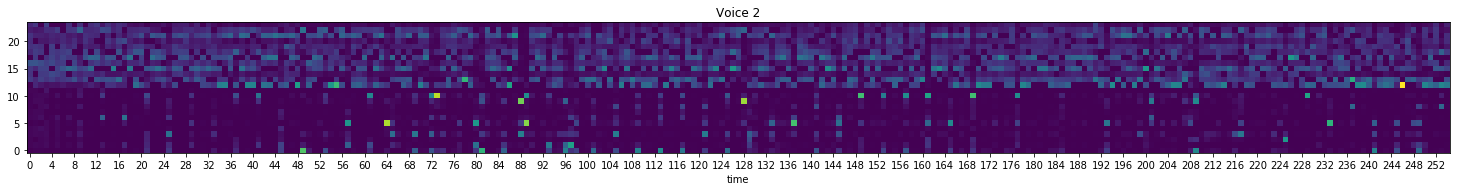

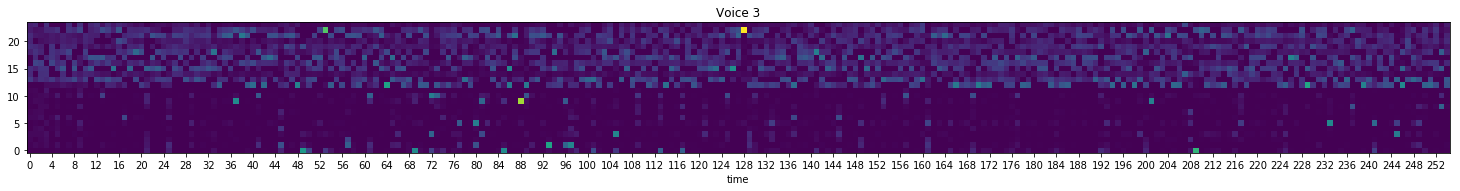

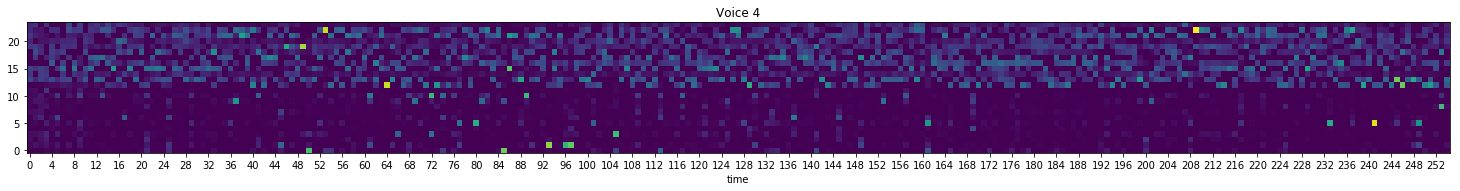

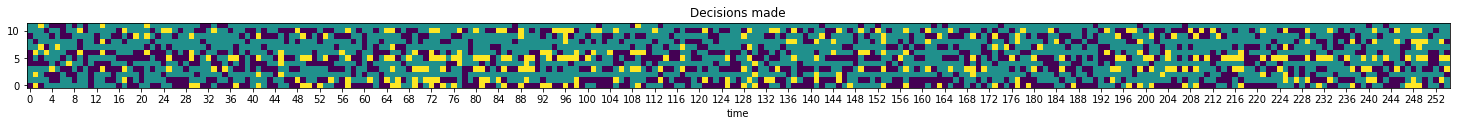

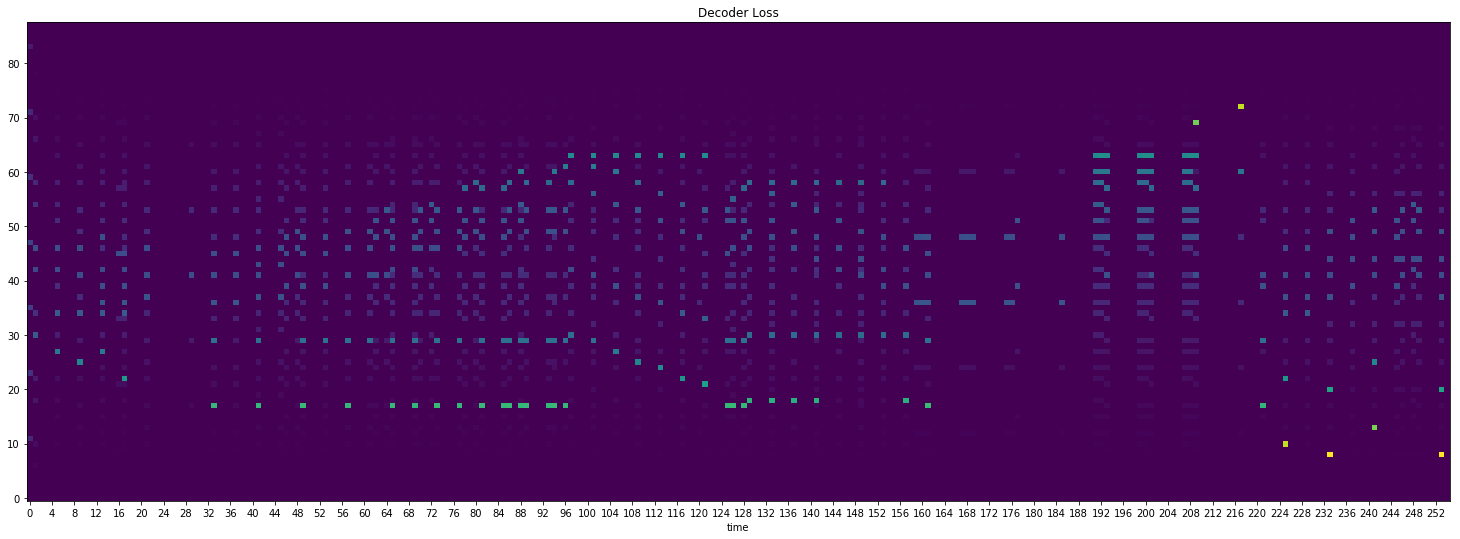

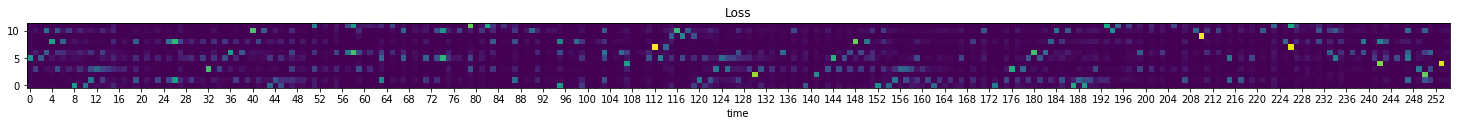

2.54787


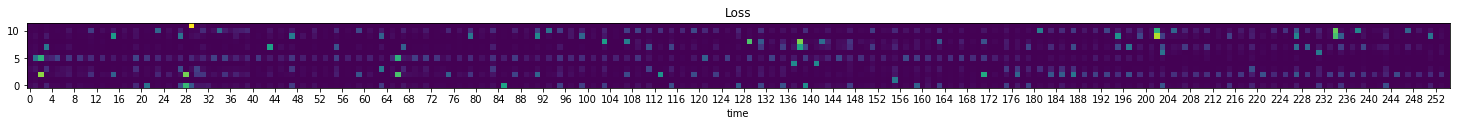

2.41282


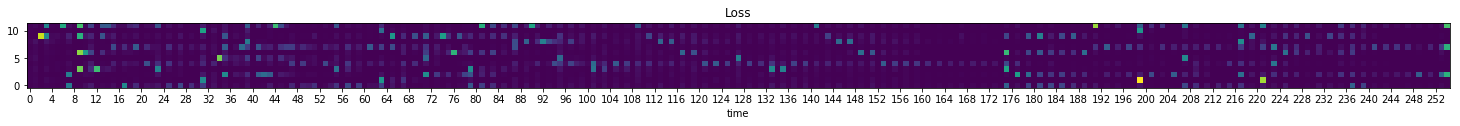

2.53733


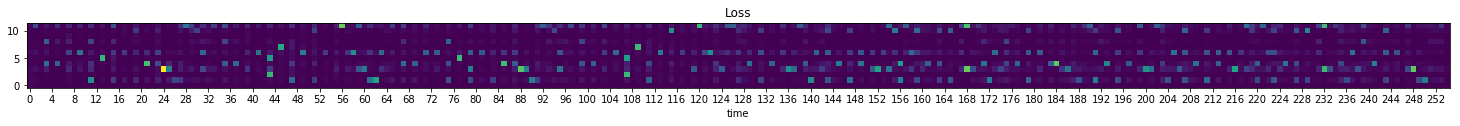

2.51374


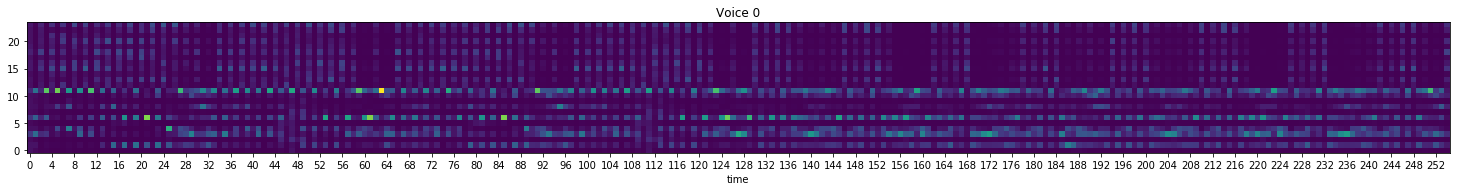

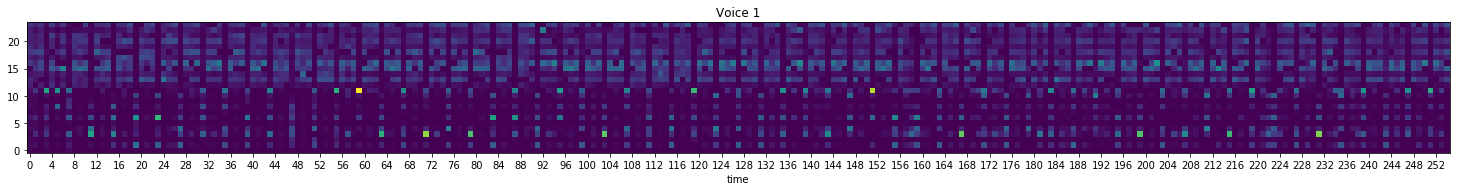

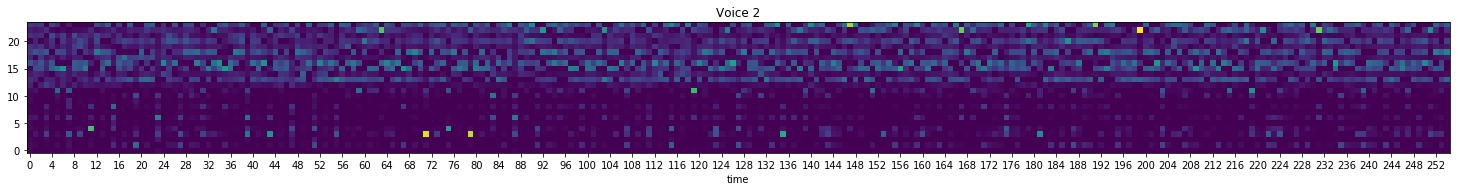

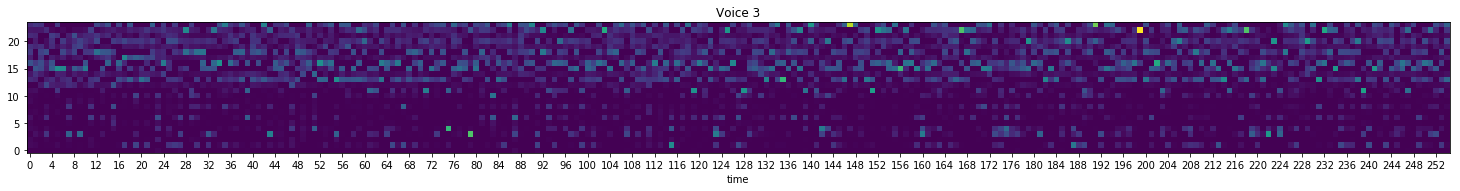

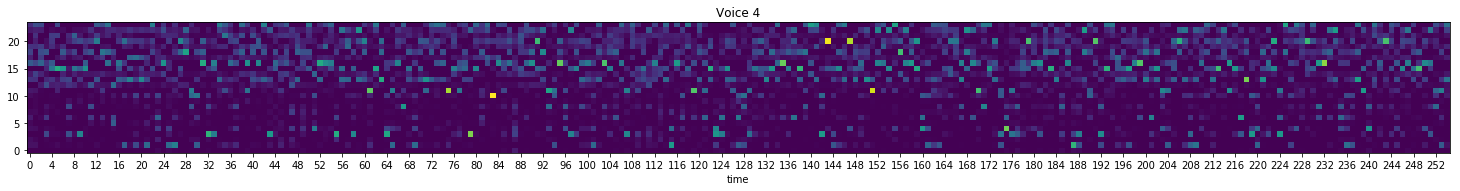

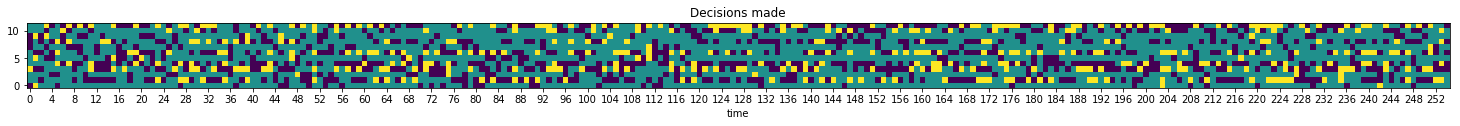

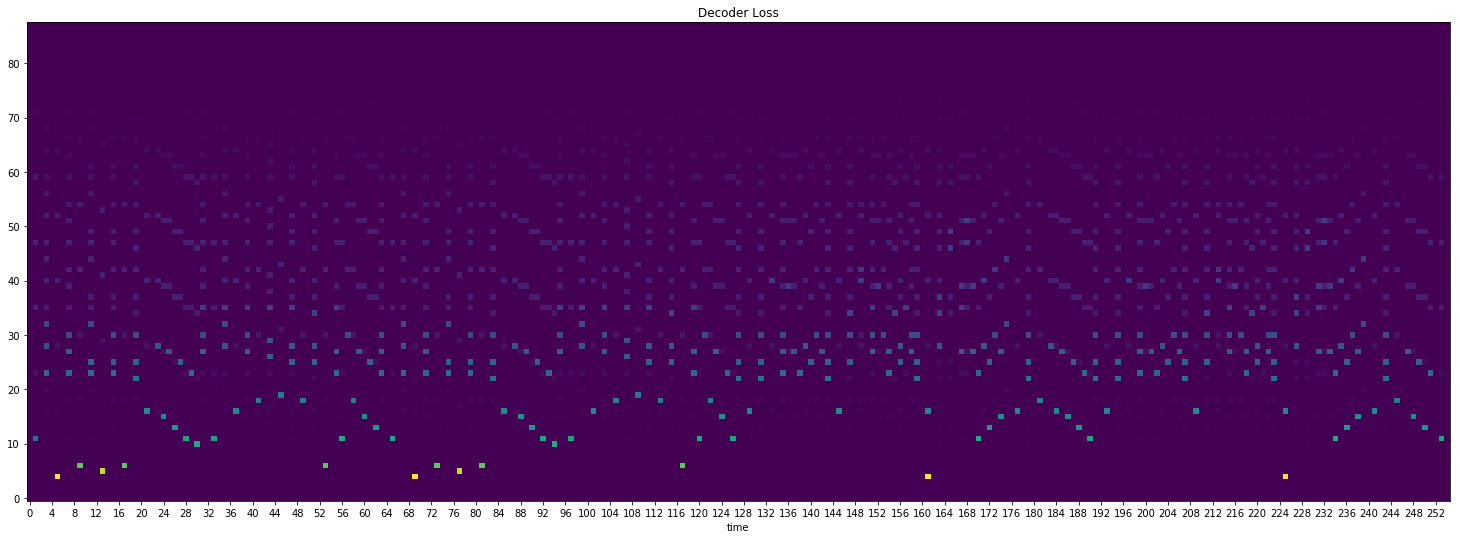

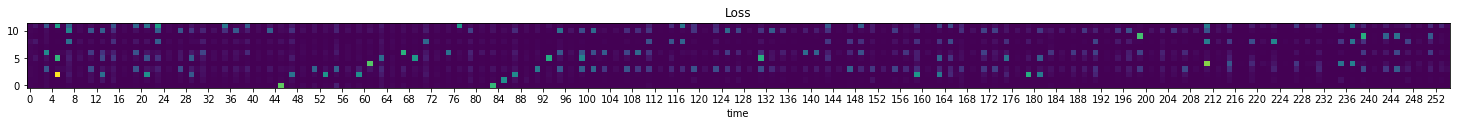

2.45096


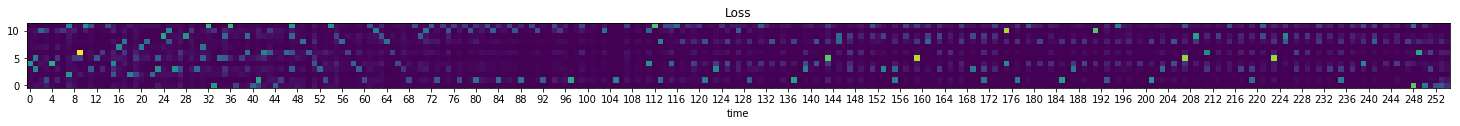

2.39282


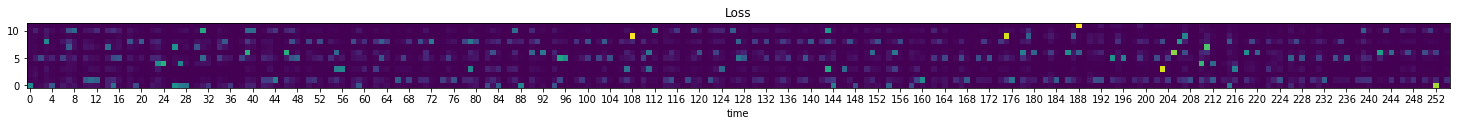

2.65882


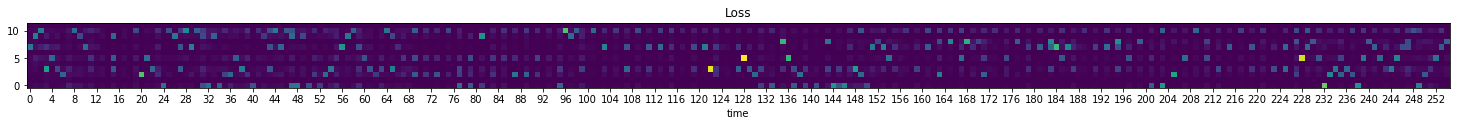

2.49408


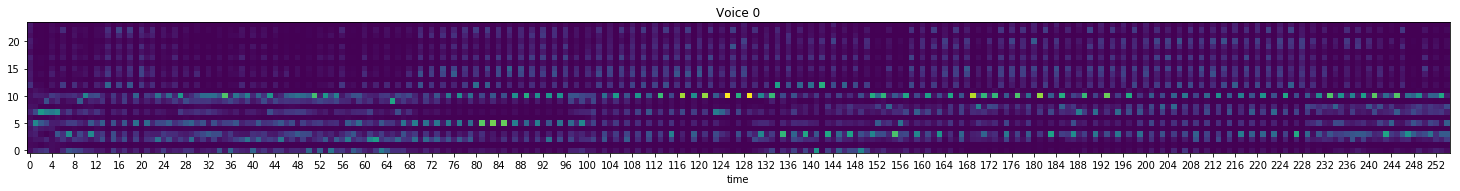

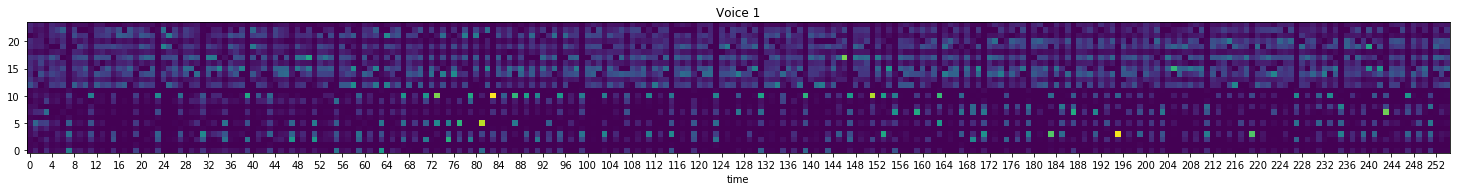

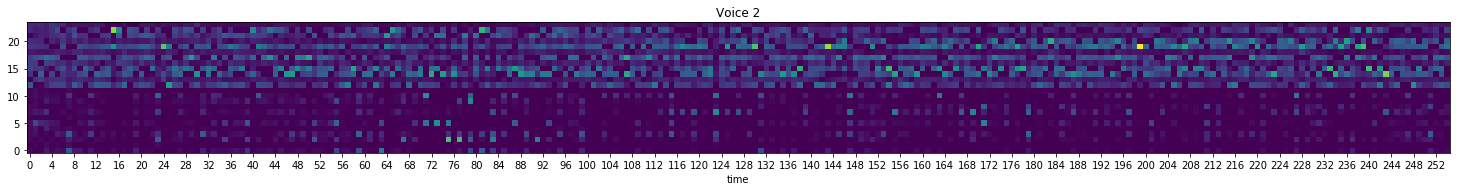

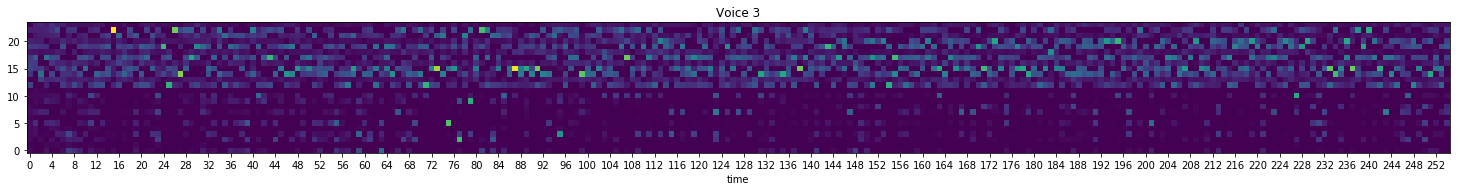

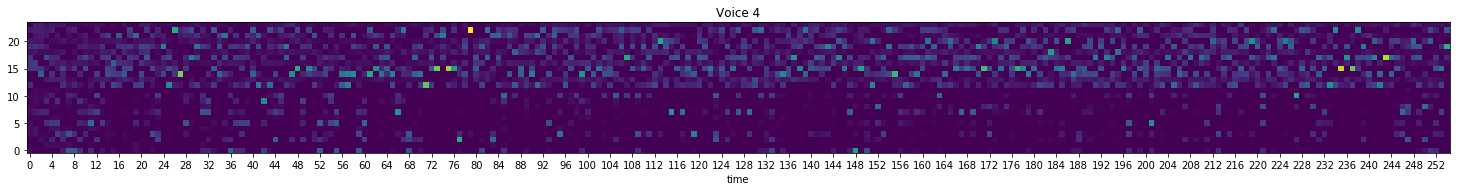

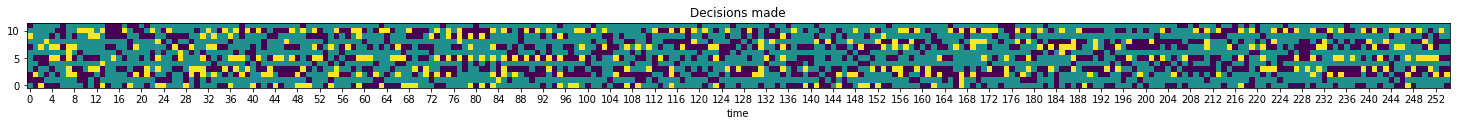

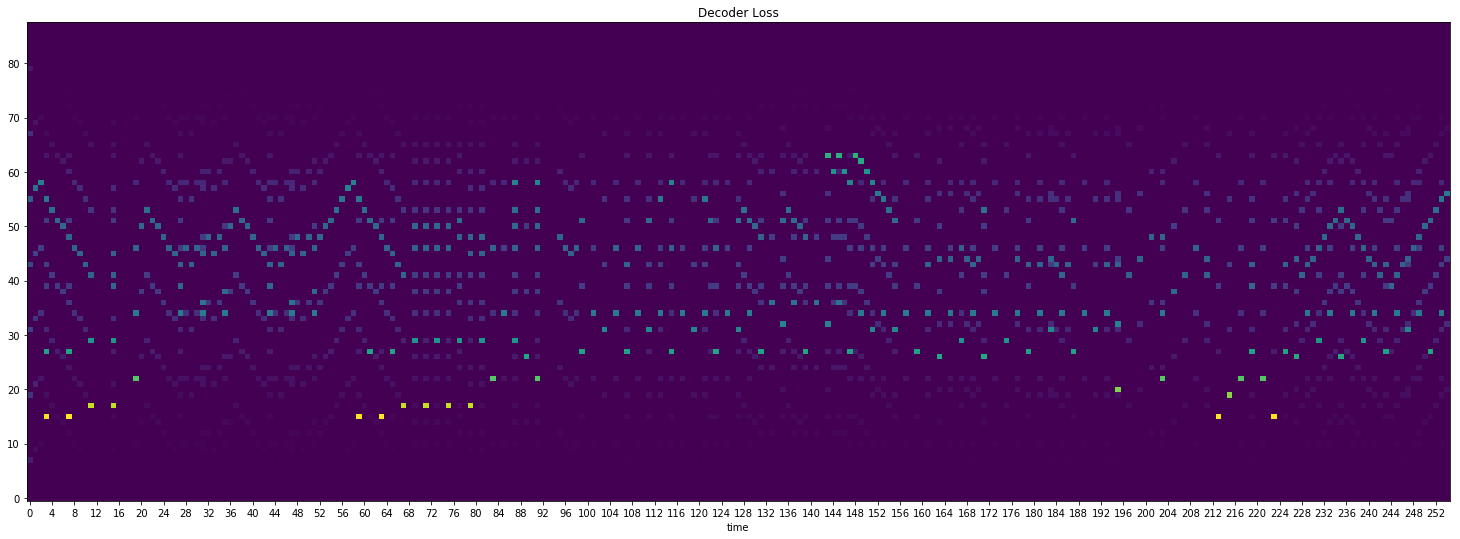

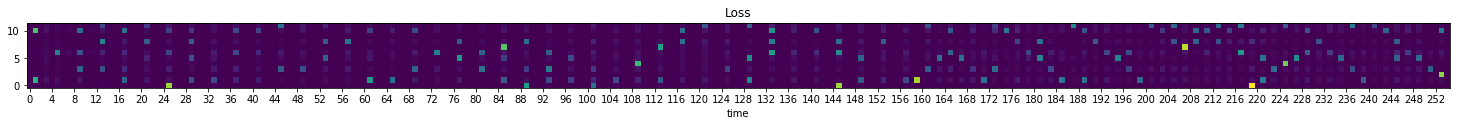

2.59452


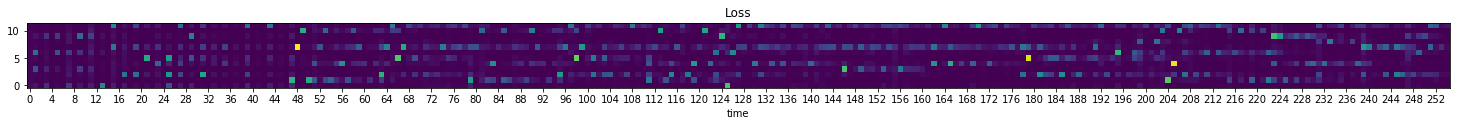

2.56995


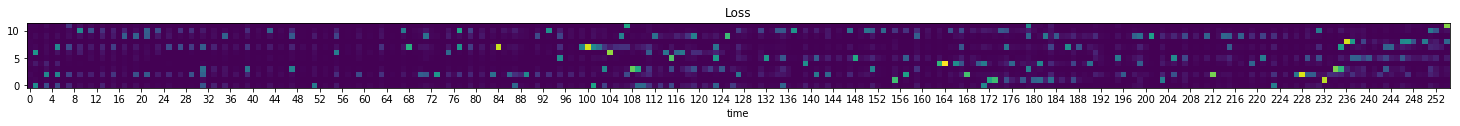

2.53464


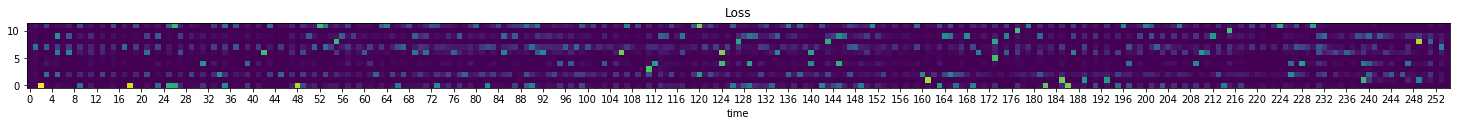

2.5199


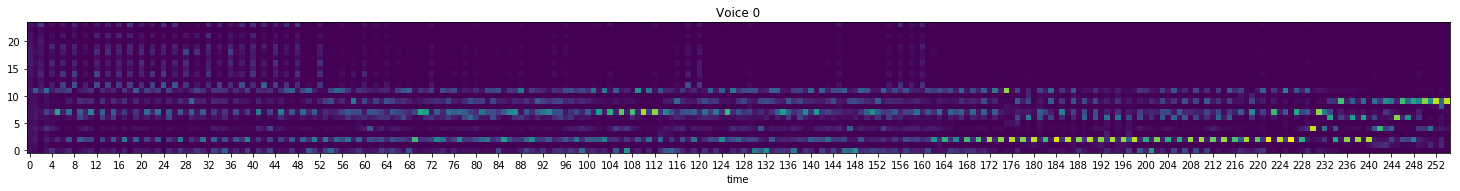

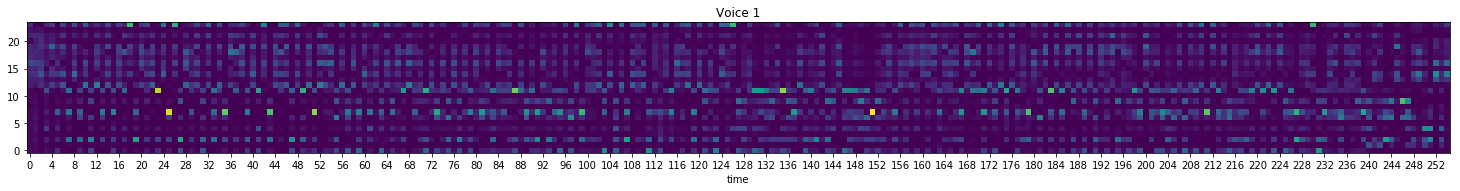

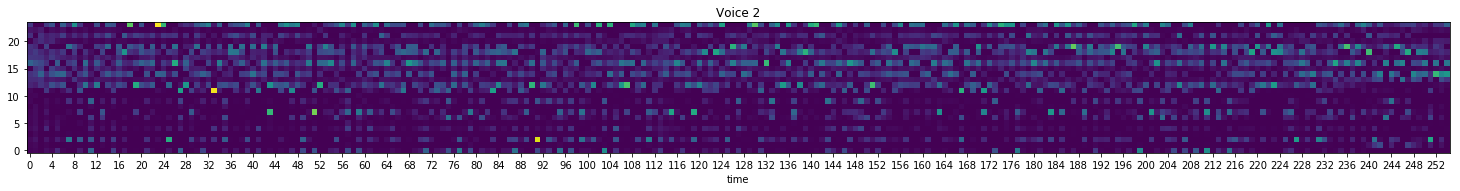

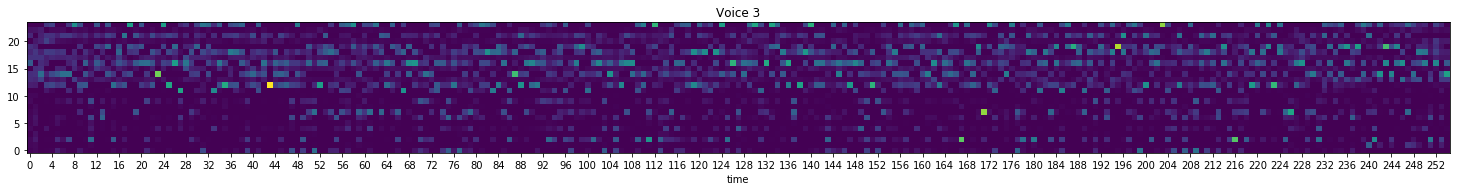

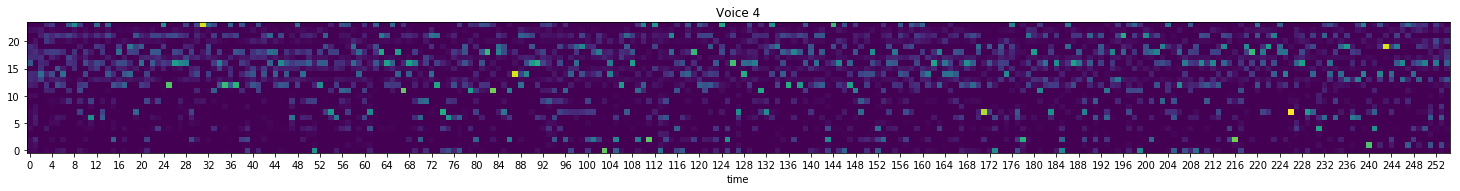

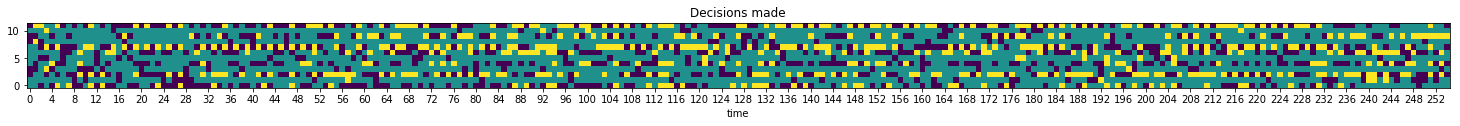

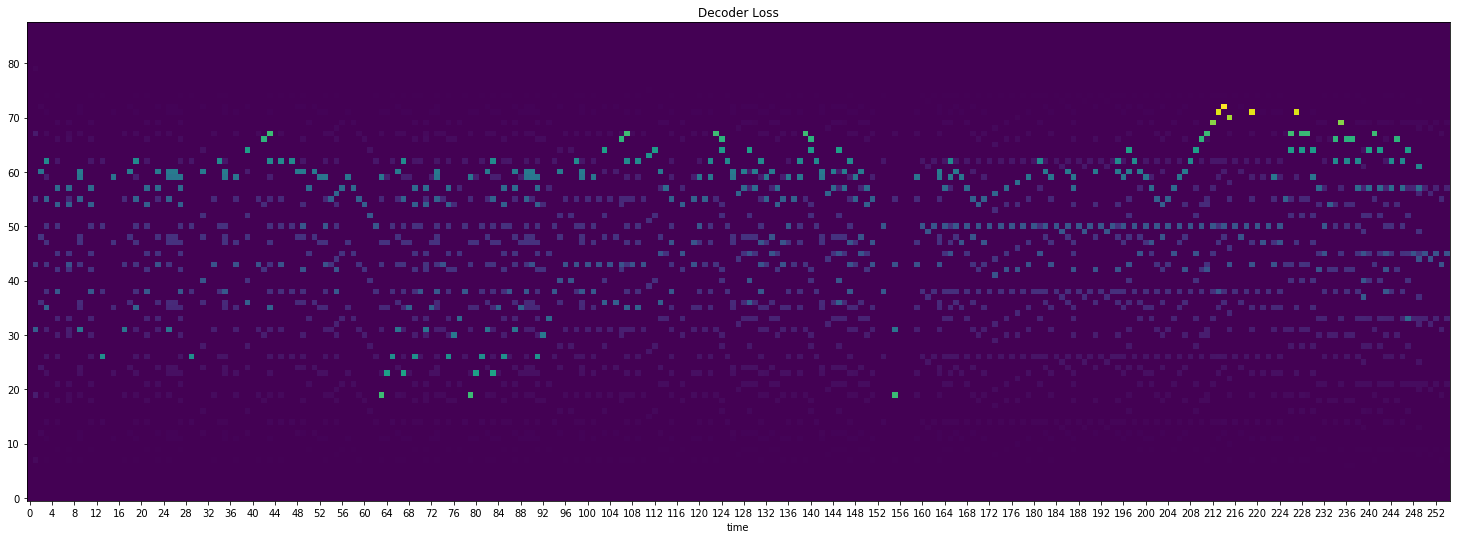

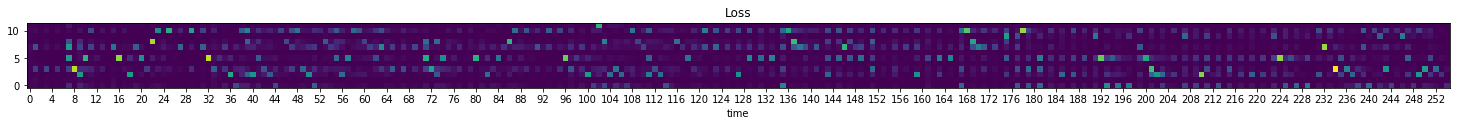

2.5793


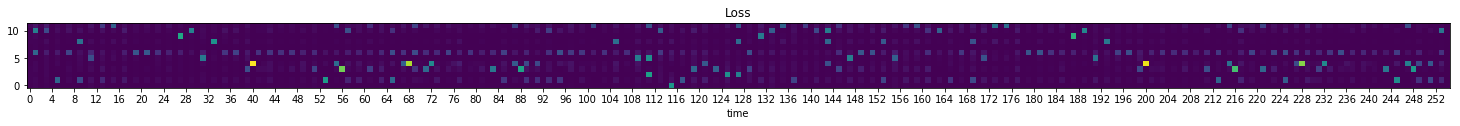

2.47443


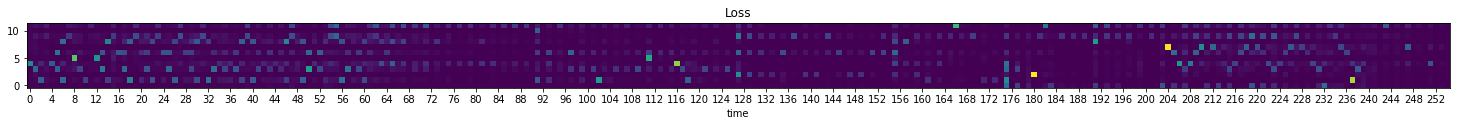

2.43354


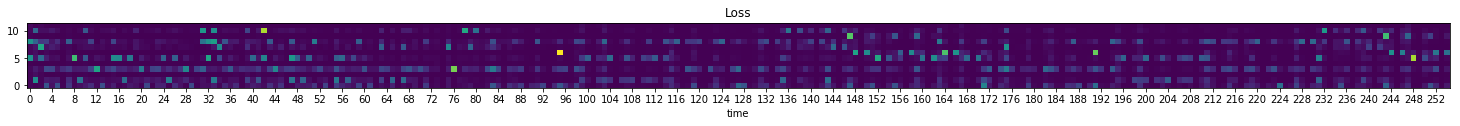

2.45725


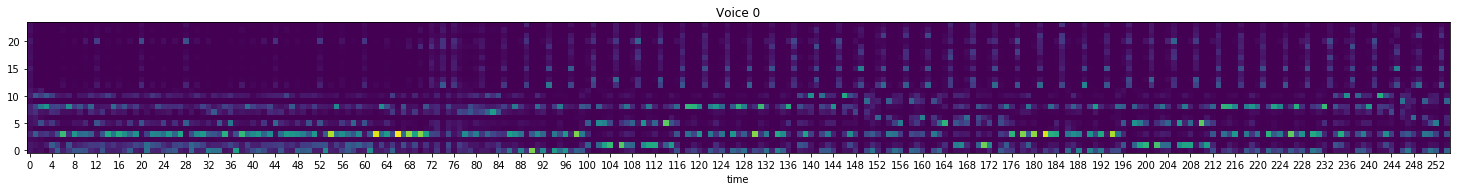

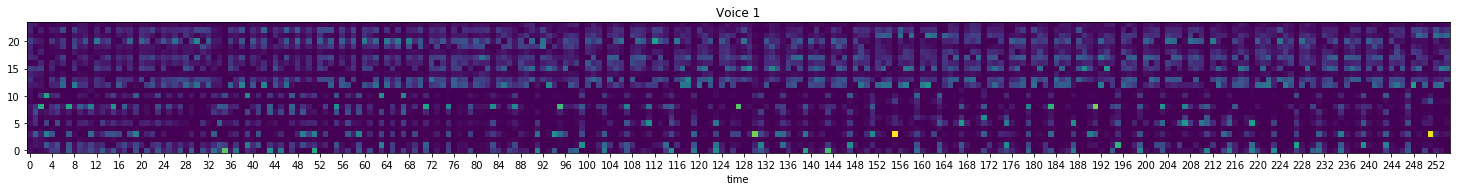

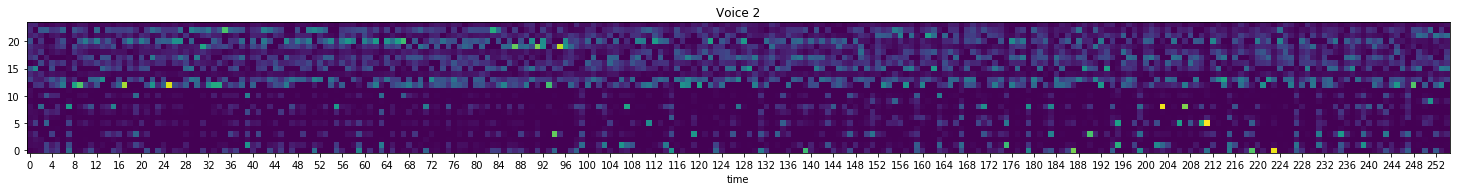

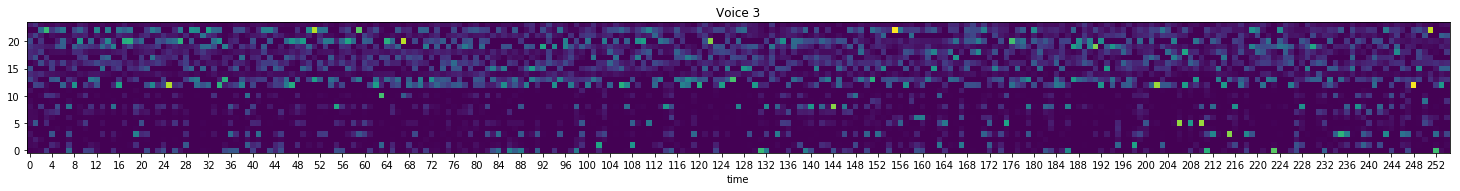

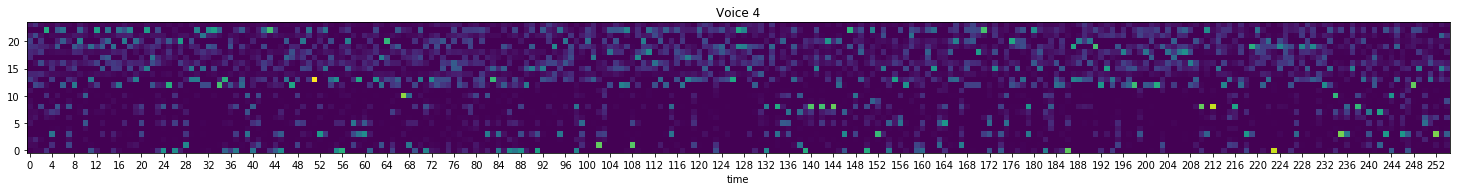

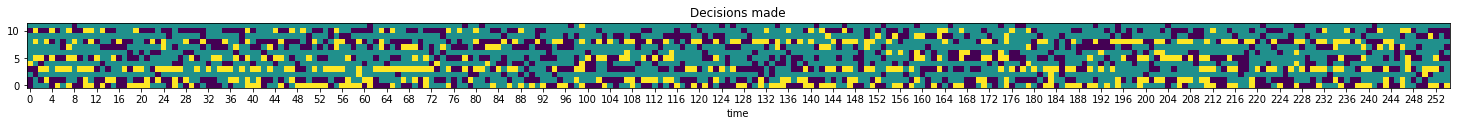

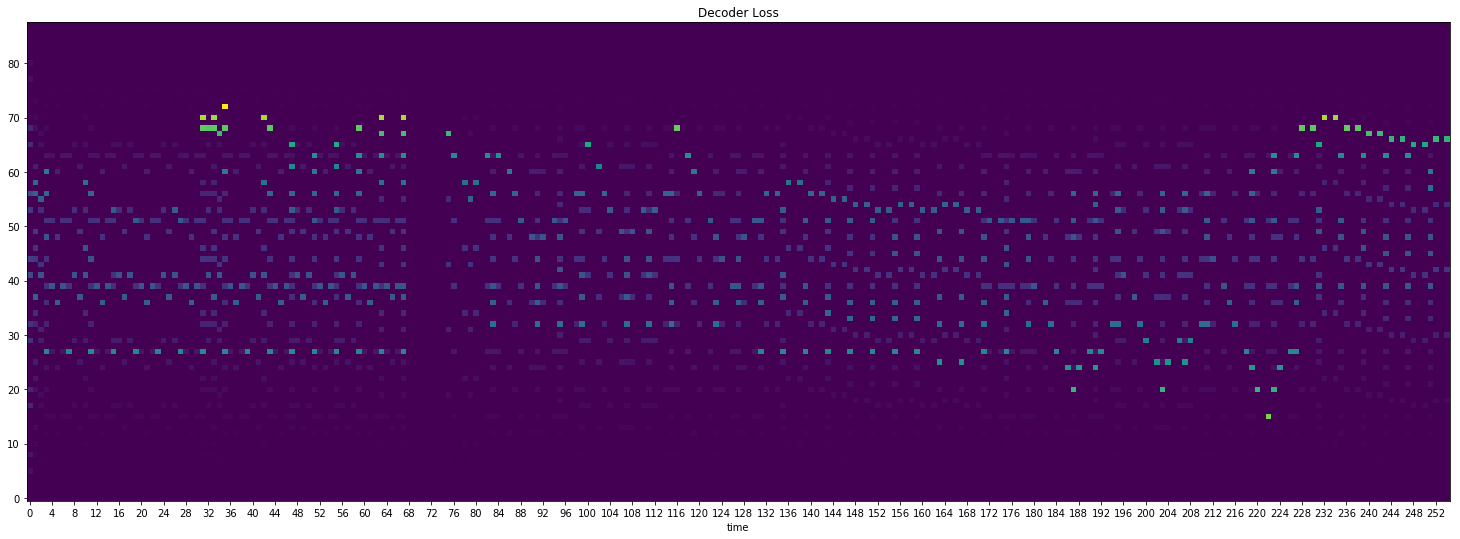

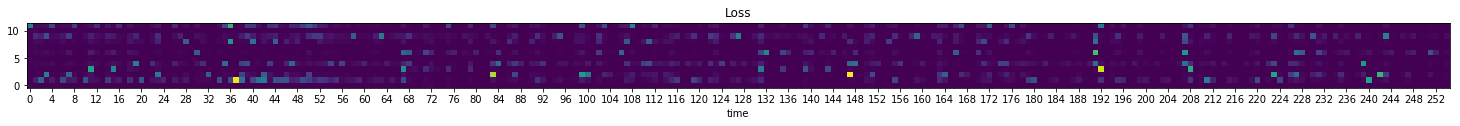

2.36215


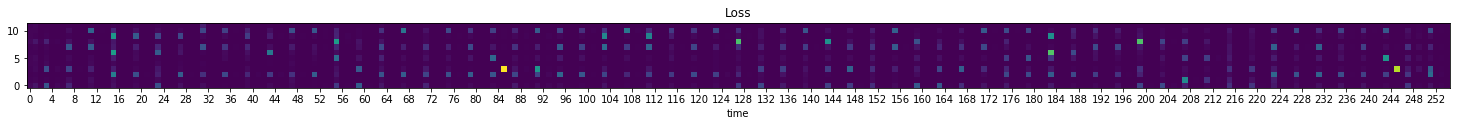

2.46361


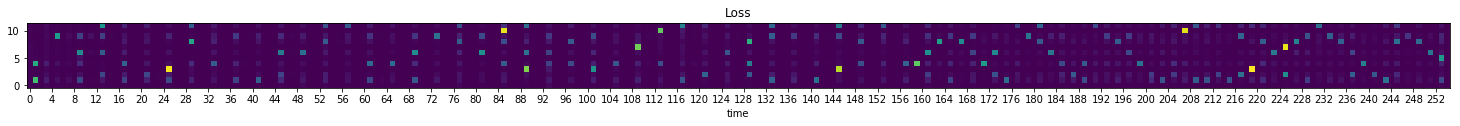

2.41298


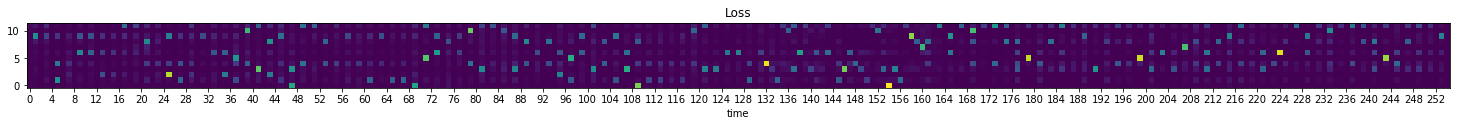

2.44419


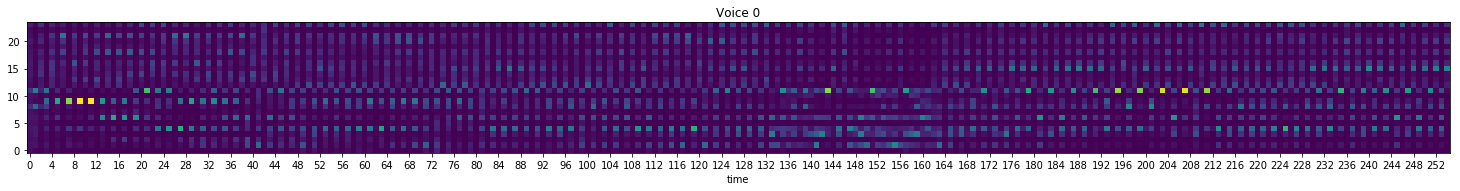

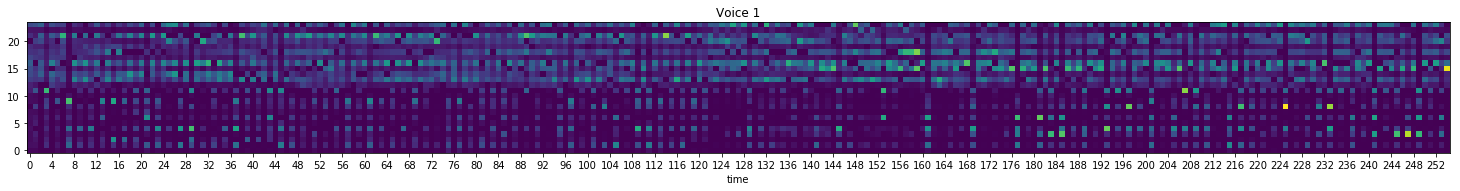

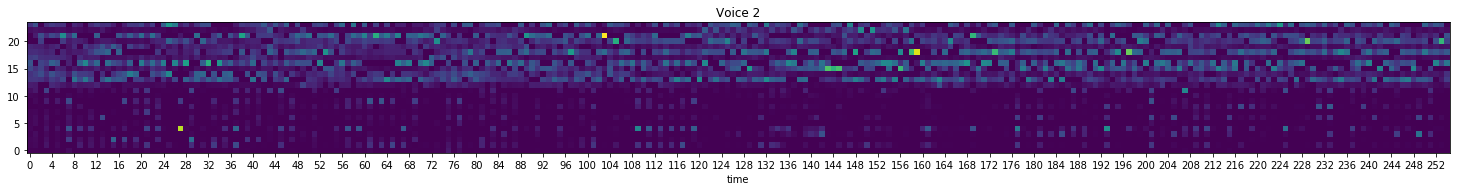

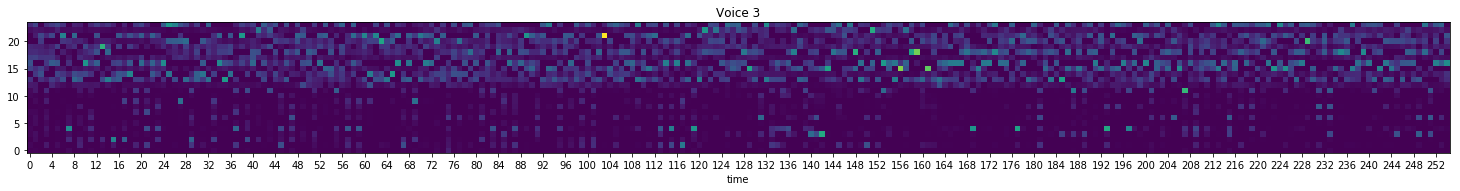

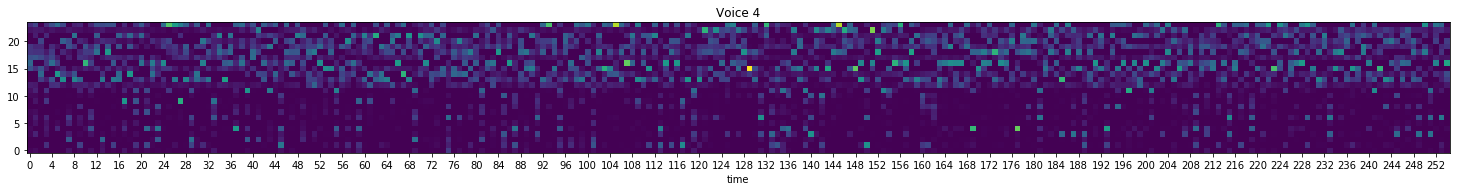

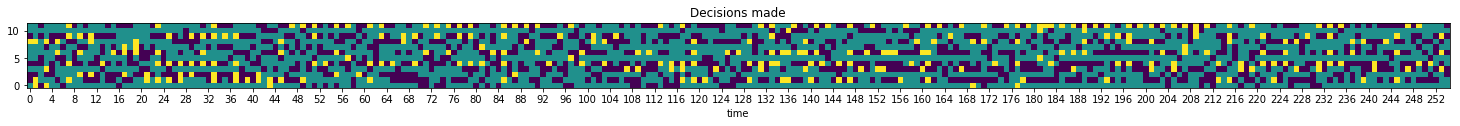

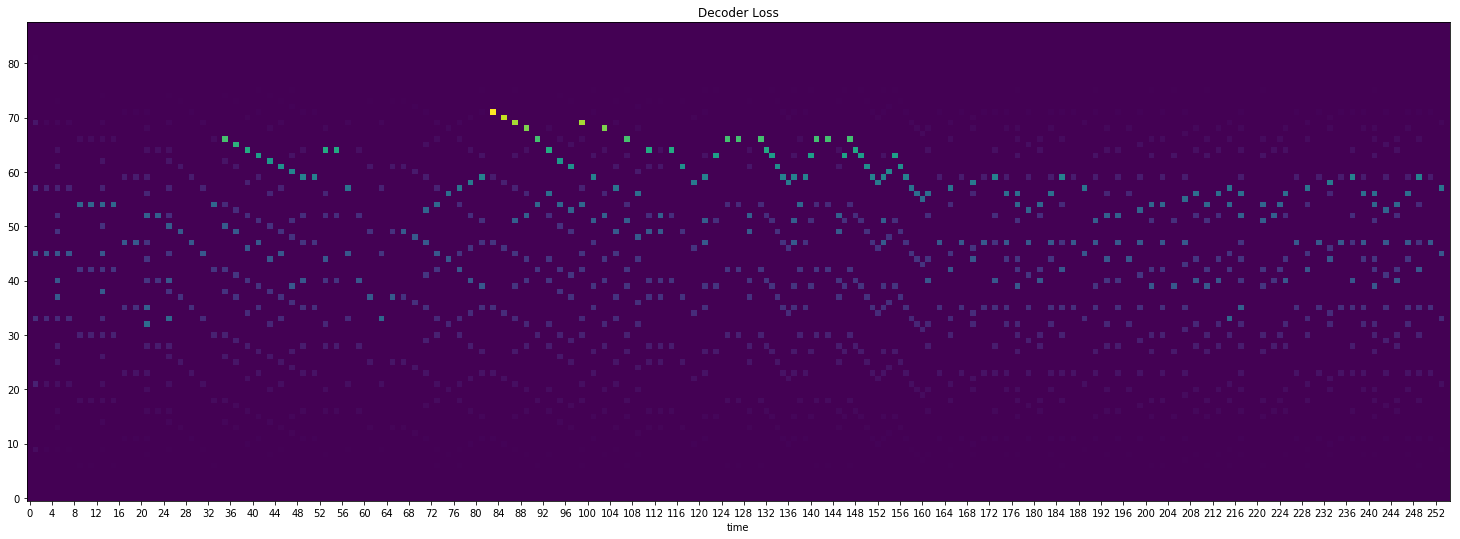

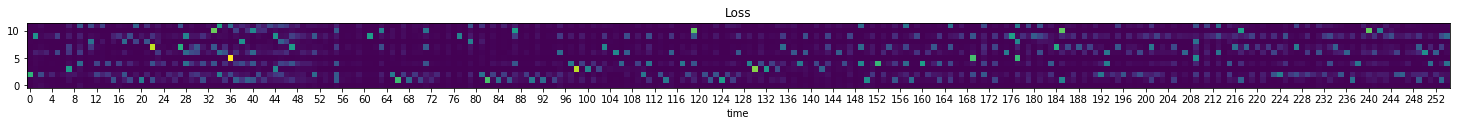

2.54103


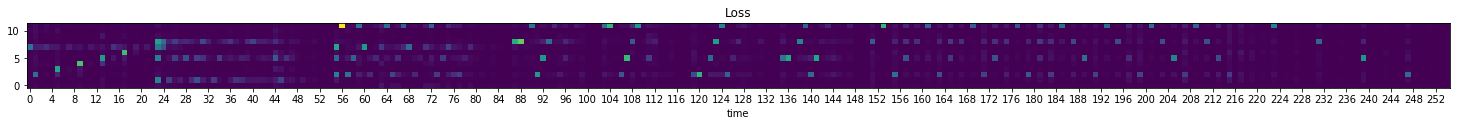

2.47457


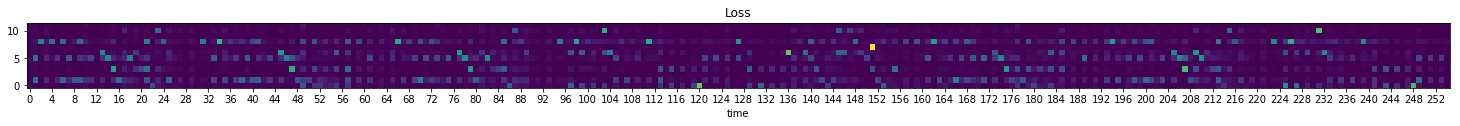

2.47062


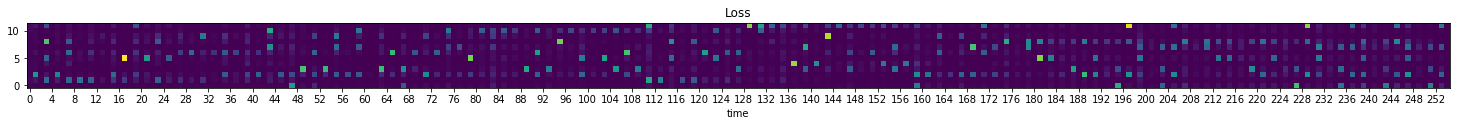

2.56071


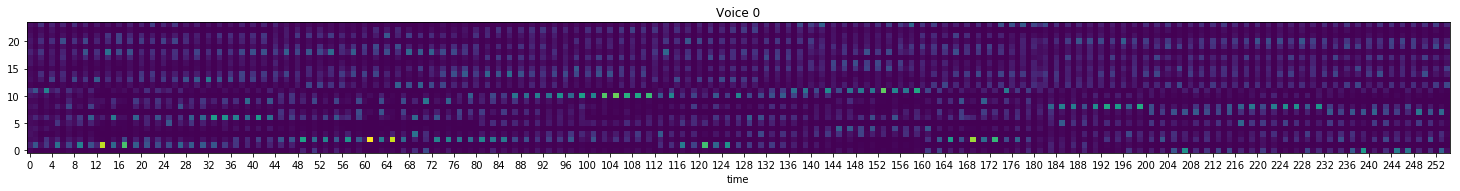

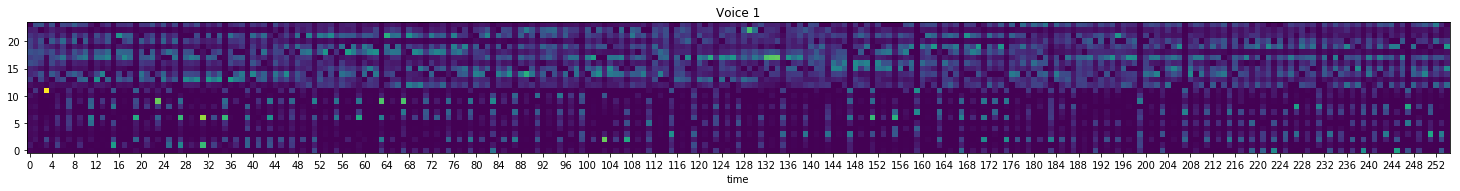

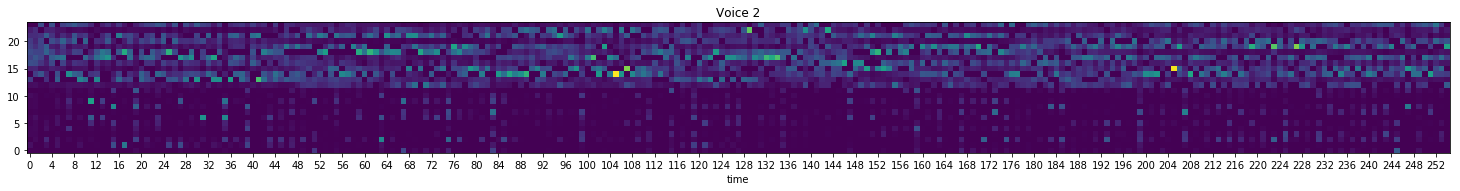

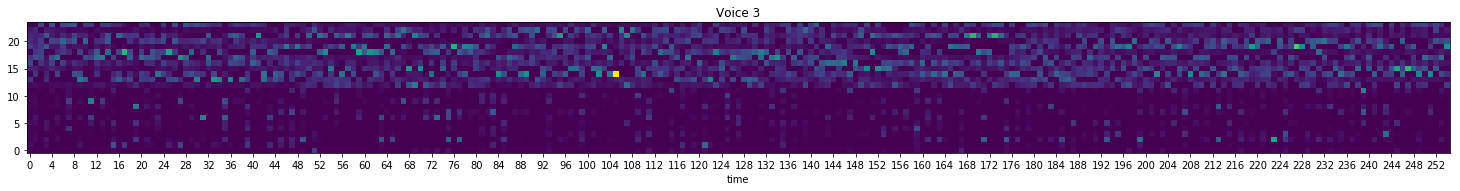

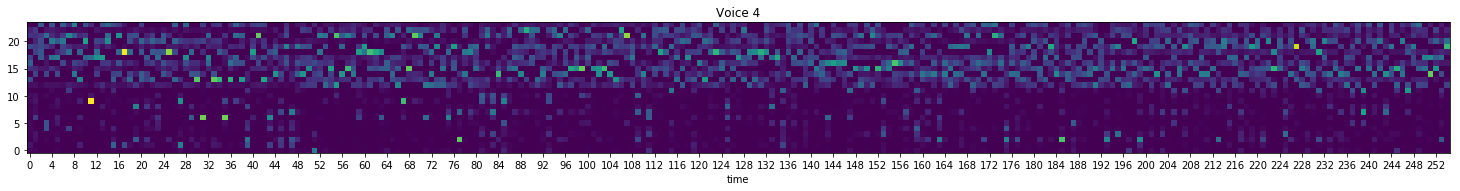

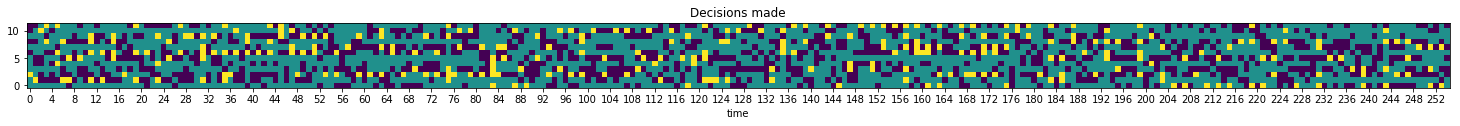

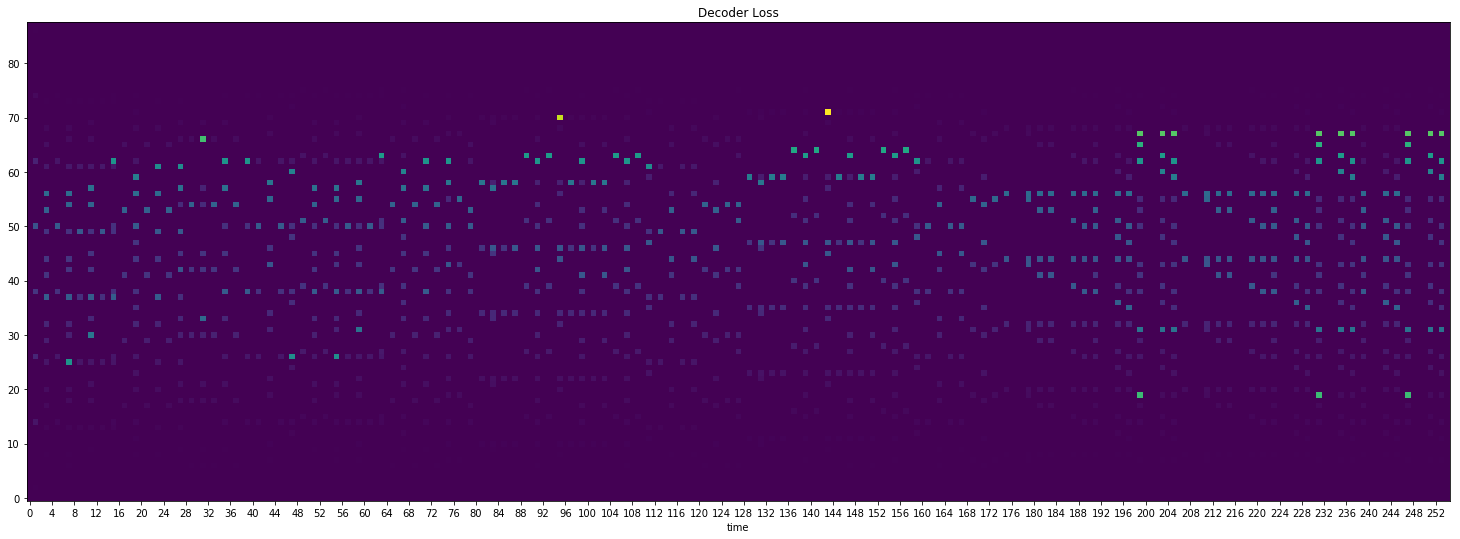

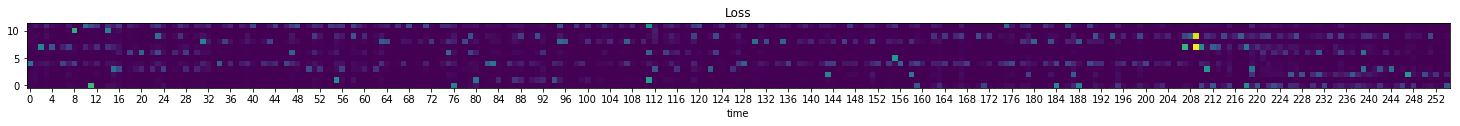

2.48688


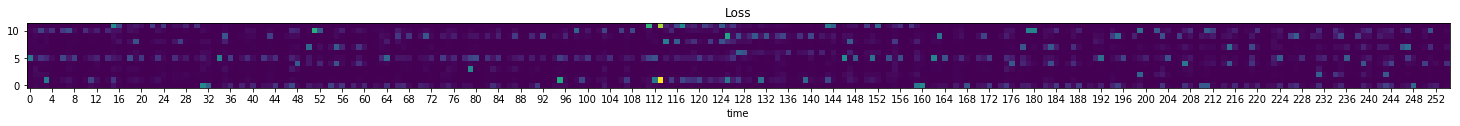

2.49908


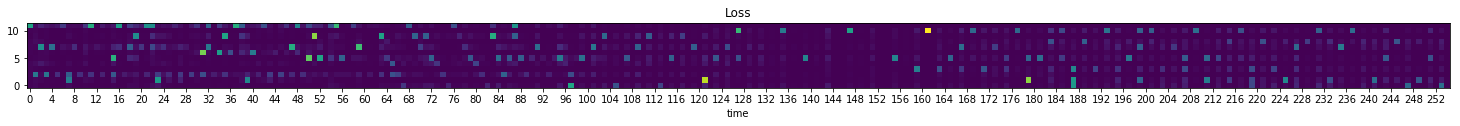

2.42486


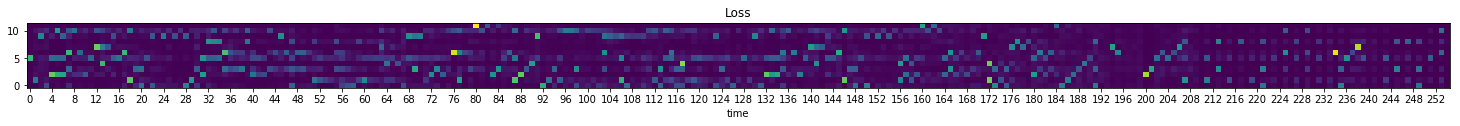

2.39319


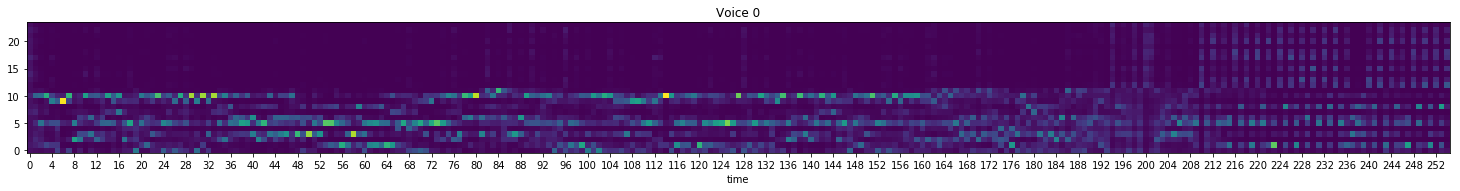

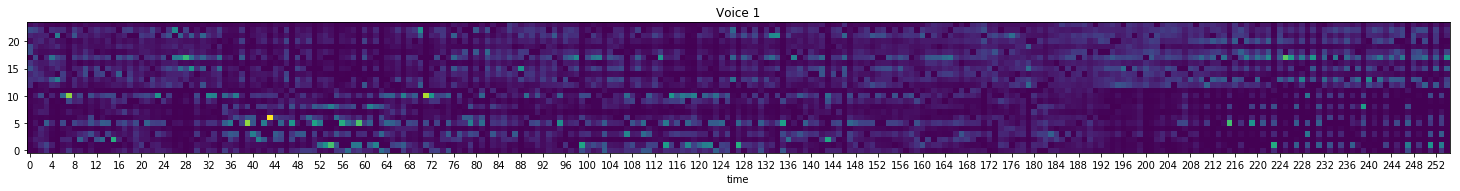

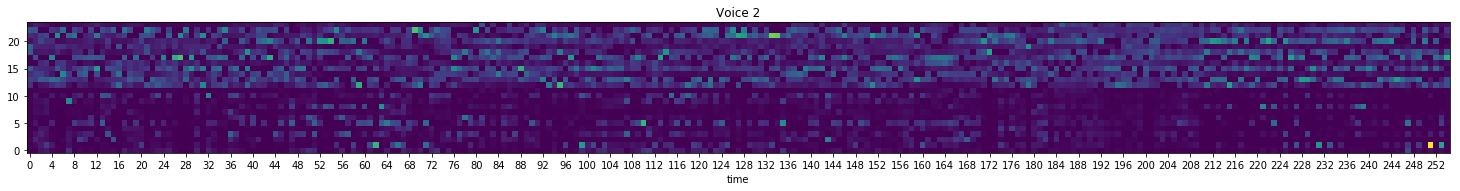

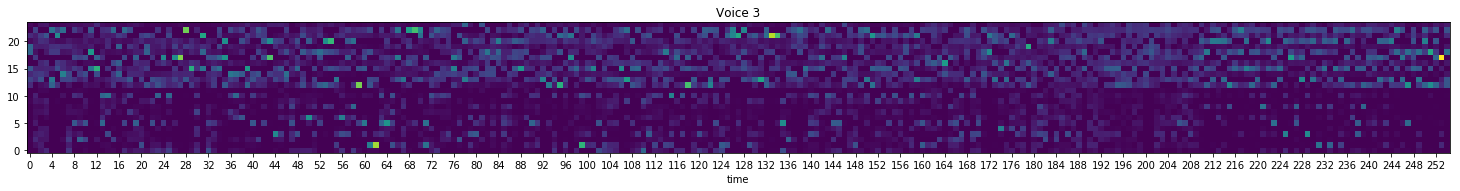

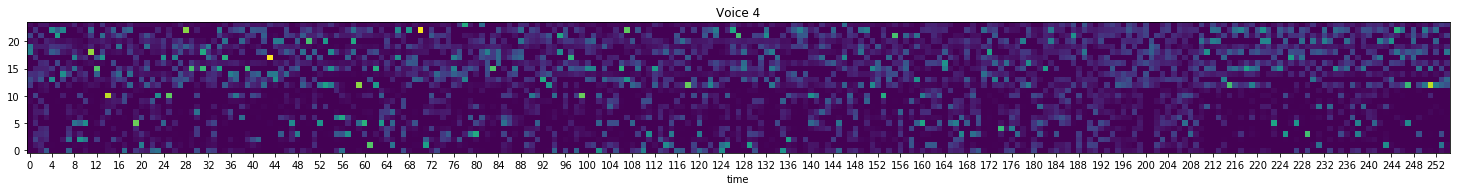

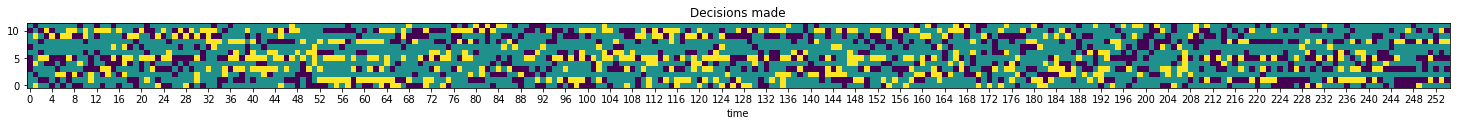

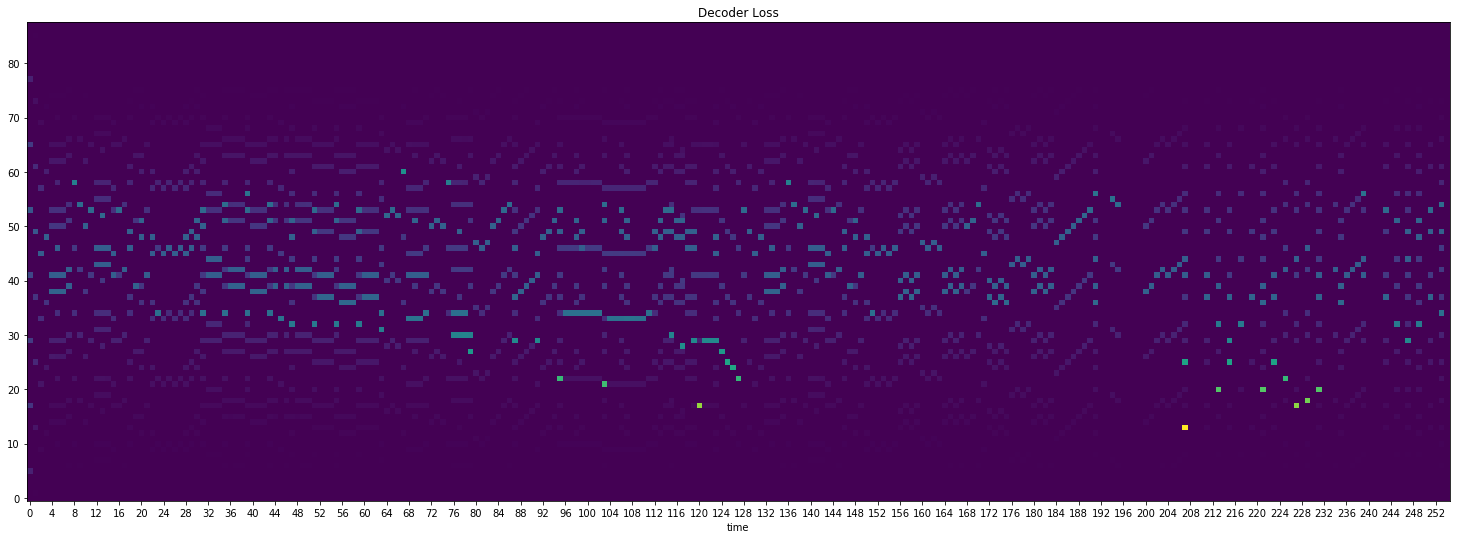

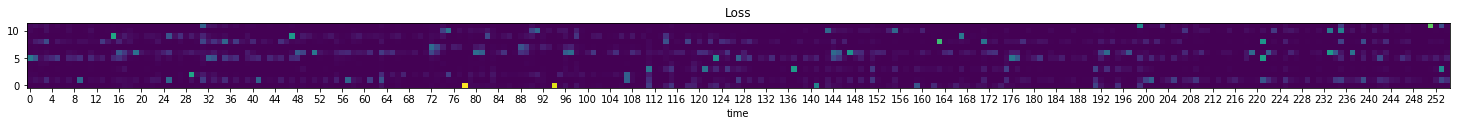

2.43955


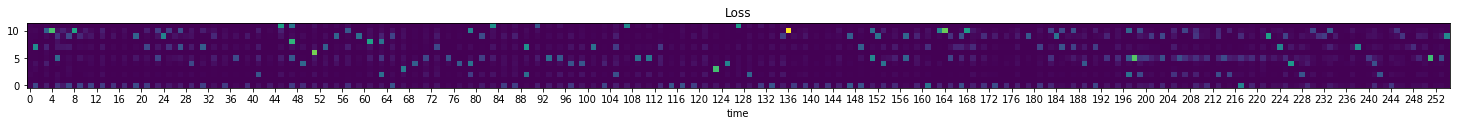

2.45157


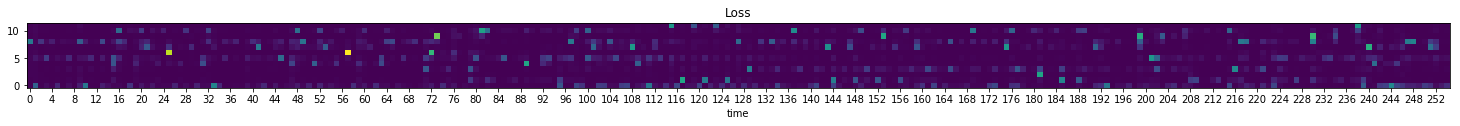

2.56065


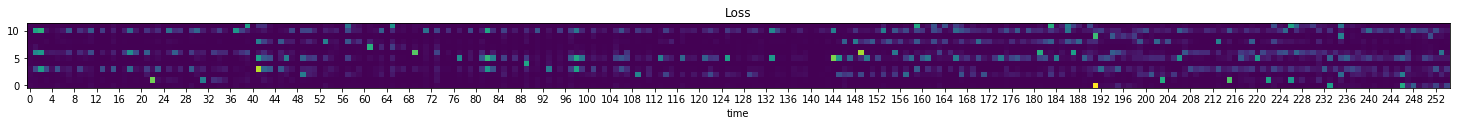

2.41702


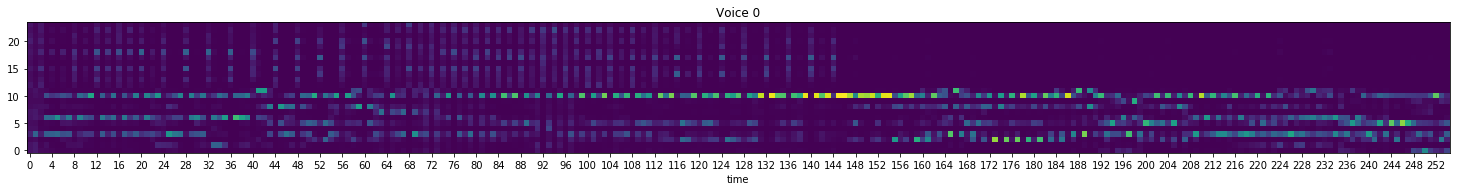

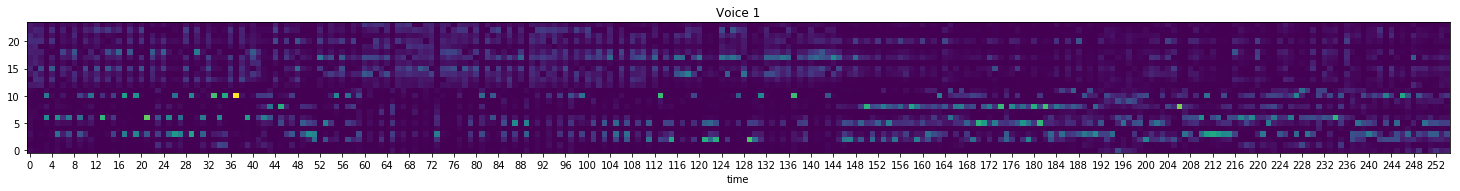

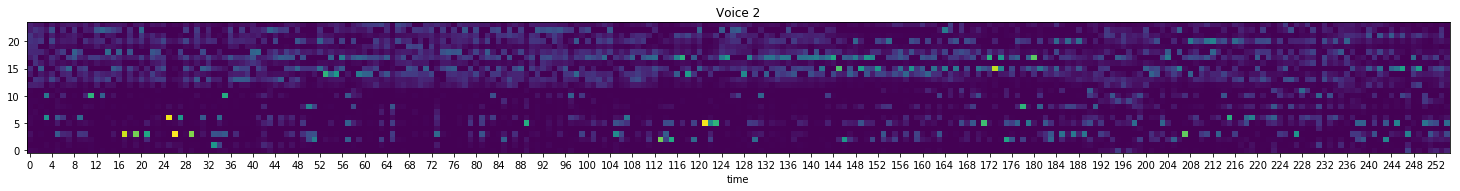

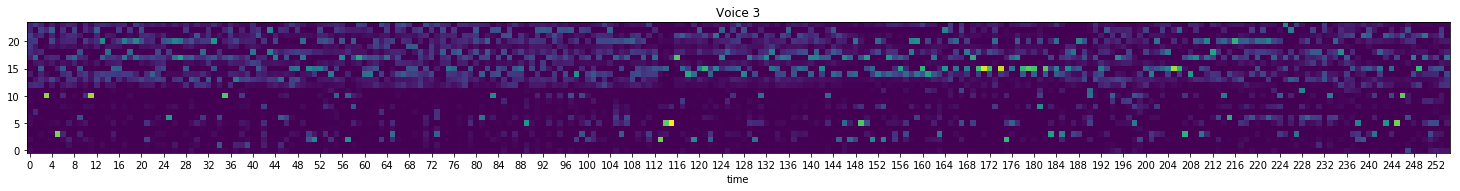

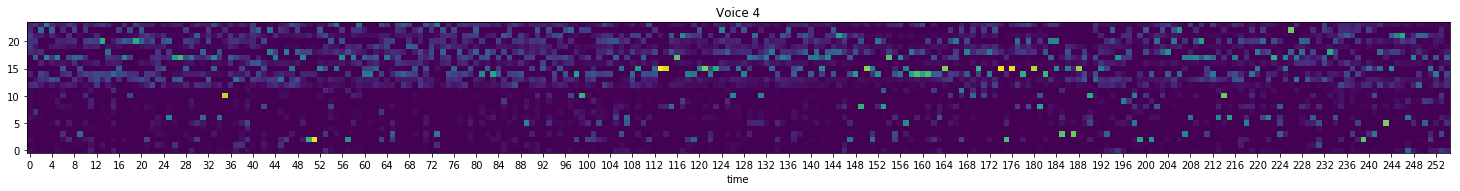

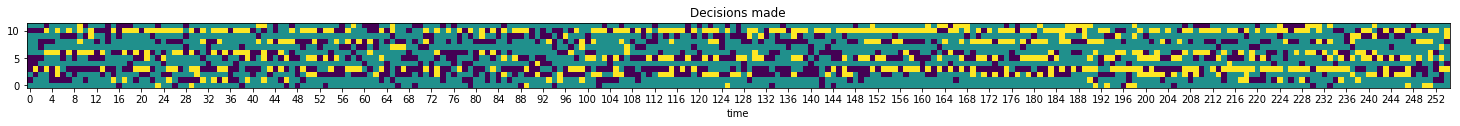

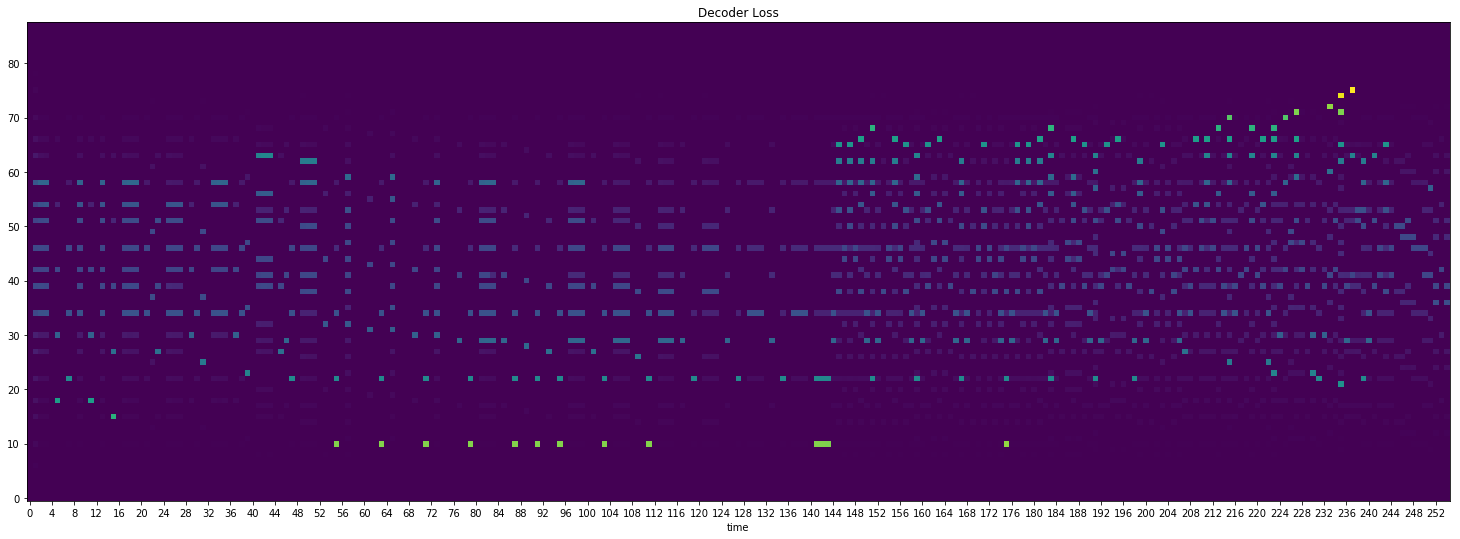

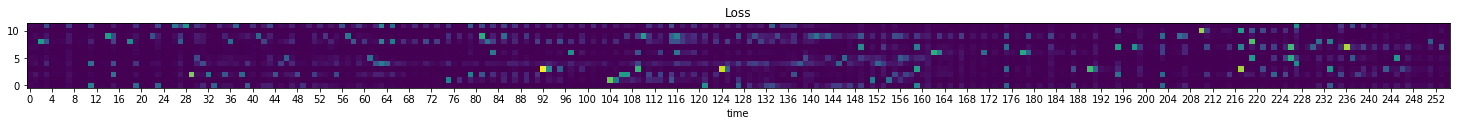

2.42402


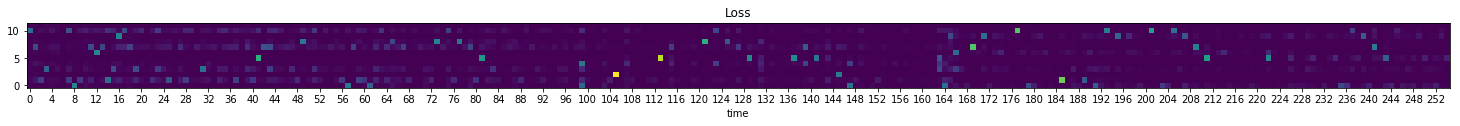

2.44976


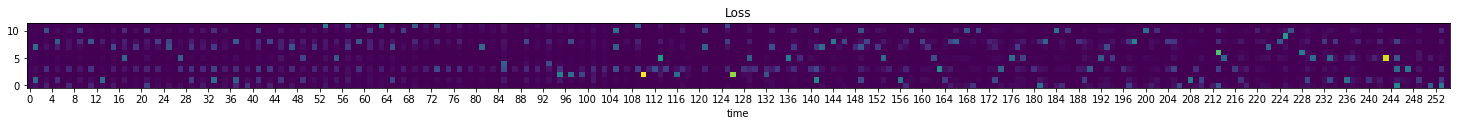

2.44821


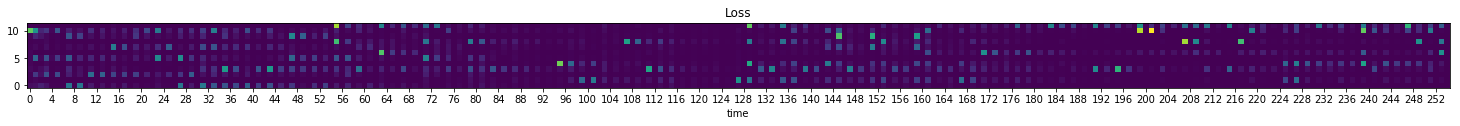

2.43191


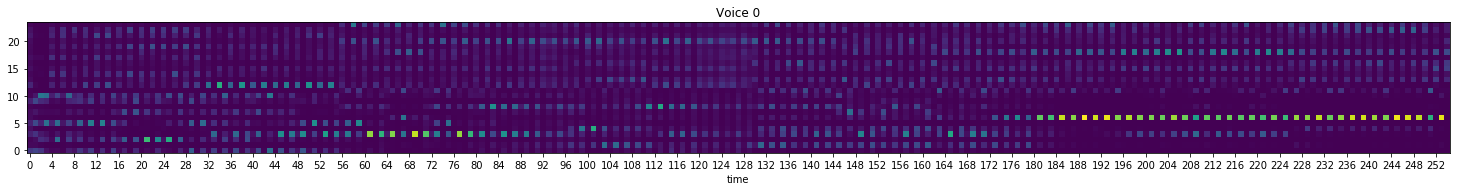

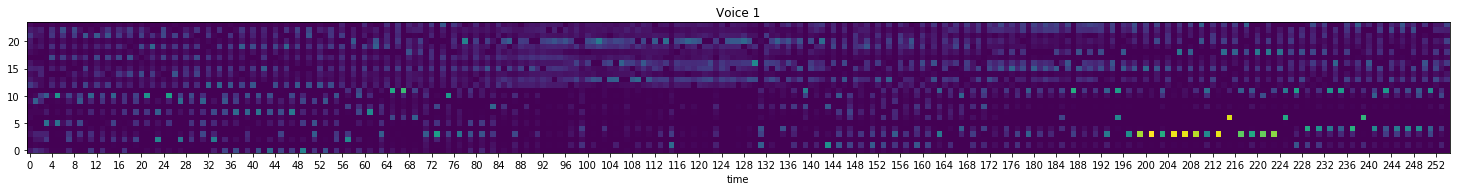

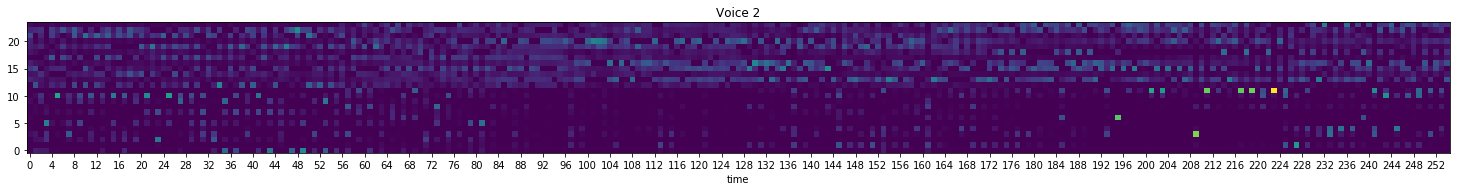

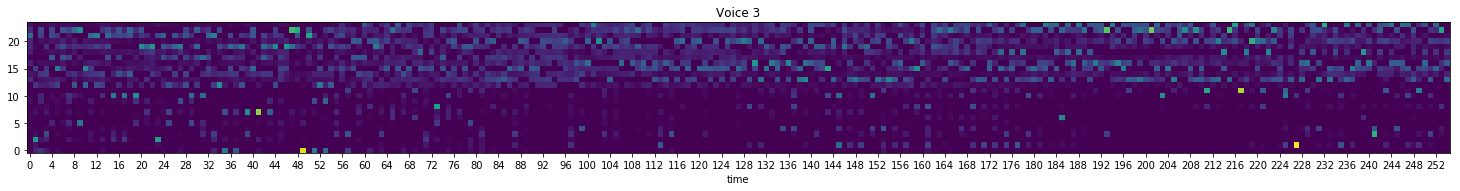

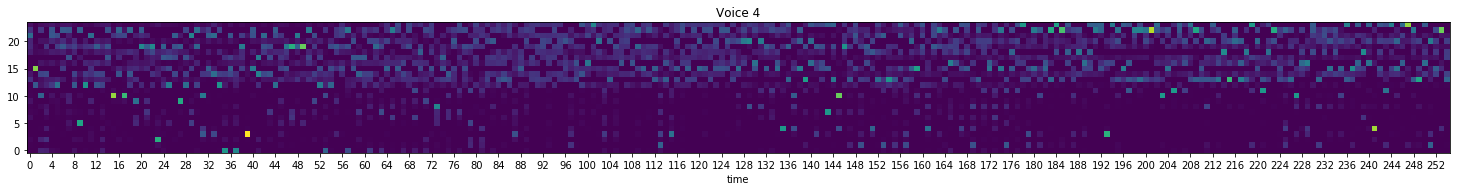

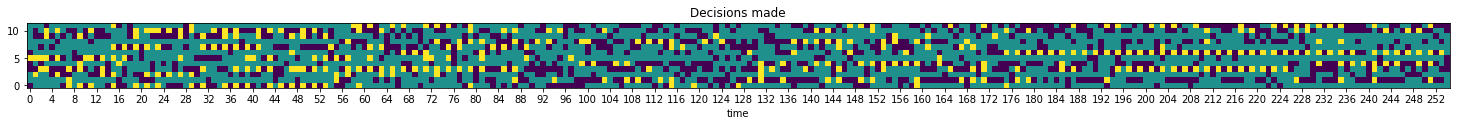

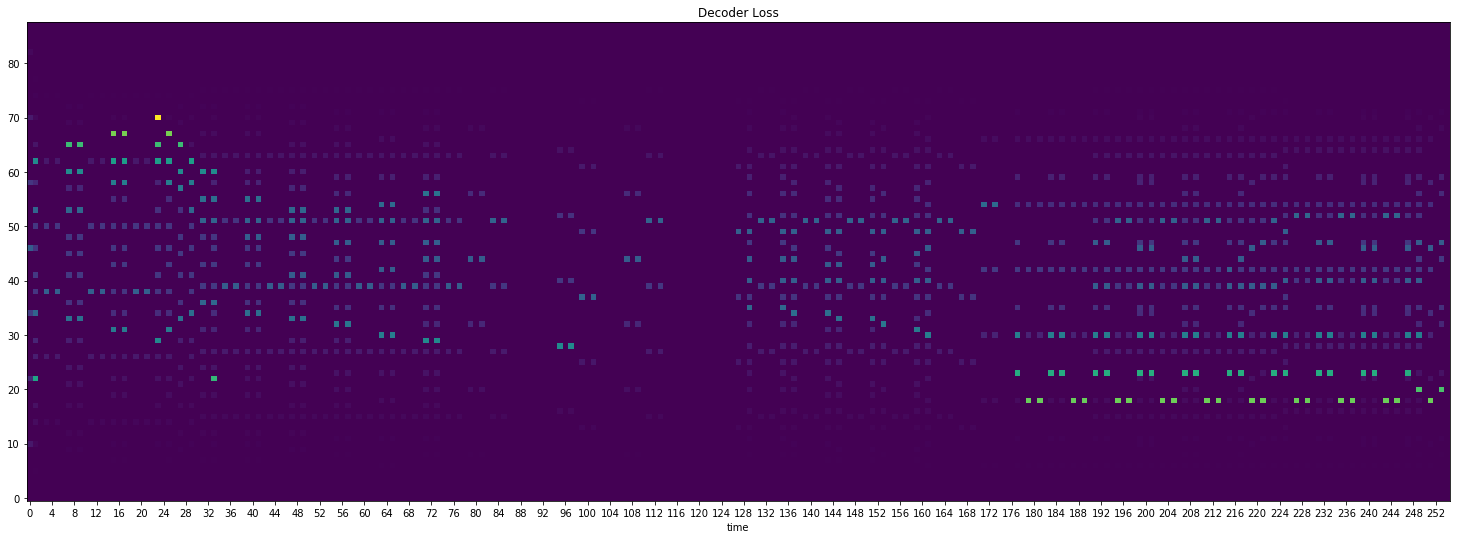

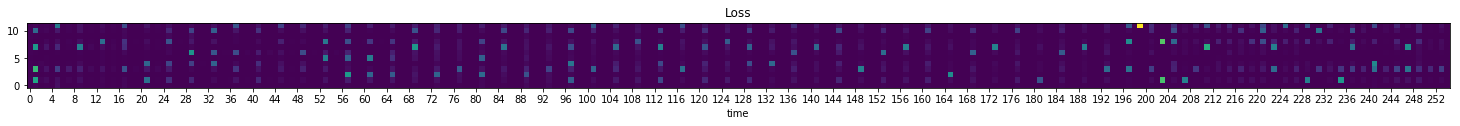

2.38939


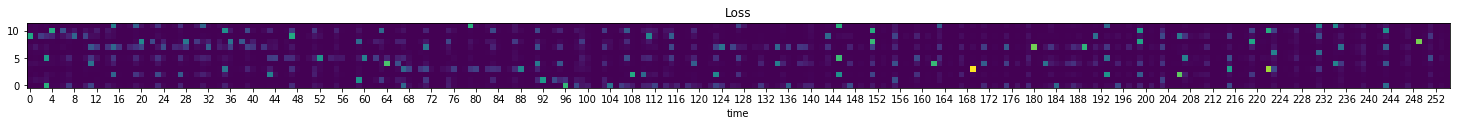

2.41729


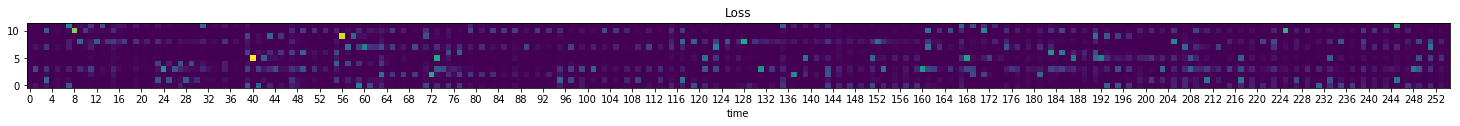

2.36781


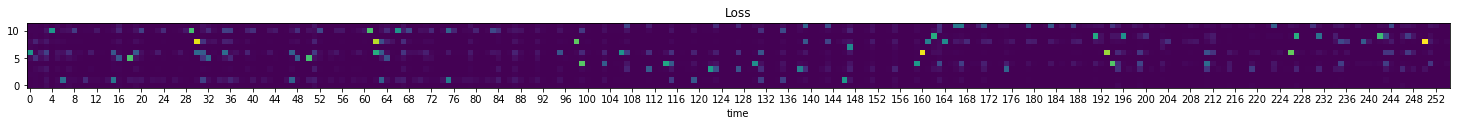

2.3883


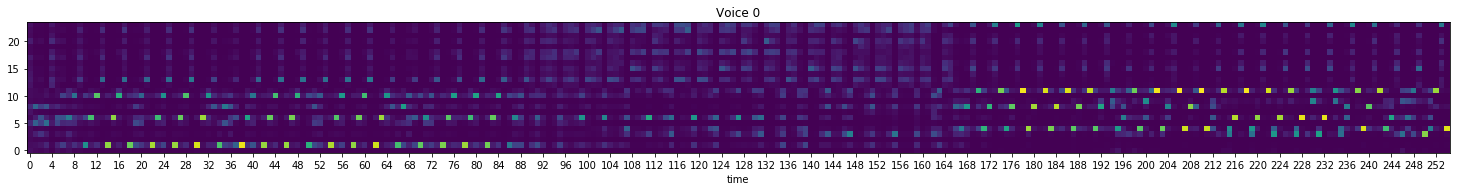

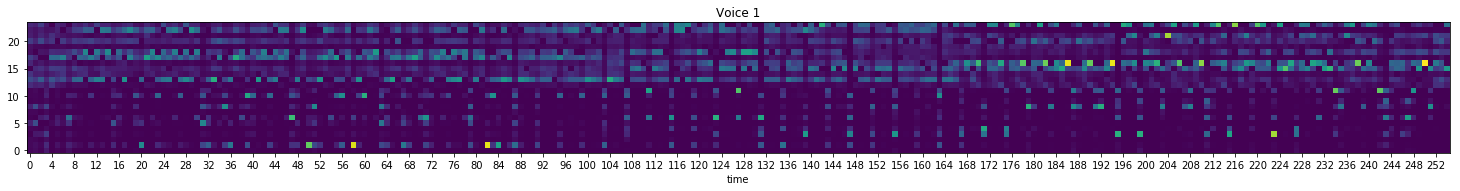

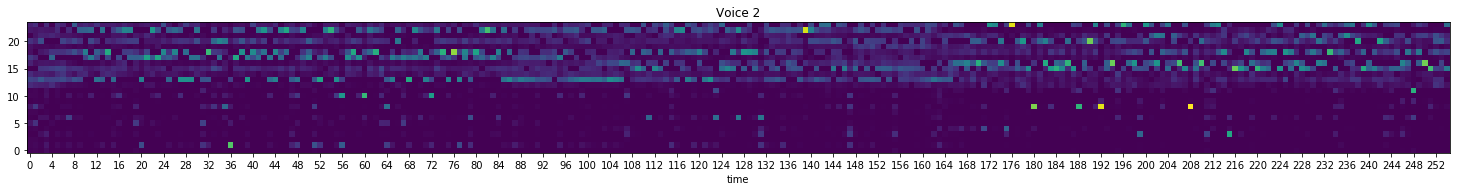

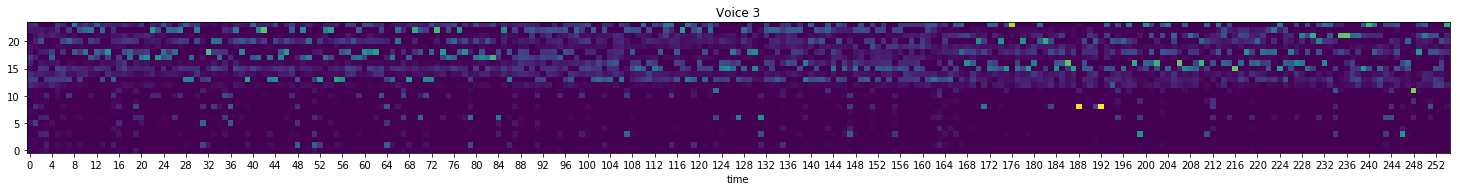

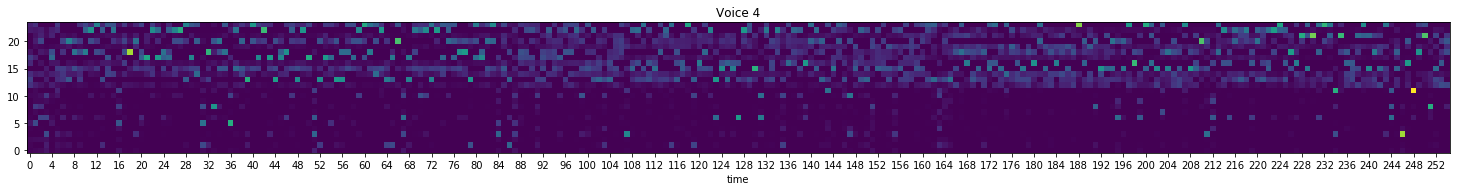

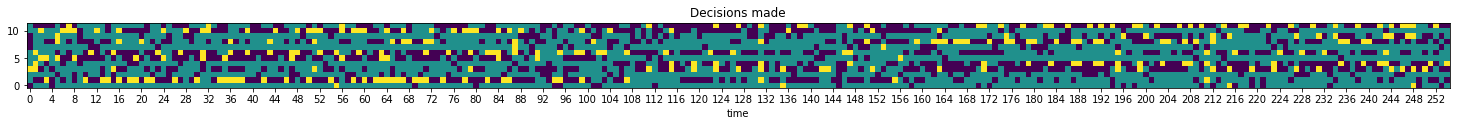

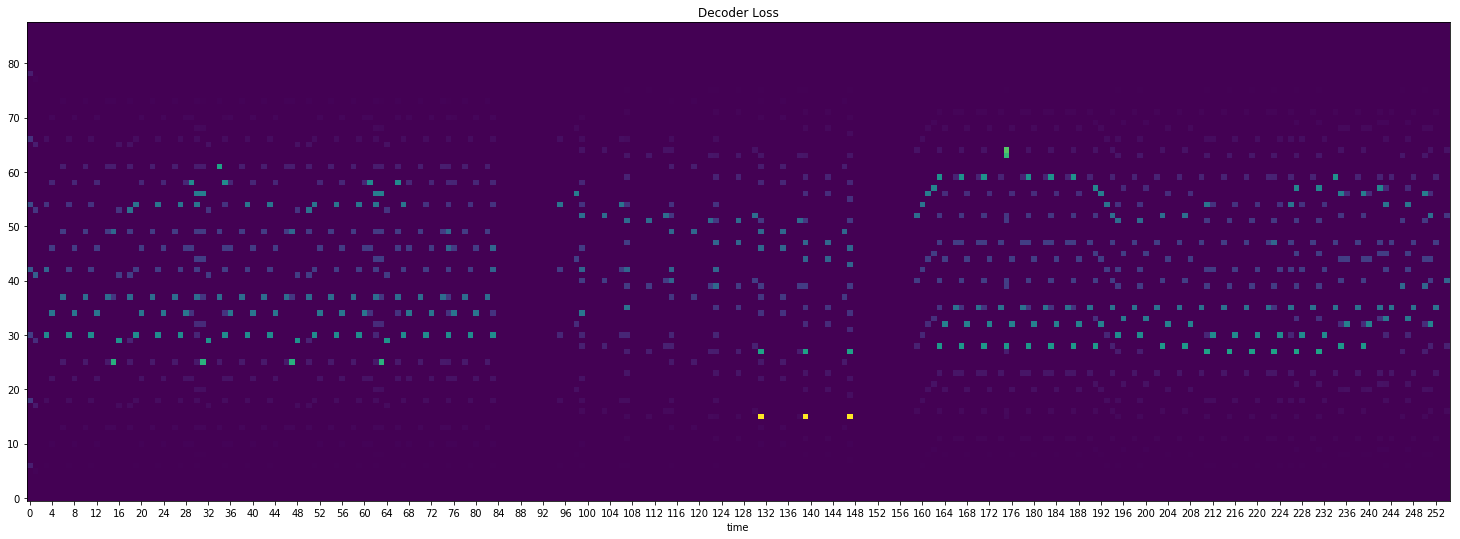

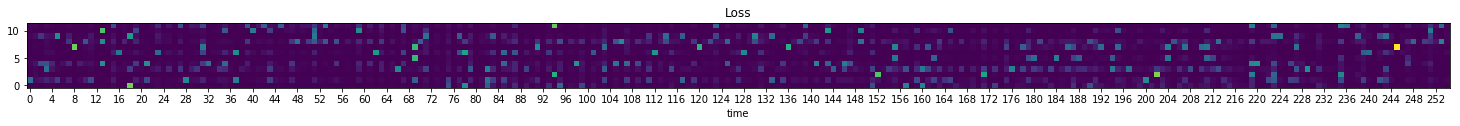

2.3316


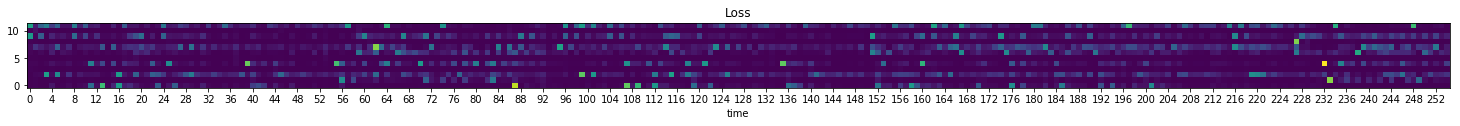

2.41861


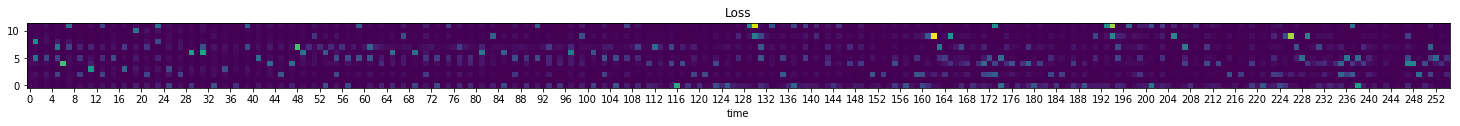

2.43279


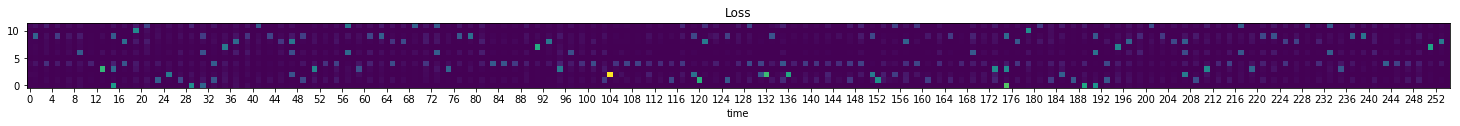

2.4165


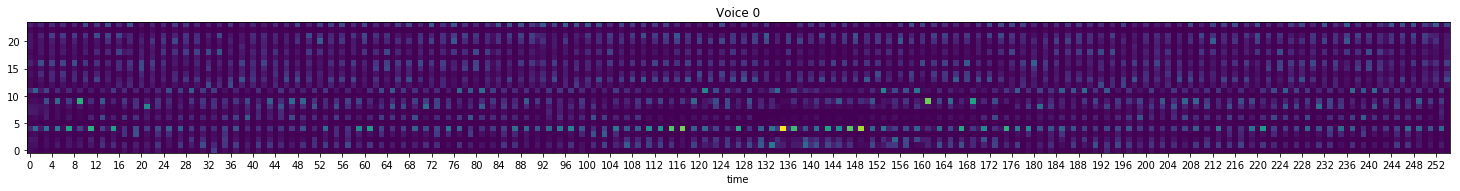

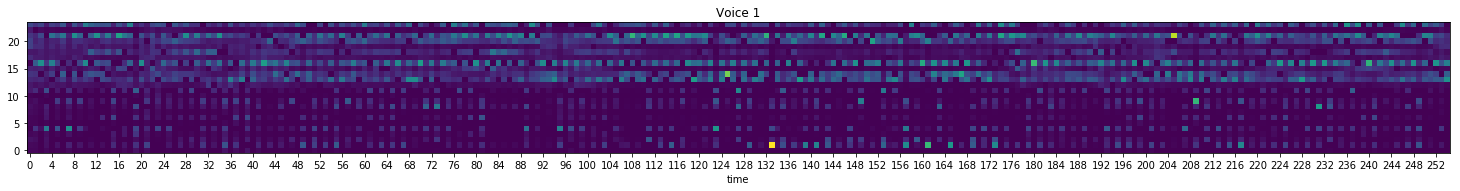

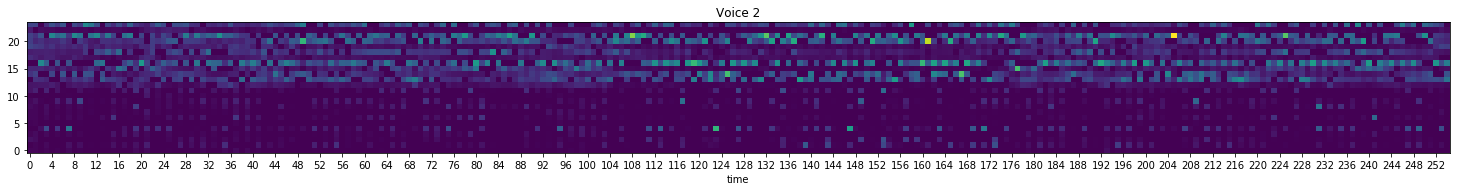

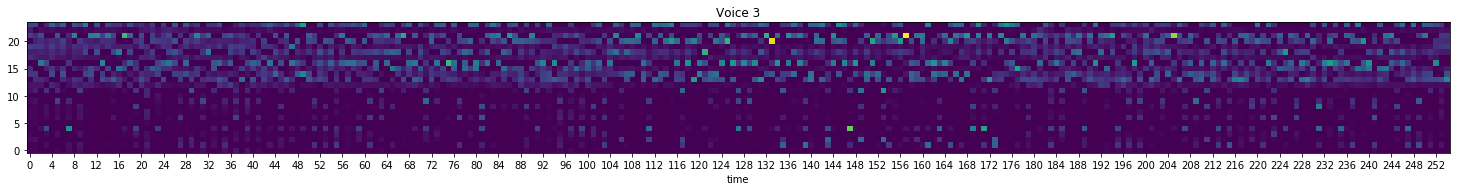

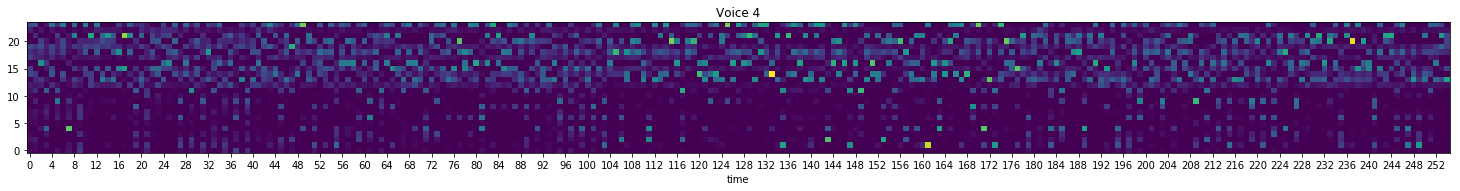

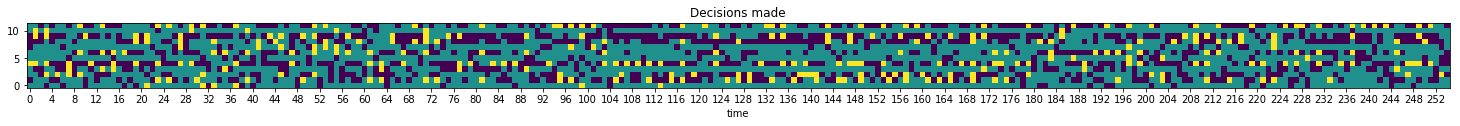

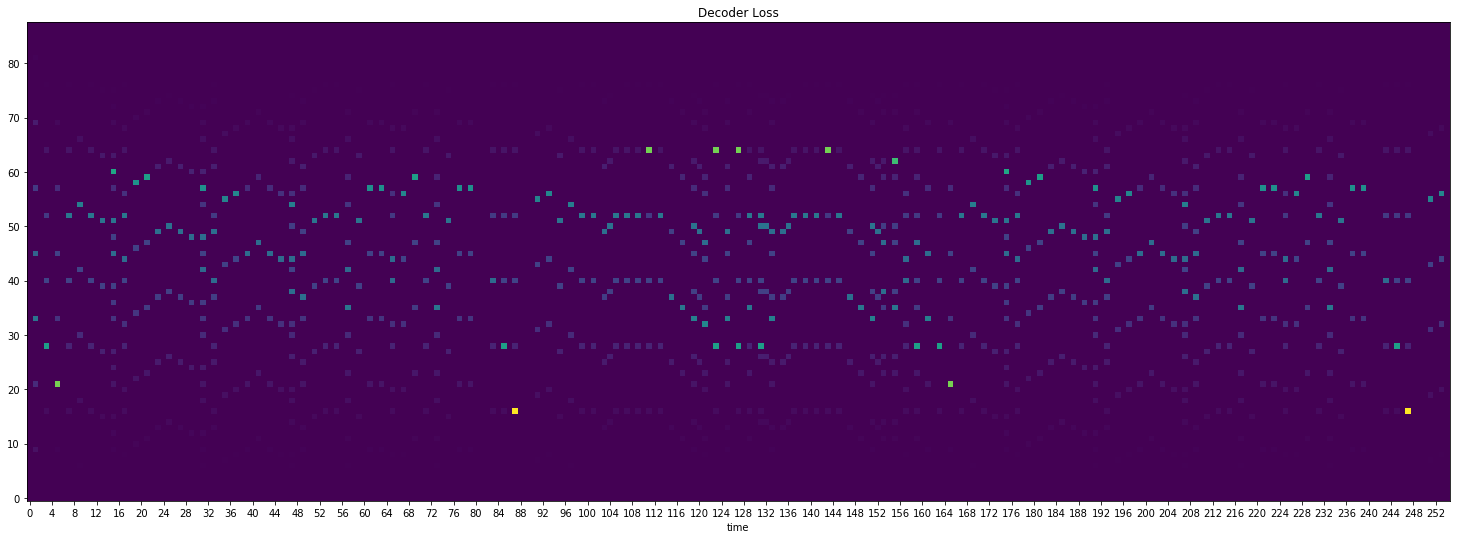

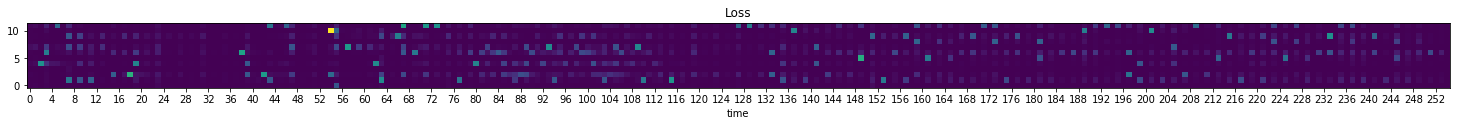

2.45825


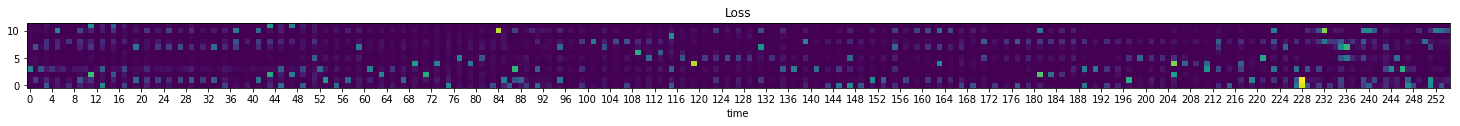

2.39492


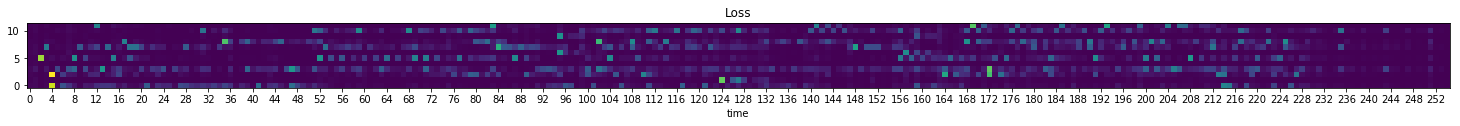

2.49445


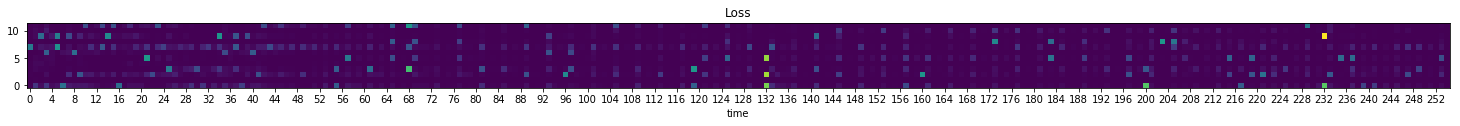

2.36252


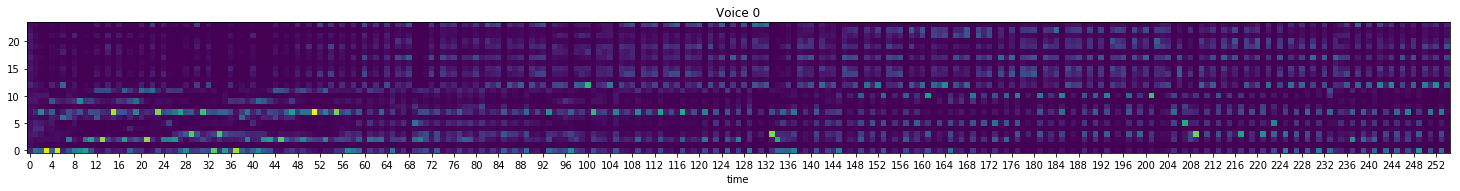

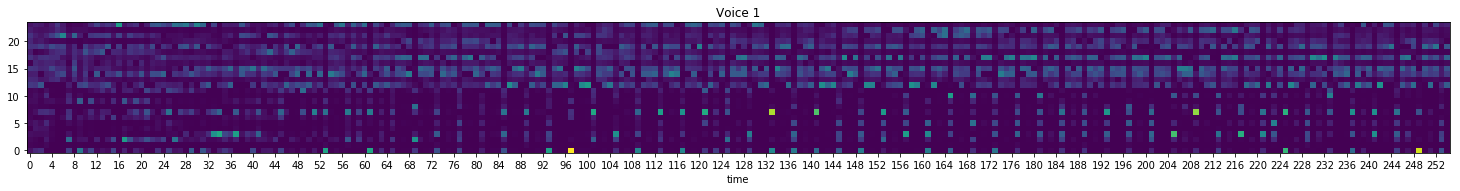

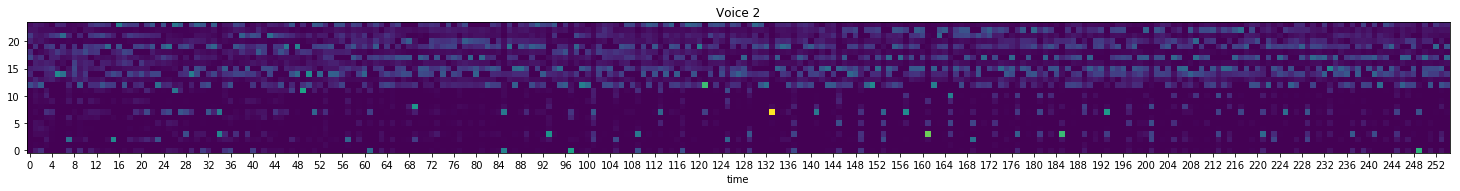

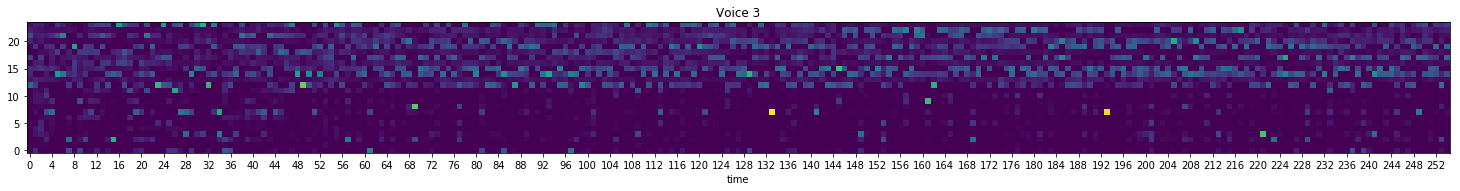

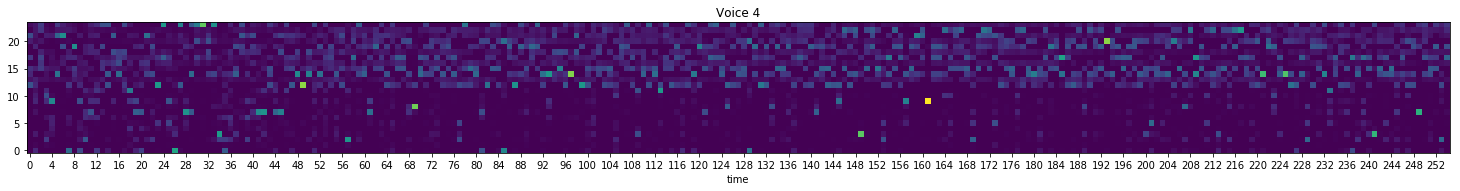

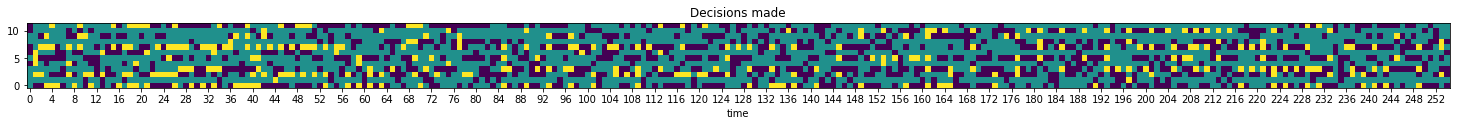

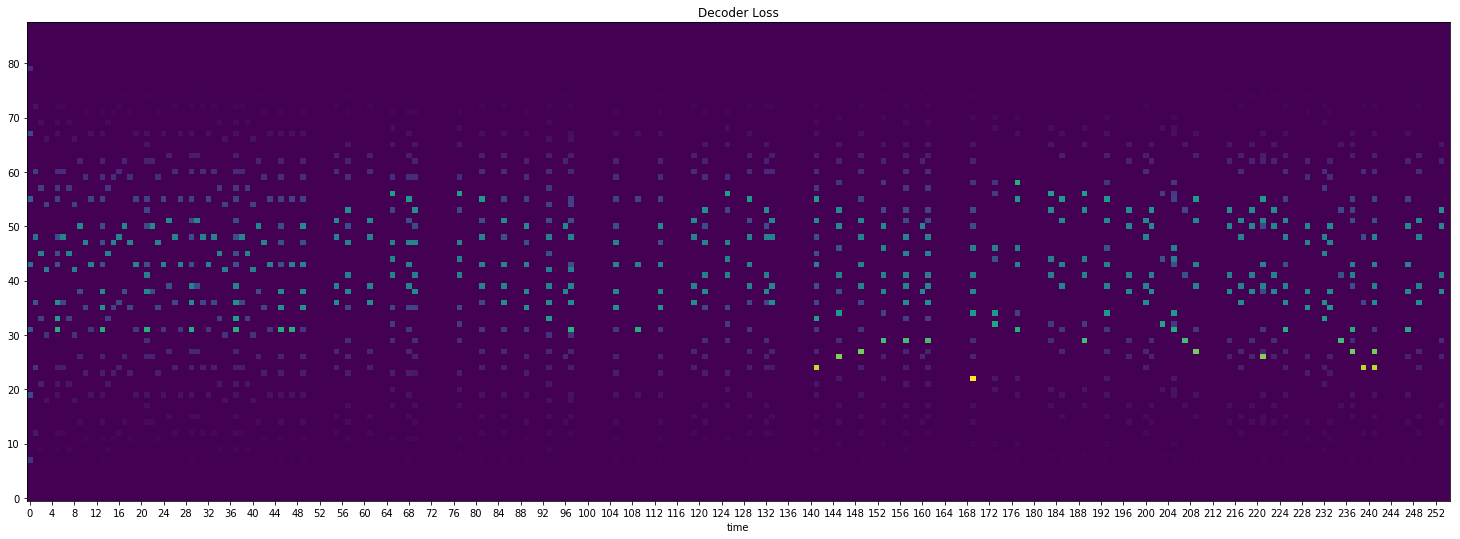

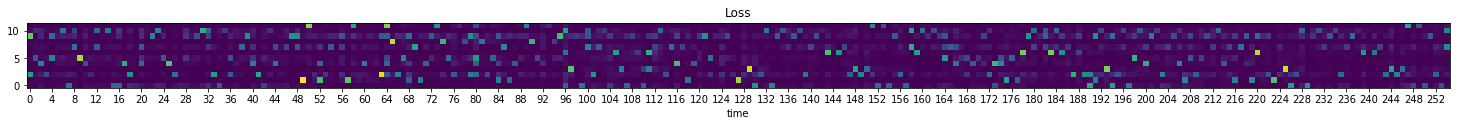

2.369


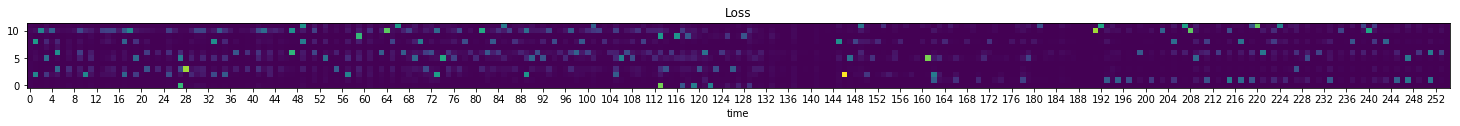

2.32373


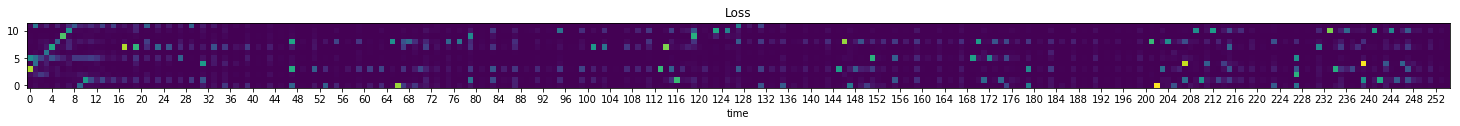

2.35312


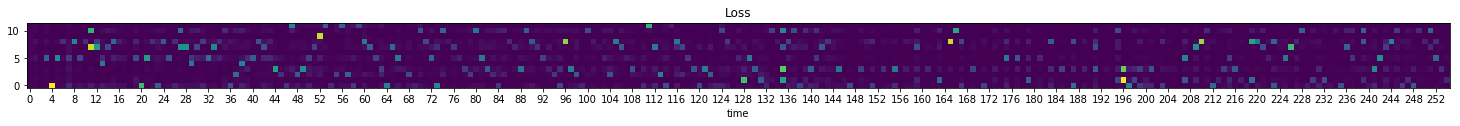

2.37526


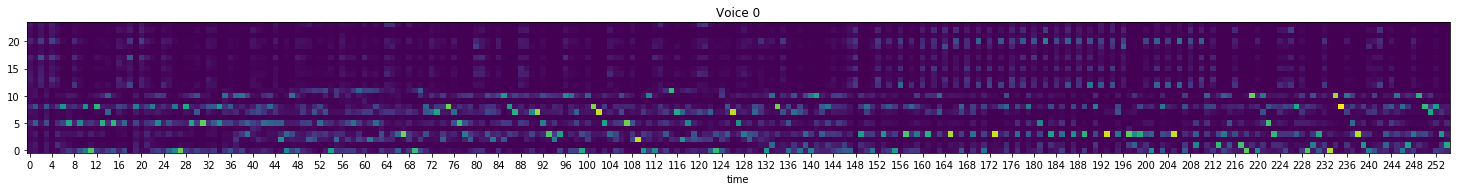

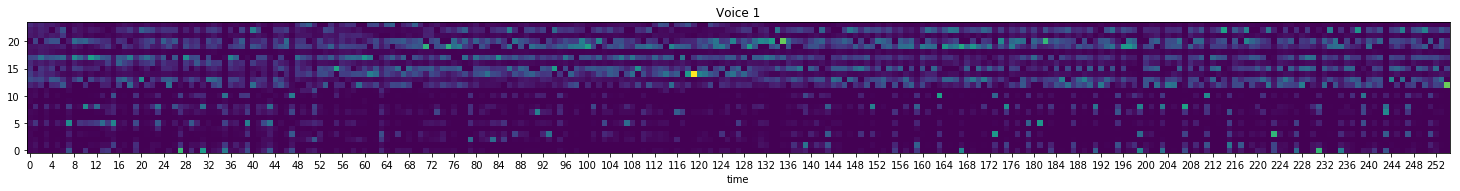

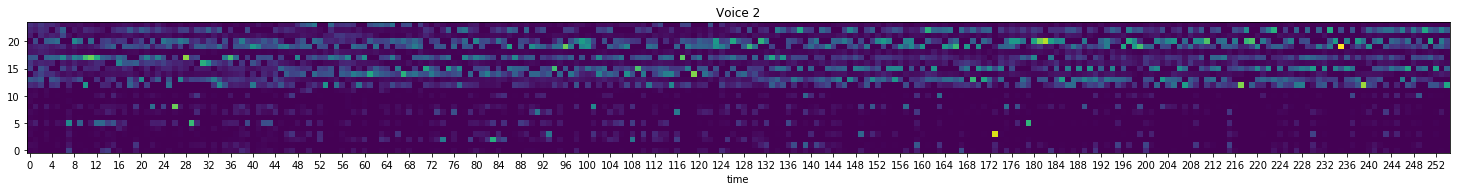

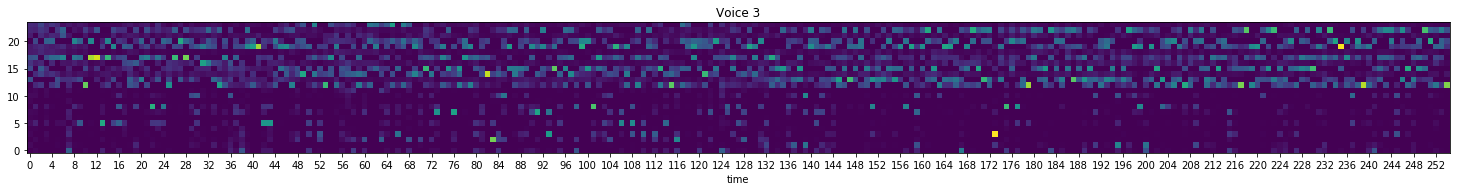

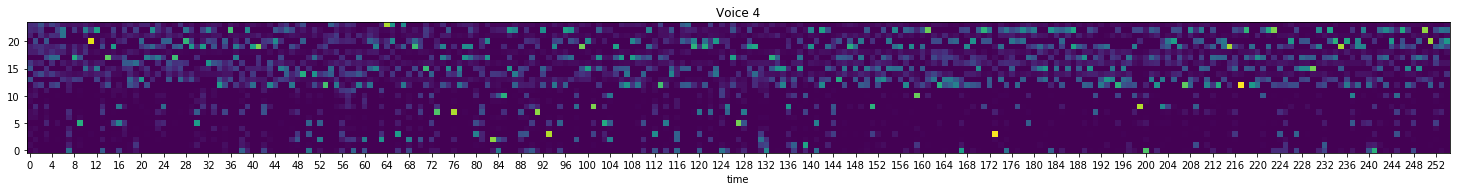

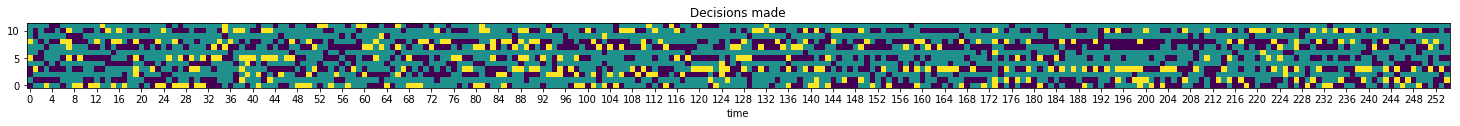

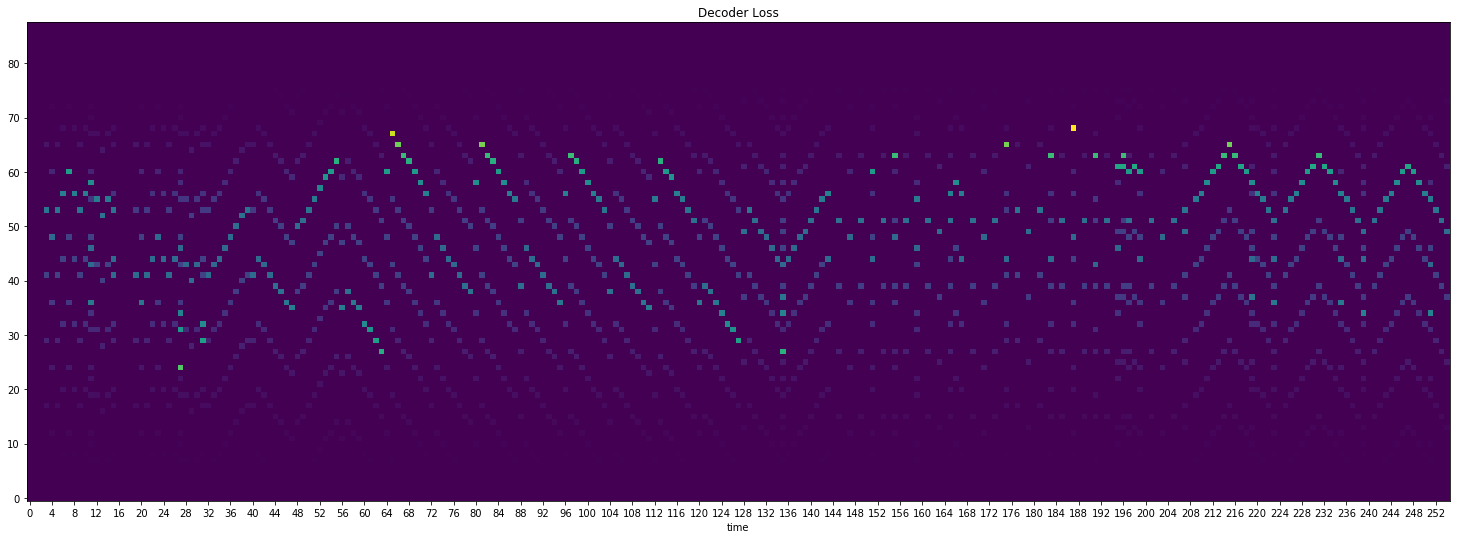

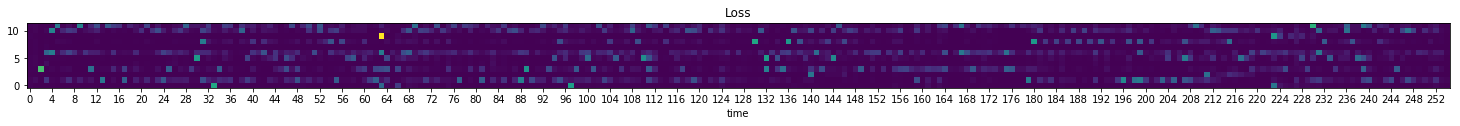

2.32262


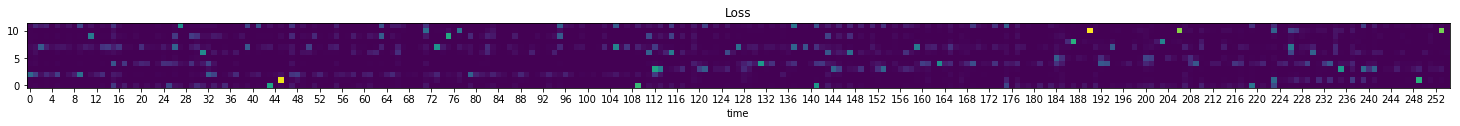

2.34228


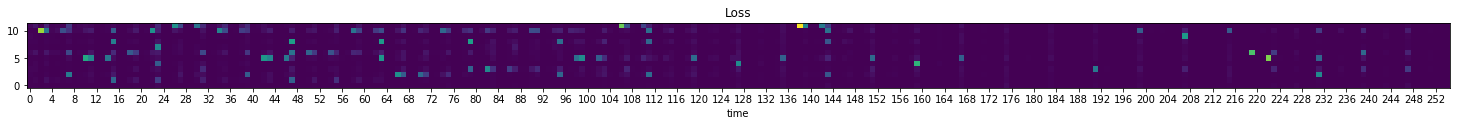

2.33832


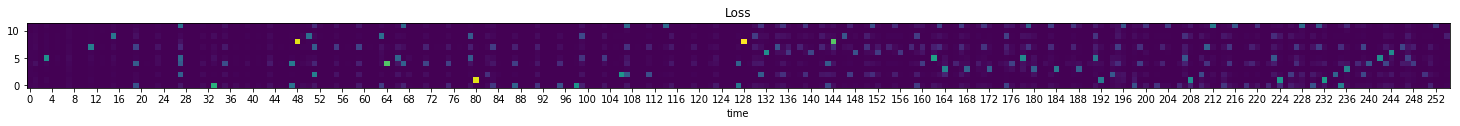

2.4291


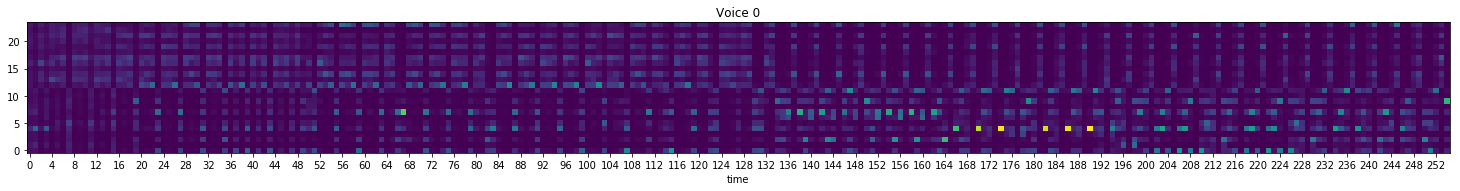

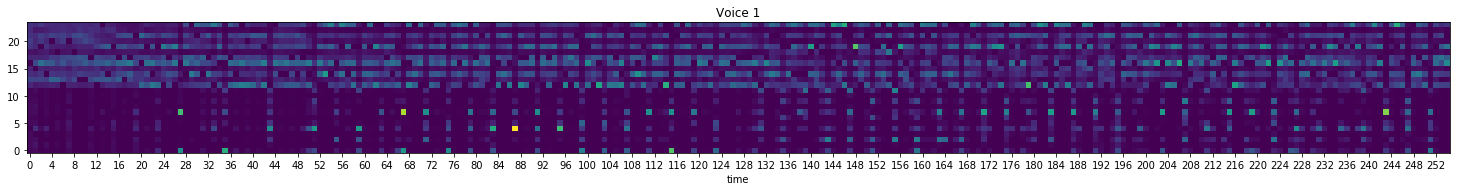

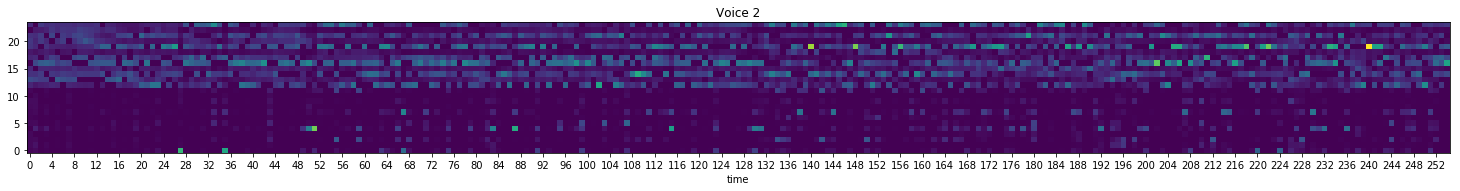

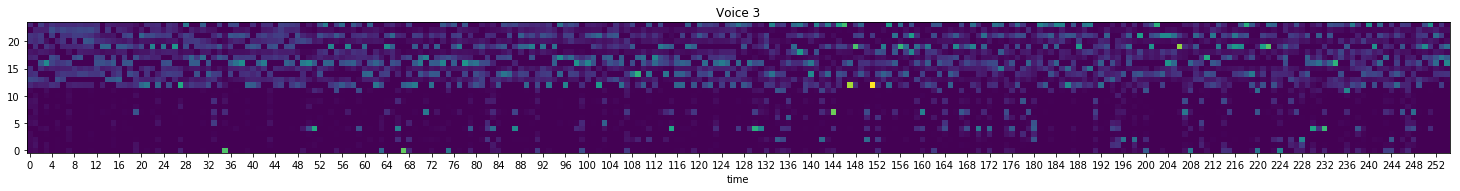

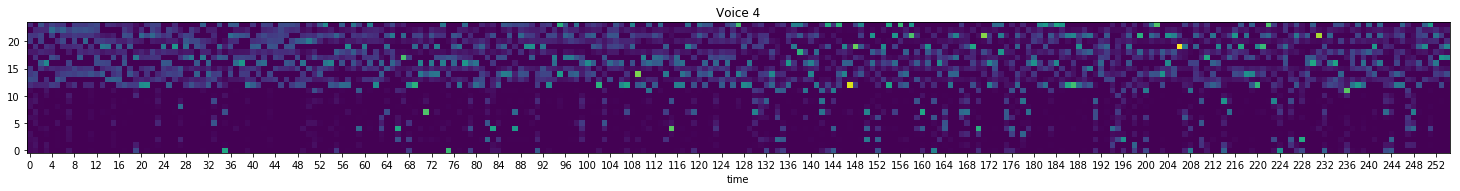

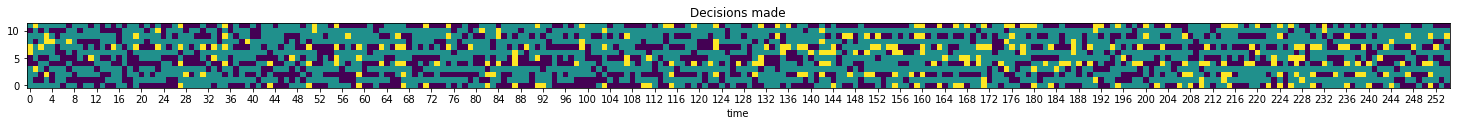

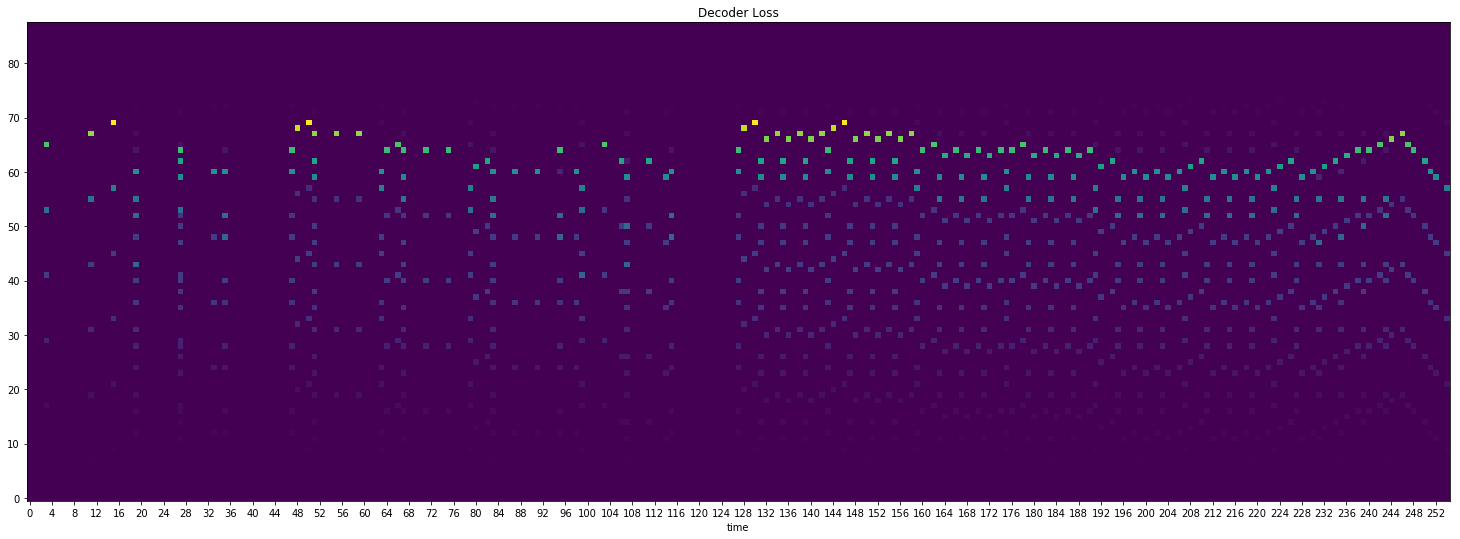

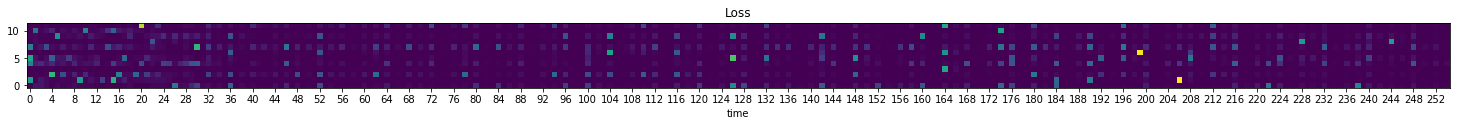

2.28371


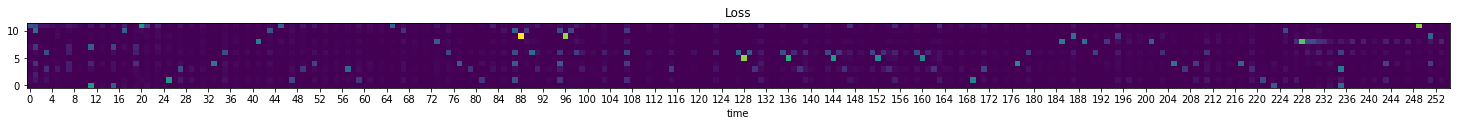

2.3263


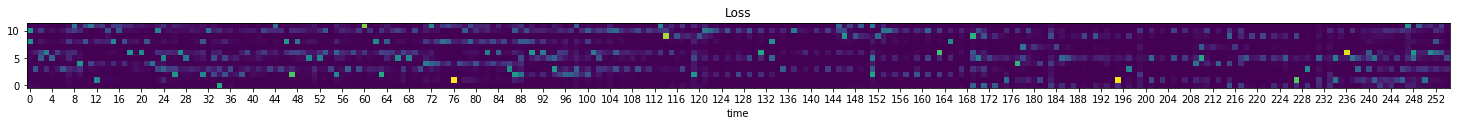

2.38569


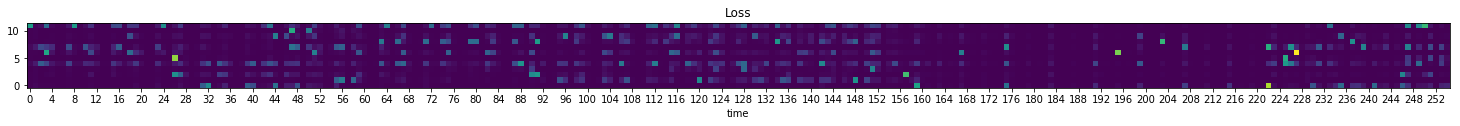

2.35525


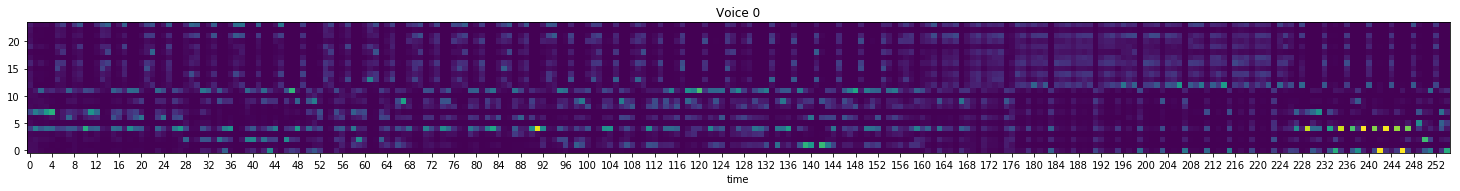

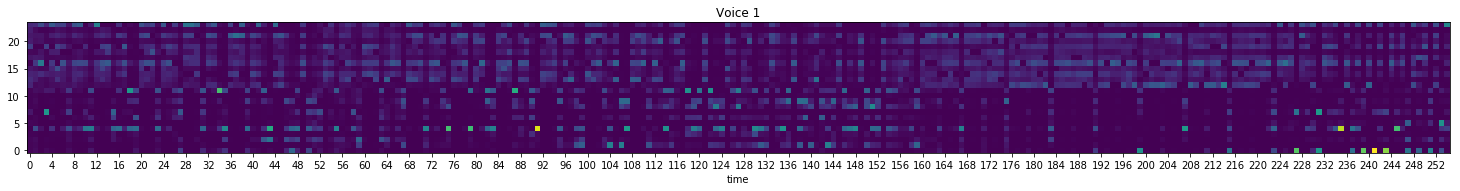

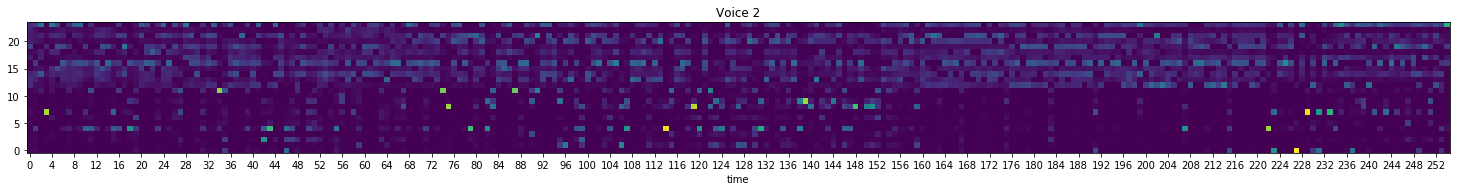

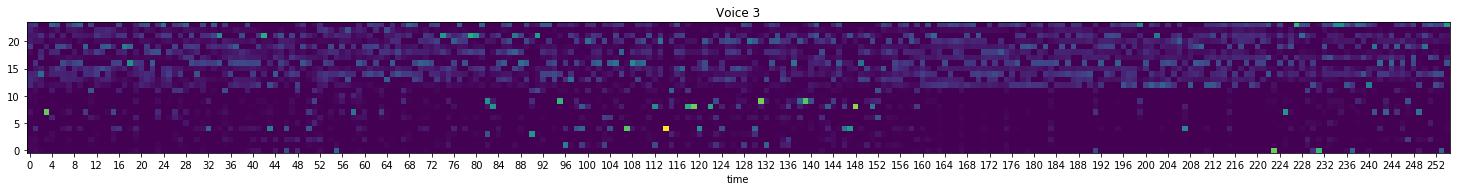

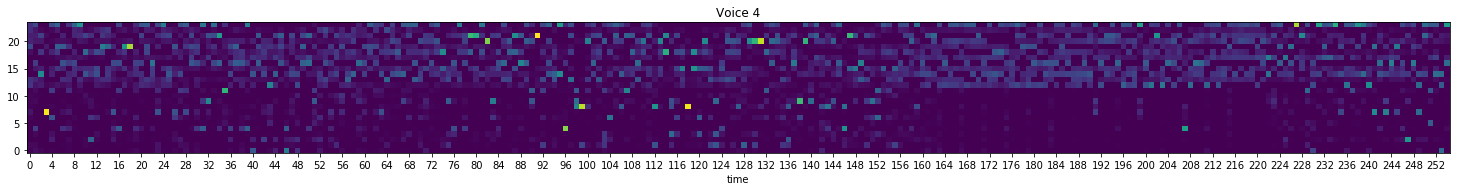

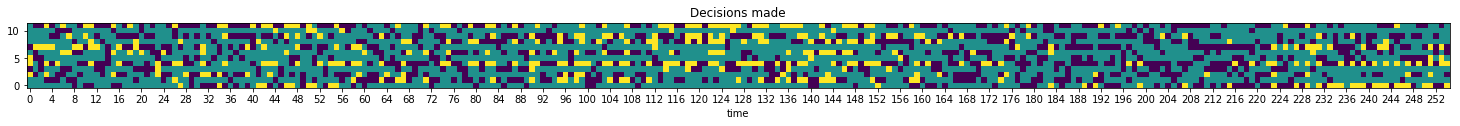

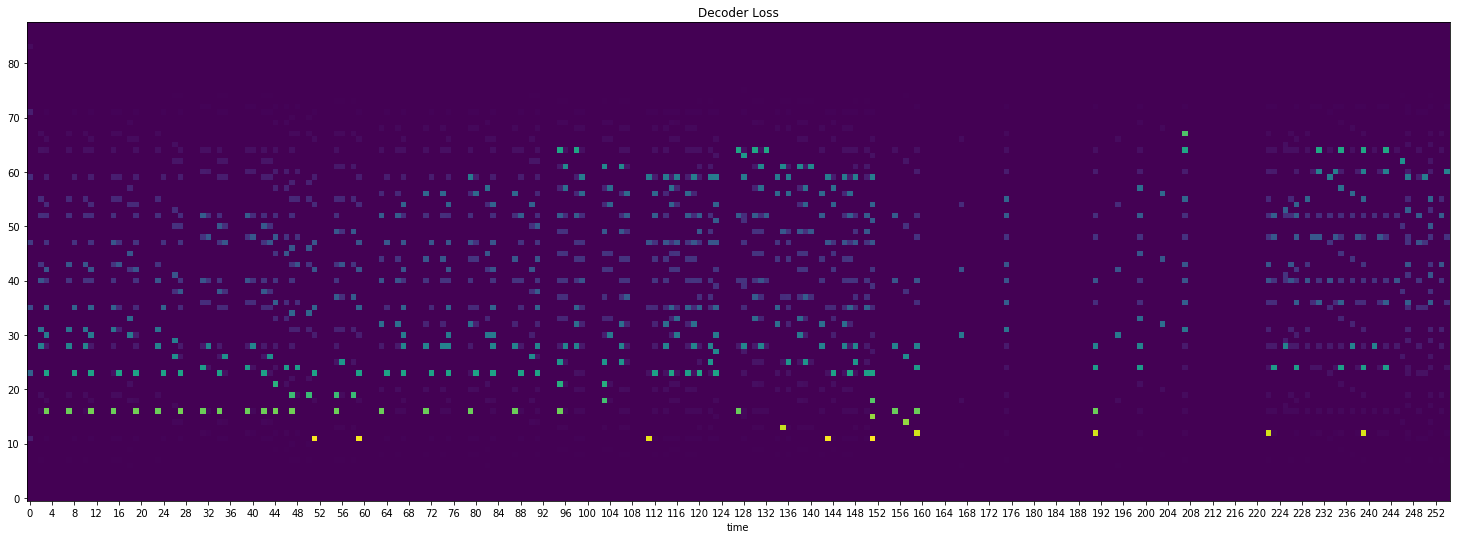

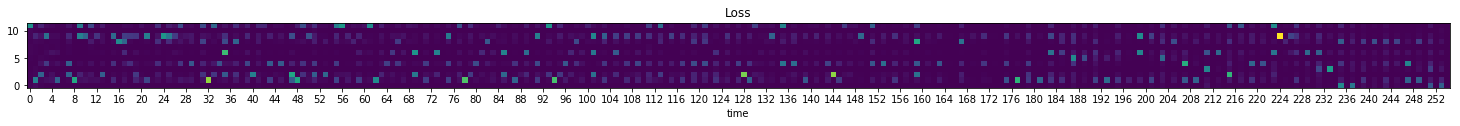

2.36238


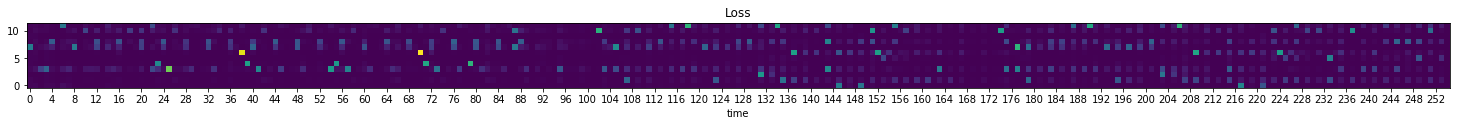

2.31237


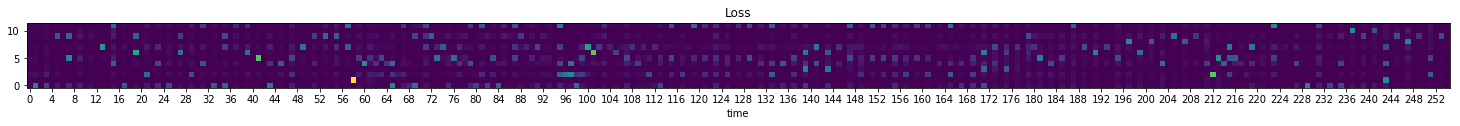

2.45843


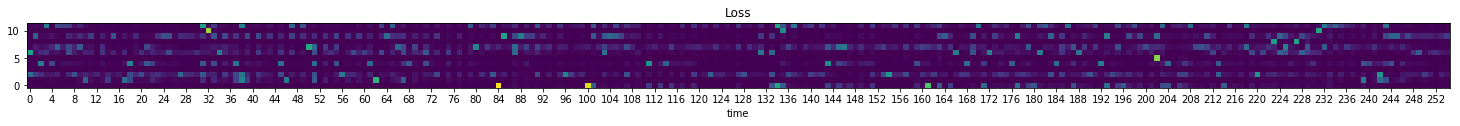

2.31647


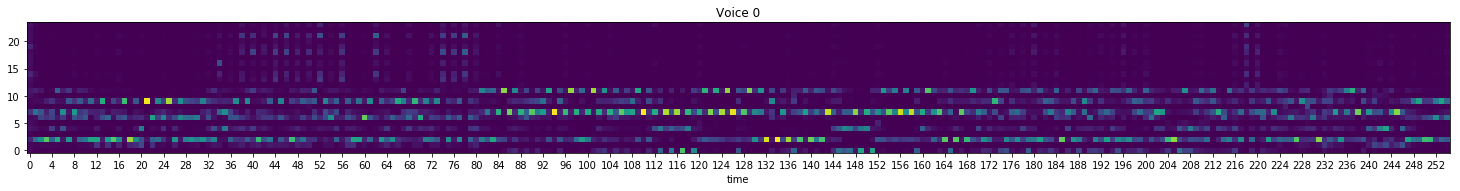

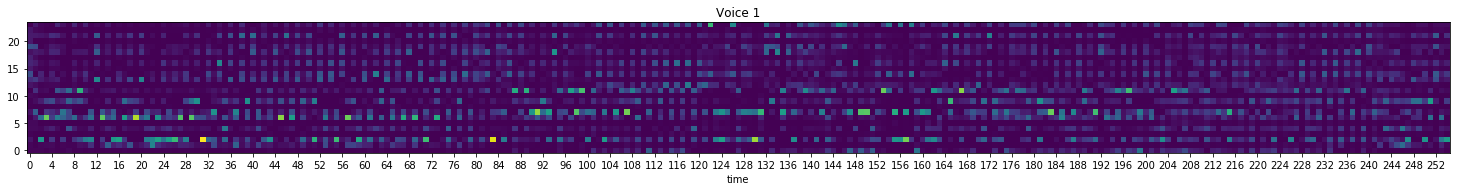

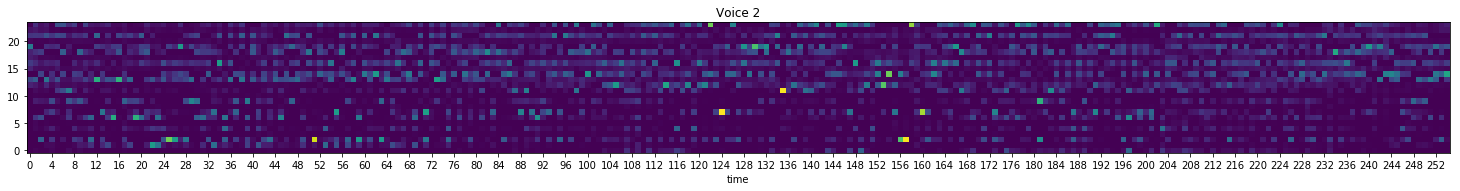

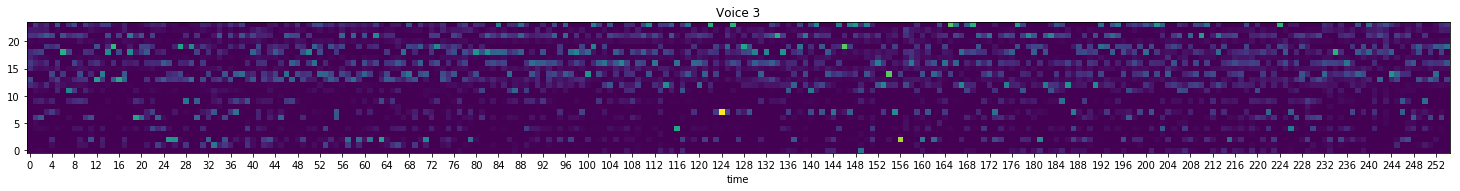

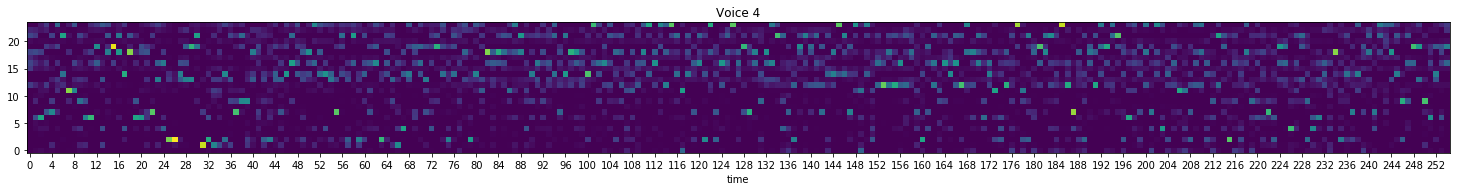

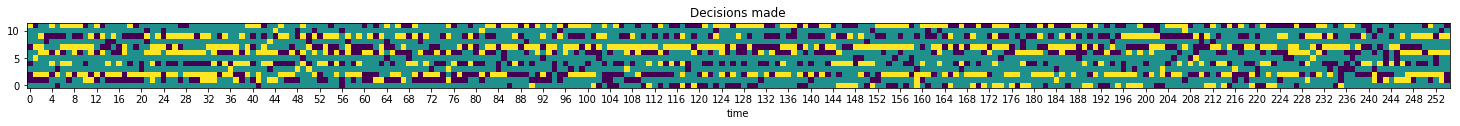

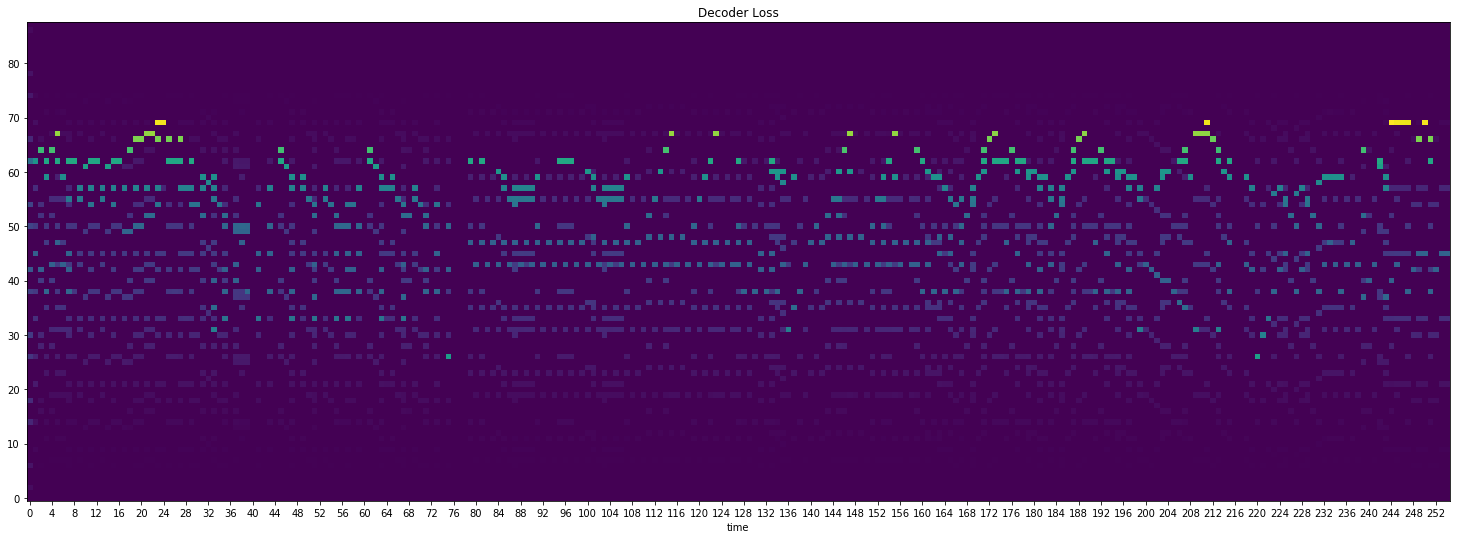

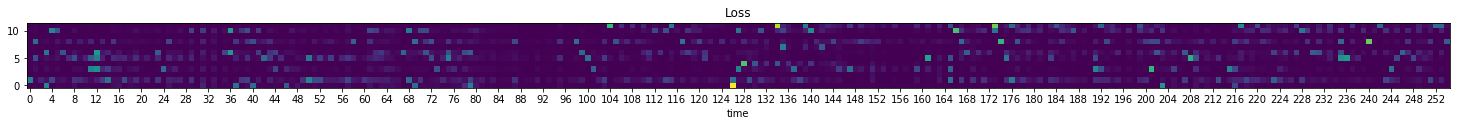

2.31005


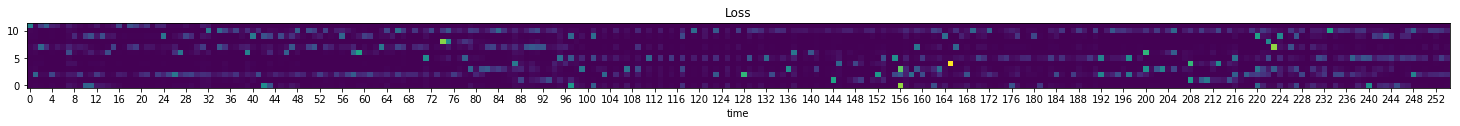

2.48544


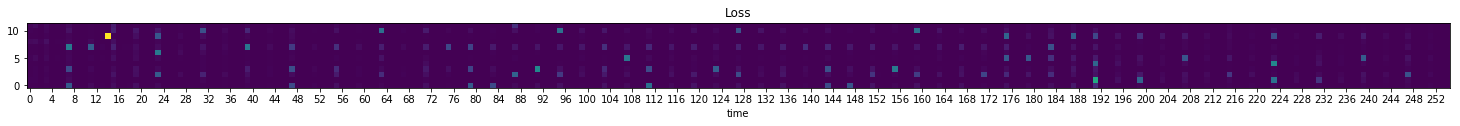

2.40002


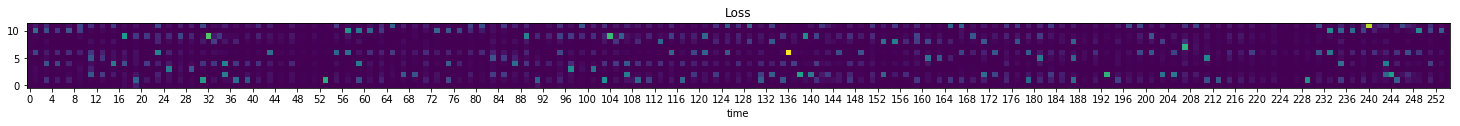

2.35204


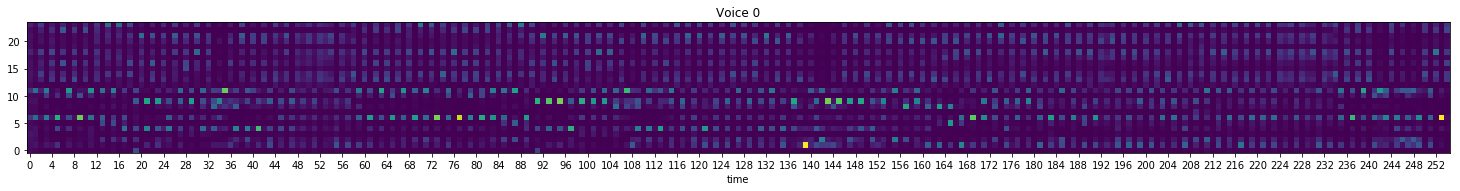

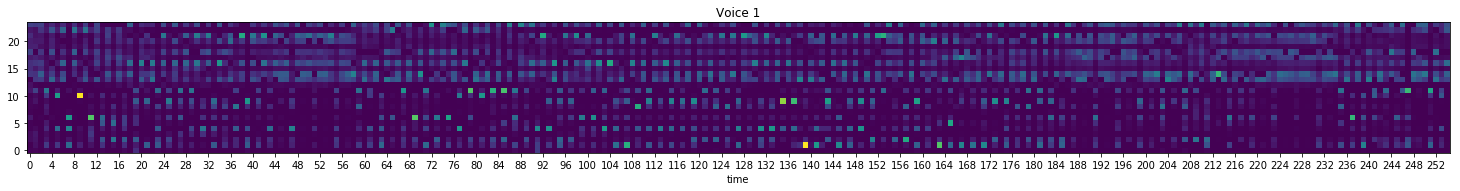

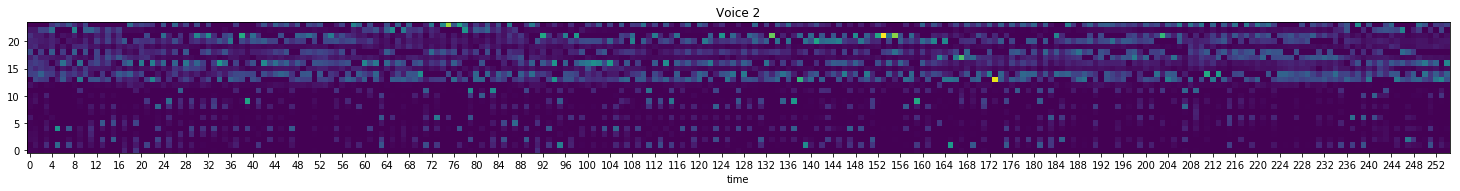

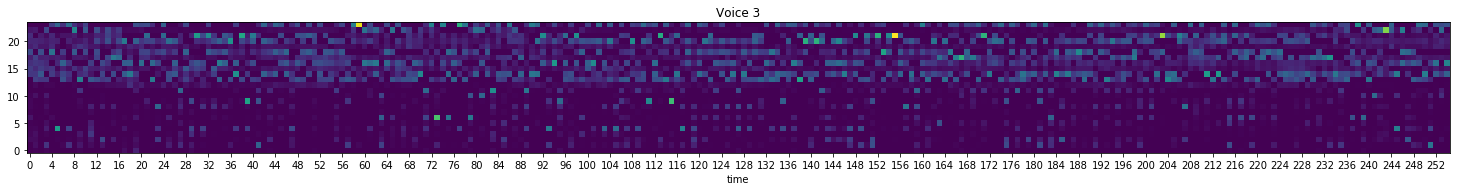

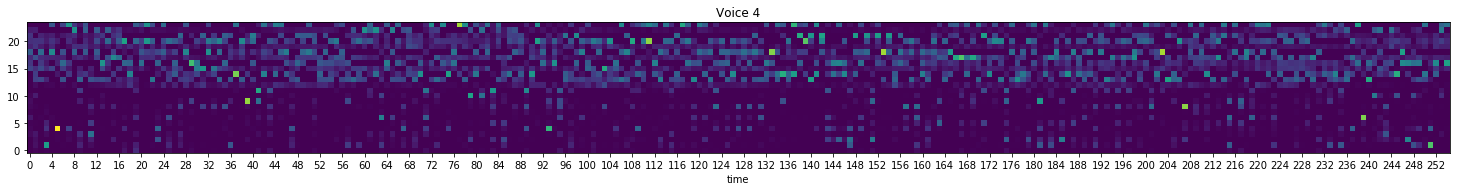

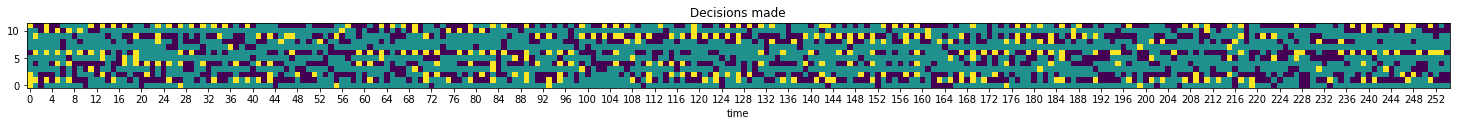

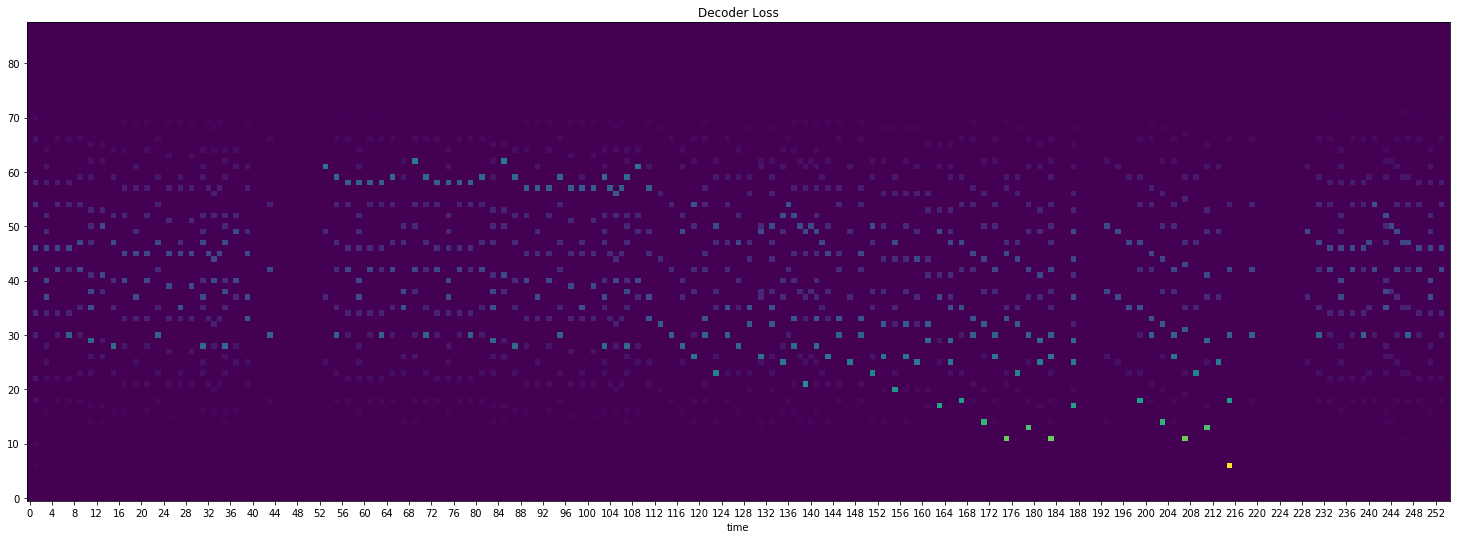

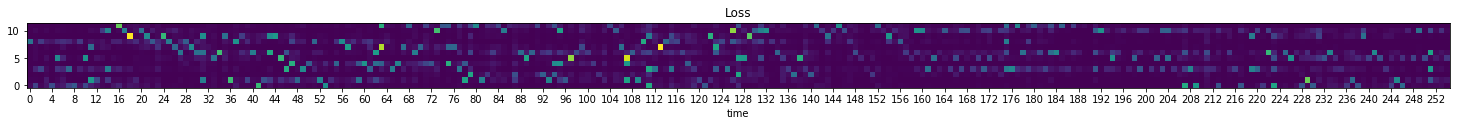

2.28241


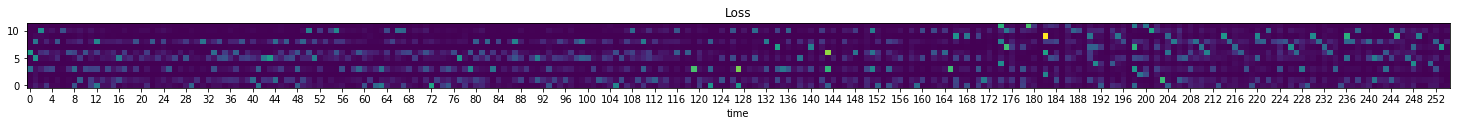

2.31614


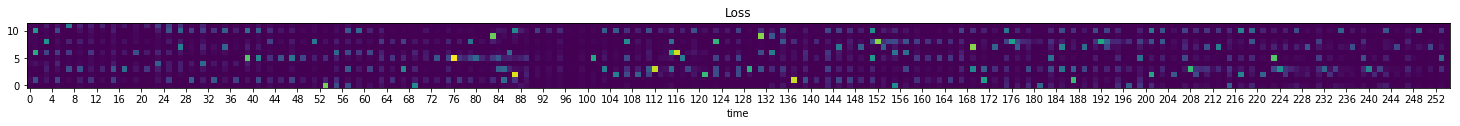

2.31913


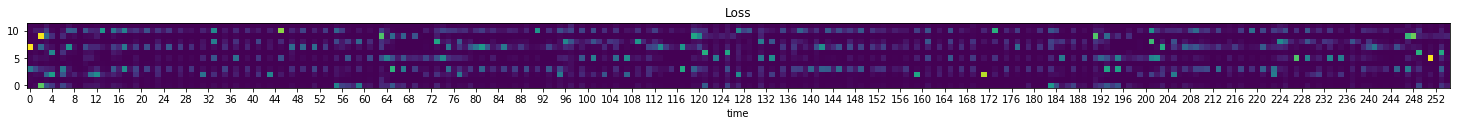

2.28153


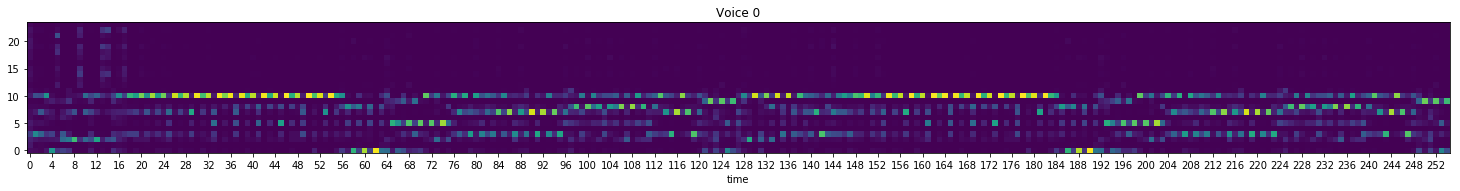

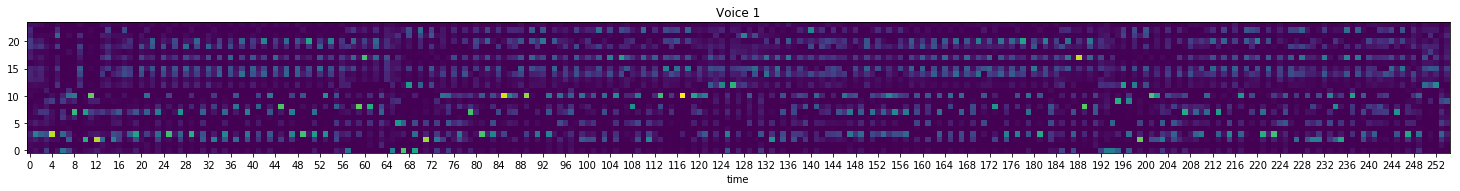

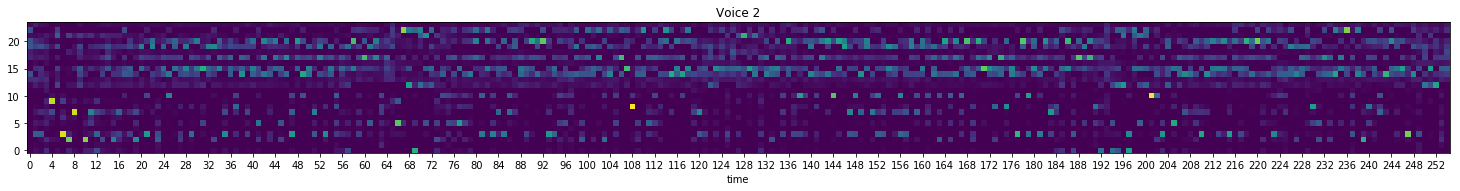

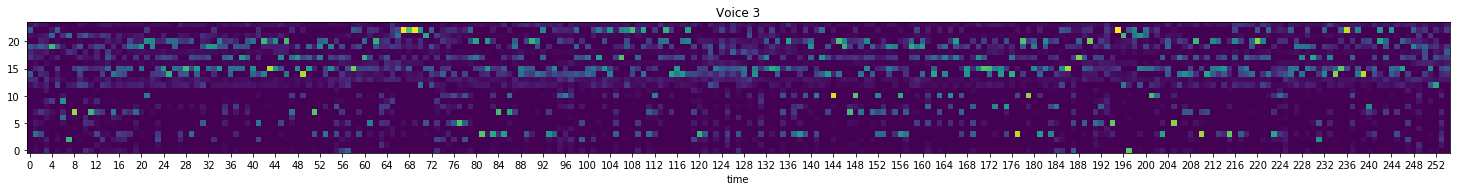

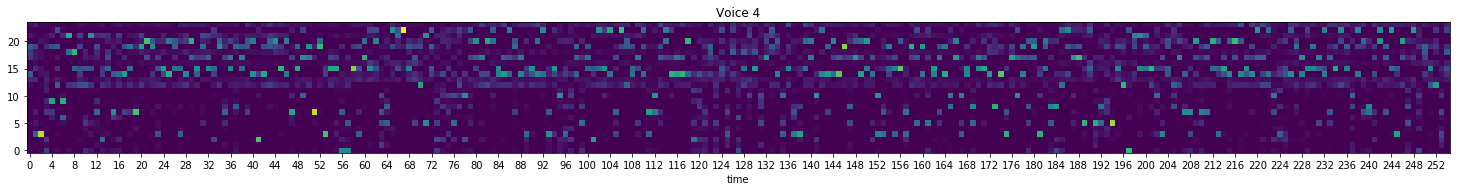

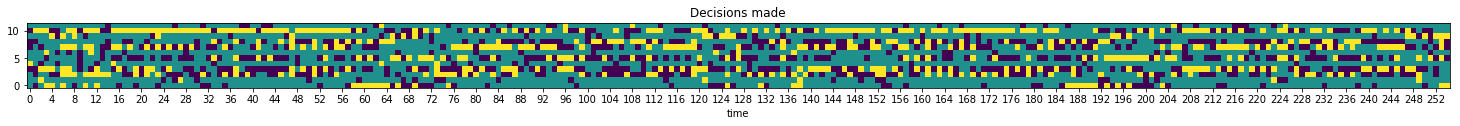

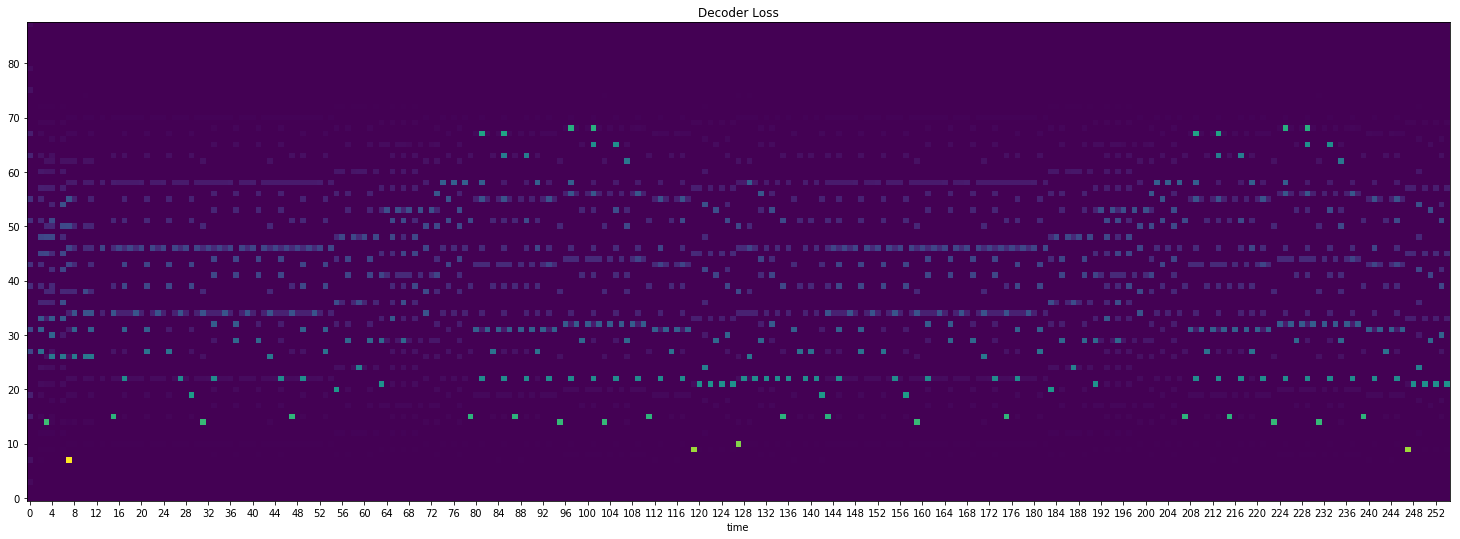

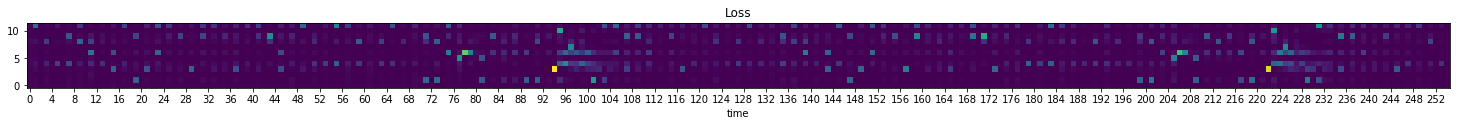

2.36549


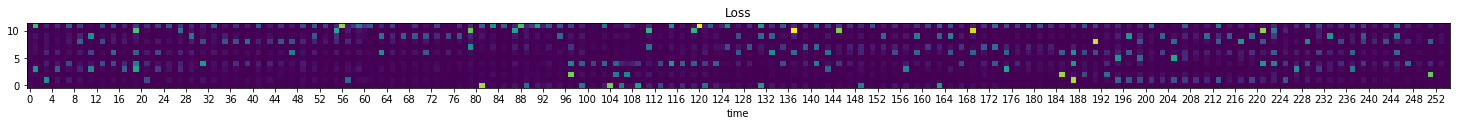

2.43002


KeyboardInterrupt: 

In [143]:
#losses = []
#decoder_losses = []
optimizer = optim.Adam(model.parameters(), lr=0.01)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.01)

for batch_x, batch_decoded in batchGenerator():
    
    loss, decoder_loss, voice_probas, voice_decisions = \
        learn(model, decoder, batch_x, batch_decoded, optimizer, decoder_optimizer)
           
    if len(losses) % 25 == 0:
        drawNotes(loss[:, 0], "Loss")
        print(loss.sum(axis=2).mean())
        
        if len(losses) % 100 == 0:            
            decisions = np.zeros_like(voice_decisions[:, 0, 0, :12])
            for i in range(VOICES):
                drawNotes(voice_probas[:, i, 0], "Voice " + str(i))
                decisions += voice_decisions[:, i, 0, :12]
                decisions -= voice_decisions[:, i, 0, 12:]
            
            drawNotes(decisions, "Decisions made")
            
            drawNotes(decoder_loss[:, 0], "Decoder Loss")
            
            if not loss.sum(axis=2).mean() is None:
                torch.save(model.state_dict(), "HLSTM.pt")
            if not decoder_loss.sum(axis=2).mean() is None:
                torch.save(decoder.state_dict(), "HLSTM decoder.pt")
                
        
    losses.append(loss.sum(axis=2).mean())
    decoder_losses.append(decoder_loss.sum(axis=2).mean())

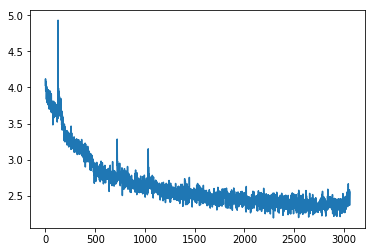

In [144]:
plt.plot(losses)
#plt.ylim([0.14, 0.19])

In [145]:
decoder_loss.mean()

0.035459567

## Юзаем

In [157]:
n = np.random.randint(0, len(songs))
cgen, gen = sample(model, decoder, compress(songs[n][:16]).astype(np.float32), songs[n][:16].astype(np.float32), 192)

In [158]:
from songs import *

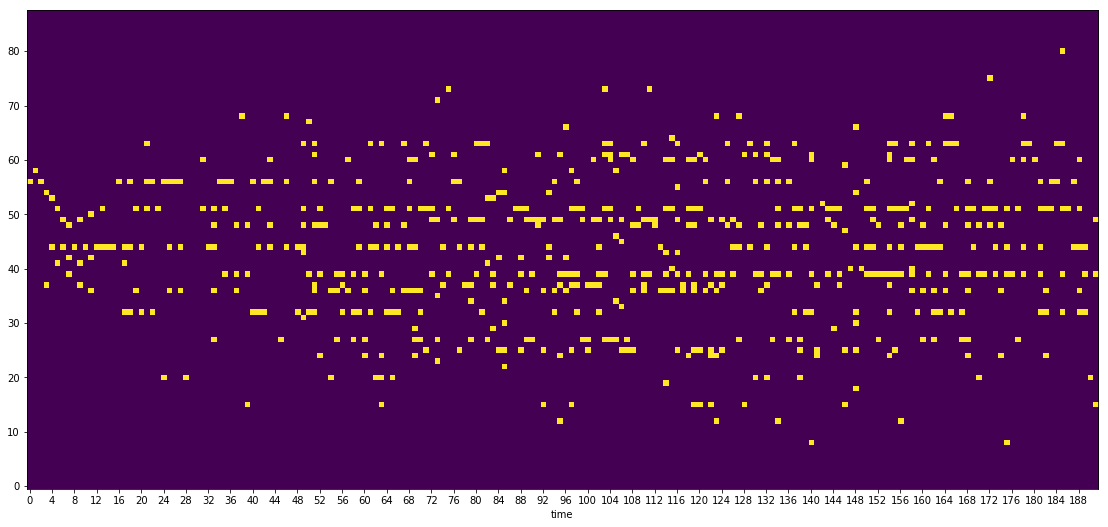

In [148]:
drawNotes(gen)

In [149]:
Song(gen, finished=True).play()

KeyboardInterrupt: 

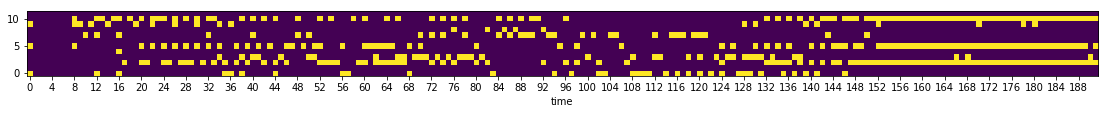

In [159]:
drawNotes(cgen)

In [160]:
full_midi = np.zeros((cgen.shape[0], 88))
full_midi[:, 40:52] = cgen

In [161]:
Song(full_midi, finished=True).play()

In [155]:
# to delete
    
    
    if step % display_step == 0:
        print(L.mean(), " mean for last: ", np.array(losses)[-display_step:].mean())
        drawNotes(L[0], "Loss")
        
        if step % 200 == 0:
            r = sess.run(read_index, feed_dict=fd)
            drawNotes(r[0], "Read")
            
            sn = sess.run(voices_proba, feed_dict=fd)
            for i in range(5):
                drawNotes(sn[i][0], "Voice " + str(i))
            
            sn = sess.run(sampled_notes, feed_dict=fd)
            drawNotes(sn[0] - batch_x[0, 1:, :12]*(1-sn[0]), "Sampled Notes")
                
            sn = sess.run(decoder_ce, feed_dict=fd)
            drawNotes(sn[0], "Decoder Loss")
           
    if len(losses) > display_step and np.array(losses)[-display_step:].mean() < RECORD:
        RECORD = np.array(losses)[-display_step:].mean()
        saver.save(sess, "./tmp/100-100-130 HistoryUser LSTM collapsed Greats1_dataset 8-history 6-times 100-LSTMconditional banning no aposter 100-decoder lr=0.008.ckpt")


IndentationError: unexpected indent (<ipython-input-155-2007eb533ec6>, line 4)